# Final project: Analysis of influx of the metro system as a function of climatic conditions using NN

Daniel Sierra Botero C.C. 1152216176

## Introduction

The prediction of the influx of users is a very useful tool for a wide variety of markets (shopping centers, stores, hospitals, transport systems, etc.) since this allows them to make use of the different resources they have in a more efficient way, reducing the use of resources in periods with less influx and allowing the necessary measures to be taken on maximum peaks to improve the user experience and guarantee a good functioning of the service. In the case of public transport systems, these influxes have been extensively studied in their dependence on time (season of the year, day of the week, hour, etc.), however, the analysis of these influxes of users in function of the climate variables hasn't been reviewed that much, also in a city like Medellin where there is such a variable climate where a storm can fall and make a radiant sun several times in the same day, it is interesting to review the dependence of this type of behavior on climatic variables.

In this project we will try to create a predictive model of the influx of users in the metro system of the city of Medellin taking into account categorical variables such as the station of the system that is being reviewed and the type of day of the week, in addition we will use the climatic data obtained from 'Sistema de Alerta Temprana del valle de Aburrá' SIATA to generate these regression models.

## First process to organize the data 
### (do not run this segment it is just to show the previous process performed on the original data)
In this case the data of the influx (afluencia) of the Metro system was obtained as a dump file to reconstruct using the postgrSQL program (I don't know much about this program, I only learned the basics to be able to use the data in python), below we can see the code that we use to group the data according to the categories that we are going to take into account.

In [29]:
#connect to the postgreSQL server where the data is located
conn = psycopg2.connect(host="localhost",
                        database="afluencia",
                        user="postgres",
                        password="PGde_v191")

In [30]:
#take the data from postgreSQL directly grouped by season, type of day (working, Saturday or Sunday/holiday), date and time.
cur = conn.cursor()
cur.execute('''
    SELECT parada, tipo_dia, fecha, hora, SUM(usos)
    FROM afluencia_2021.afluencia_2021
    GROUP BY parada, tipo_dia, fecha, hora''')
data = cur.fetchall()

The original database has more categories that in this case we do not consider so useful, such as type of traveler, route, route code, etc. So these are discarded to reduce the volume of data with which to work.

In [31]:
#take the column names
cols = []
for i in cur.description:
    cols.append(i[0])

In [32]:
#create de dataframe for the data
afluencia_2021 = pd.DataFrame(data=data,columns=cols)

In [34]:
#combine the date and time columns and gave them the datetime fotmar
afluencia_2021['fecha_hora'] = pd.to_datetime(afluencia_2021['fecha'].astype(str) + ' ' + afluencia_2021['hora'].astype(str) + ':00:00')
afluencia_2021 = afluencia_2021.drop(columns=['fecha','hora'])

afluencia_2021.to_csv('afluencia_2021.csv')

As the idea is to generate an influx model based on data obtained by Siata and the data obtained from Siata is gathered by month, it was decided to reduce the analysis to data for the month of January 2021

In [36]:
#get a new dataframe with only the data for the month of January
mask = (afluencia_2021['fecha_hora'] >= '2021-01-01') & (afluencia_2021['fecha_hora'] <= '2021-01-31')
afluencia_enero = afluencia_2021.loc[mask]
#the data is saved in a csv to make it easier to handle the data later
afluencia_enero.to_csv('afluencia_enero.csv')
afluencia_enero

parada           tipo_dia     sum          fecha_hora
0         ACE  Domingo y Festivo   213.0 2021-01-03 04:00:00
1         ACE  Domingo y Festivo   535.0 2021-01-03 05:00:00
2         ACE  Domingo y Festivo   543.0 2021-01-03 06:00:00
3         ACE  Domingo y Festivo   497.0 2021-01-03 07:00:00
4         ACE  Domingo y Festivo   512.0 2021-01-03 08:00:00
5         ACE  Domingo y Festivo   532.0 2021-01-03 09:00:00
6         ACE  Domingo y Festivo   555.0 2021-01-03 10:00:00
7         ACE  Domingo y Festivo   520.0 2021-01-03 11:00:00
8         ACE  Domingo y Festivo   486.0 2021-01-03 12:00:00
9         ACE  Domingo y Festivo   515.0 2021-01-03 13:00:00
10        ACE  Domingo y Festivo   493.0 2021-01-03 14:00:00
11        ACE  Domingo y Festivo   526.0 2021-01-03 15:00:00
12        ACE  Domingo y Festivo   634.0 2021-01-03 16:00:00
13        ACE  Domingo y Festivo   467.0 2021-01-03 17:00:00
14        ACE  Domingo y Festivo   438.0 2021-01-03 18:00:00
15        ACE  Domingo y Festivo   371.0 2021-01-03 19:00:00
16        ACE  Domingo y Festivo   301.0 2021-01-03 20:00:00
17        ACE  Domingo y Festivo   167.0 2021-01-03 21:00:00
18        ACE  Domingo y Festivo    19.0 2021-01-03 22:00:00
19        ACE  Domingo y Festivo   282.0 2021-01-10 04:00:00
20        ACE  Domingo y Festivo   561.0 2021-01-10 05:00:00
21        ACE  Domingo y Festivo   429.0 2021-01-10 06:00:00
22        ACE  Domingo y Festivo   286.0 2021-01-10 07:00:00
23        ACE  Domingo y Festivo   173.0 2021-01-10 08:00:00
24        ACE  Domingo y Festivo   122.0 2021-01-10 09:00:00
25        ACE  Domingo y Festivo   161.0 2021-01-10 10:00:00
26        ACE  Domingo y Festivo   125.0 2021-01-10 11:00:00
27        ACE  Domingo y Festivo   180.0 2021-01-10 12:00:00
28        ACE  Domingo y Festivo   123.0 2021-01-10 13:00:00
29        ACE  Domingo y Festivo   140.0 2021-01-10 14:00:00
...       ...                ...     ...                 ...
844948    XPO             Sábado  1131.0 2021-01-23 14:00:00
844949    XPO             Sábado   885.0 2021-01-23 15:00:00
844950    XPO             Sábado   757.0 2021-01-23 16:00:00
844951    XPO             Sábado   764.0 2021-01-23 17:00:00
844952    XPO             Sábado   643.0 2021-01-23 18:00:00
844953    XPO             Sábado   588.0 2021-01-23 19:00:00
844954    XPO             Sábado   566.0 2021-01-23 20:00:00
844955    XPO             Sábado   368.0 2021-01-23 21:00:00
844956    XPO             Sábado   140.0 2021-01-23 22:00:00
844957    XPO             Sábado     2.0 2021-01-23 23:00:00
844958    XPO             Sábado   151.0 2021-01-30 04:00:00
844959    XPO             Sábado   480.0 2021-01-30 05:00:00
844960    XPO             Sábado   514.0 2021-01-30 06:00:00
844961    XPO             Sábado   519.0 2021-01-30 07:00:00
844962    XPO             Sábado   383.0 2021-01-30 08:00:00
844963    XPO             Sábado   367.0 2021-01-30 09:00:00
844964    XPO             Sábado   414.0 2021-01-30 10:00:00
844965    XPO             Sábado   561.0 2021-01-30 11:00:00
844966    XPO             Sábado  1014.0 2021-01-30 12:00:00
844967    XPO             Sábado  1313.0 2021-01-30 13:00:00
844968    XPO             Sábado  1084.0 2021-01-30 14:00:00
844969    XPO             Sábado   991.0 2021-01-30 15:00:00
844970    XPO             Sábado   824.0 2021-01-30 16:00:00
844971    XPO             Sábado   803.0 2021-01-30 17:00:00
844972    XPO             Sábado   759.0 2021-01-30 18:00:00
844973    XPO             Sábado   602.0 2021-01-30 19:00:00
844974    XPO             Sábado   537.0 2021-01-30 20:00:00
844975    XPO             Sábado   373.0 2021-01-30 21:00:00
844976    XPO             Sábado   150.0 2021-01-30 22:00:00
844977    XPO             Sábado     4.0 2021-01-30 23:00:00

[65301 rows x 4 columns]

The meteorological data obtained by Siata present the variables to be analyzed (humidity, precipitation, pressure and temperature) in intervals of 1 minute throughout the month for each of the meteorological stations that have the data available.

In [123]:
#combine all fetched data into a single dataframe
all_files = glob.glob("datos_siata/*.csv")

i=0

for filename in all_files:
    if i==0:
        datos_siata = pd.read_csv(filename, index_col=None, header=0).drop(columns=['Calidad'])
    else:
        df = pd.read_csv(filename, index_col=None, header=0).drop(columns=['Calidad'])
        datos_siata = pd.merge(datos_siata, df, on='fecha_hora', how='outer')
    i=i+1

datos_siata

fecha_hora  Humedad_1019  Humedad_105  Humedad_122  \
0      2021-01-01 00:00:00     89.000000         87.7         87.7   
1      2021-01-01 00:00:00     89.000000         87.7         87.7   
2      2021-01-01 00:00:00     89.000000         87.7         87.7   
3      2021-01-01 00:00:00     89.000000         87.7         87.7   
4      2021-01-01 00:00:00     89.000000         87.7         87.7   
...                    ...           ...          ...          ...   
47334  2021-01-31 23:55:00     79.000000         71.7         75.1   
47335  2021-01-31 23:56:00     78.330002         71.9         74.6   
47336  2021-01-31 23:57:00     76.580002         72.0         74.9   
47337  2021-01-31 23:58:00     74.279999         72.1         74.5   
47338  2021-01-31 23:59:00     76.949997         72.1         74.4   

       Humedad_197  Humedad_198  Humedad_201  Humedad_202  Humedad_203  \
0             83.0    78.000000         79.5         80.1         73.1   
1             83.0    78.000000         79.5         80.1         73.1   
2             83.0    78.000000         79.5         80.1         73.1   
3             83.0    78.000000         79.5         80.1         73.1   
4             83.0    78.000000         79.5         80.1         73.1   
...            ...          ...          ...          ...          ...   
47334         75.0    64.000000         68.1         57.9         61.8   
47335         75.0    64.000000         67.0         59.2         61.3   
47336         75.0    63.650002         64.6         60.2         61.4   
47337         75.0    63.000000         61.5         60.9         61.5   
47338         74.0    63.000000         64.6         60.8         61.6   

       Humedad_206  ...  Temperatura_399  Temperatura_403  Temperatura_427  \
0             87.0  ...        17.500000        25.860001        19.200001   
1             87.0  ...        17.500000        25.860001        19.200001   
2             87.0  ...        17.500000        25.860001        19.200001   
3             87.0  ...        17.500000        25.860001        19.200001   
4             87.0  ...        17.500000        25.860001        19.200001   
...            ...  ...              ...              ...              ...   
47334         73.6  ...        19.400000        26.400000        21.000000   
47335         73.7  ...        19.400000        26.400000        20.900000   
47336         73.4  ...        19.389999        26.400000        20.930000   
47337         73.0  ...        19.299999        26.400000        20.900000   
47338         73.0  ...        19.299999      -999.000000        20.900000   

       Temperatura_450  Temperatura_478  Temperatura_59  Temperatura_68  \
0            16.400000        20.299999            18.7            19.7   
1            16.400000        20.299999            18.7            19.7   
2            16.400000        20.299999            18.7            19.7   
3            16.400000        20.299999            18.7            19.7   
4            16.400000        20.299999            18.7            19.7   
...                ...              ...             ...             ...   
47334        18.700001        22.100000            19.9            21.3   
47335        18.730000        22.100000            19.9            21.3   
47336        18.799999        22.100000            20.0            21.4   
47337        18.740000        22.100000            20.0            21.4   
47338        18.690001        22.100000            19.9            21.4   

       Temperatura_73  Temperatura_82  Temperatura_83  
0                19.2            18.6            17.2  
1                19.2            18.6            17.2  
2                19.2            18.6            17.2  
3                19.2            18.6            17.2  
4                19.2            18.6            17.2  
...               ...             ...             ...  
47334            19.9            19.4            18.2  


The quality ('Calidad') column in this case is mainly to categorize whether the data was taken in real time or not and how reliable this measure is, since later we will be able to observe that the quality of the data is not the best we will ignore this parameter and later we will make an adjustment of the less reliable data based on its behavior

In [125]:
#give the 'date_time' column the proper format
datos_siata['fecha_hora'] = pd.to_datetime(datos_siata['fecha_hora'])
#the data is saved in a csv to make it easier to handle the data later
datos_siata.to_csv('datos_siata.csv')

0       2021-01-01 00:00:00
1       2021-01-01 00:00:00
2       2021-01-01 00:00:00
3       2021-01-01 00:00:00
4       2021-01-01 00:00:00
                ...        
47334   2021-01-31 23:55:00
47335   2021-01-31 23:56:00
47336   2021-01-31 23:57:00
47337   2021-01-31 23:58:00
47338   2021-01-31 23:59:00
Name: fecha_hora, Length: 47339, dtype: datetime64[ns]

## Import necessary libraries
### (Run from here)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
#import psycopg2
import glob
import os
import random
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras import layers, losses, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout

In [2]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

## Import data

In [3]:
afluencia_enero = pd.read_csv('afluencia_2021.csv',index_col=0)
datos_siata = pd.read_csv('datos_siata.csv',index_col=1)

## Replace null data with nan
In the case of the Siata dataset, the null data is represented by -999

In [4]:
#replace -999 values with nan
datos_siata = datos_siata.replace(-999, np.nan)
datos_siata.index = pd.to_datetime(datos_siata.index)
datos_siata

Unnamed: 0  Humedad_1019  Humedad_105  Humedad_122  \
fecha_hora                                                                
2021-01-01 00:00:00           0     89.000000         87.7         87.7   
2021-01-01 00:00:00           1     89.000000         87.7         87.7   
2021-01-01 00:00:00           2     89.000000         87.7         87.7   
2021-01-01 00:00:00           3     89.000000         87.7         87.7   
2021-01-01 00:00:00           4     89.000000         87.7         87.7   
...                         ...           ...          ...          ...   
2021-01-31 23:55:00       47334     79.000000         71.7         75.1   
2021-01-31 23:56:00       47335     78.330002         71.9         74.6   
2021-01-31 23:57:00       47336     76.580002         72.0         74.9   
2021-01-31 23:58:00       47337     74.279999         72.1         74.5   
2021-01-31 23:59:00       47338     76.949997         72.1         74.4   

                     Humedad_197  Humedad_198  Humedad_201  Humedad_202  \
fecha_hora                                                                
2021-01-01 00:00:00         83.0    78.000000         79.5         80.1   
2021-01-01 00:00:00         83.0    78.000000         79.5         80.1   
2021-01-01 00:00:00         83.0    78.000000         79.5         80.1   
2021-01-01 00:00:00         83.0    78.000000         79.5         80.1   
2021-01-01 00:00:00         83.0    78.000000         79.5         80.1   
...                          ...          ...          ...          ...   
2021-01-31 23:55:00         75.0    64.000000         68.1         57.9   
2021-01-31 23:56:00         75.0    64.000000         67.0         59.2   
2021-01-31 23:57:00         75.0    63.650002         64.6         60.2   
2021-01-31 23:58:00         75.0    63.000000         61.5         60.9   
2021-01-31 23:59:00         74.0    63.000000         64.6         60.8   

                     Humedad_203  Humedad_206  ...  Temperatura_399  \
fecha_hora                                     ...                    
2021-01-01 00:00:00         73.1         87.0  ...        17.500000   
2021-01-01 00:00:00         73.1         87.0  ...        17.500000   
2021-01-01 00:00:00         73.1         87.0  ...        17.500000   
2021-01-01 00:00:00         73.1         87.0  ...        17.500000   
2021-01-01 00:00:00         73.1         87.0  ...        17.500000   
...                          ...          ...  ...              ...   
2021-01-31 23:55:00         61.8         73.6  ...        19.400000   
2021-01-31 23:56:00         61.3         73.7  ...        19.400000   
2021-01-31 23:57:00         61.4         73.4  ...        19.389999   
2021-01-31 23:58:00         61.5         73.0  ...        19.299999   
2021-01-31 23:59:00         61.6         73.0  ...        19.299999   

                     Temperatura_403  Temperatura_427  Temperatura_450  \
fecha_hora                                                               
2021-01-01 00:00:00        25.860001        19.200001        16.400000   
2021-01-01 00:00:00        25.860001        19.200001        16.400000   
2021-01-01 00:00:00        25.860001        19.200001        16.400000   
2021-01-01 00:00:00        25.860001        19.200001        16.400000   
2021-01-01 00:00:00        25.860001        19.200001        16.400000   
...                              ...              ...              ...   
2021-01-31 23:55:00        26.400000        21.000000        18.700001   
2021-01-31 23:56:00        26.400000        20.900000        18.730000   
2021-01-31 23:57:00        26.400000        20.930000        18.799999   
2021-01-31 23:58:00        26.400000        20.900000        18.740000   
2021-01-31 23:59:00              NaN        20.900000        18.690001   

                     Temperatura_478  Temperatura_59  Temperatura_68  \
fecha_hora                                                             
2021-01-01 00:00:00        20.299999  

## Amount of missing data

We review the amount of missing data for each category, as we can see the database is not very complete.

In [6]:
obj = datos_siata.isnull().sum()

for key,value in obj.iteritems():
    print(key,":",value)

Unnamed: 0 : 0
Humedad_1019 : 3
Humedad_105 : 1
Humedad_122 : 1566
Humedad_197 : 2799
Humedad_198 : 681
Humedad_201 : 5
Humedad_202 : 0
Humedad_203 : 4089
Humedad_206 : 0
Humedad_207 : 1426
Humedad_229 : 109
Humedad_249 : 0
Humedad_252 : 18
Humedad_269 : 542
Humedad_271 : 2061
Humedad_313 : 2
Humedad_318 : 78
Humedad_345 : 496
Humedad_349 : 0
Humedad_354 : 0
Humedad_355 : 6898
Humedad_360 : 11624
Humedad_362 : 0
Humedad_367 : 2
Humedad_368 : 1556
Humedad_397 : 0
Humedad_399 : 1
Humedad_403 : 1194
Humedad_419 : 0
Humedad_427 : 18
Humedad_448 : 0
Humedad_450 : 6357
Humedad_478 : 0
Humedad_59 : 105
Humedad_68 : 2828
Humedad_73 : 2978
Humedad_82 : 1
Humedad_83 : 26
P1_1019 : 3
P2_1019 : 47339
P1_105 : 1
P2_105 : 1
P1_10 : 55
P2_10 : 55
P1_11 : 58
P2_11 : 58
P1_121 : 0
P2_121 : 0
P1_122 : 1566
P2_122 : 1566
P1_127 : 125
P2_127 : 125
P1_129 : 1657
P2_129 : 1657
P1_12 : 243
P2_12 : 243
P1_139 : 8782
P2_139 : 47339
P1_146 : 1
P2_146 : 2
P1_14 : 5970
P2_14 : 5970
P1_15 : 15
P2_15 : 15
P1_160 : 

In this case, since we have so many different variables (which, being measurements of the same quantities in different sectors of the city, probably present a very high correlation) we will directly eliminate the columns that are missing more than 25% of their total data (approximately a number of null data greater than 11,000)

In [7]:
#find and drop the columns with more than 25% missing data
drop = []

for key,value in obj.iteritems():
    if value >= 11000:
        drop = np.append(drop,key)
        
datos_siata = datos_siata.drop(drop, axis=1)

In [7]:
#remaining data
obj = datos_siata.isnull().sum()

for key,value in obj.iteritems():
    print(key,":",value)

Unnamed: 0 : 0
Humedad_1019 : 3
Humedad_105 : 1
Humedad_122 : 1566
Humedad_197 : 2799
Humedad_198 : 681
Humedad_201 : 5
Humedad_202 : 0
Humedad_203 : 4089
Humedad_206 : 0
Humedad_207 : 1426
Humedad_229 : 109
Humedad_249 : 0
Humedad_252 : 18
Humedad_269 : 542
Humedad_271 : 2061
Humedad_313 : 2
Humedad_318 : 78
Humedad_345 : 496
Humedad_349 : 0
Humedad_354 : 0
Humedad_355 : 6898
Humedad_362 : 0
Humedad_367 : 2
Humedad_368 : 1556
Humedad_397 : 0
Humedad_399 : 1
Humedad_403 : 1194
Humedad_419 : 0
Humedad_427 : 18
Humedad_448 : 0
Humedad_450 : 6357
Humedad_478 : 0
Humedad_59 : 105
Humedad_68 : 2828
Humedad_73 : 2978
Humedad_82 : 1
Humedad_83 : 26
P1_1019 : 3
P1_105 : 1
P2_105 : 1
P1_10 : 55
P2_10 : 55
P1_11 : 58
P2_11 : 58
P1_121 : 0
P2_121 : 0
P1_122 : 1566
P2_122 : 1566
P1_127 : 125
P2_127 : 125
P1_129 : 1657
P2_129 : 1657
P1_12 : 243
P2_12 : 243
P1_139 : 8782
P1_146 : 1
P2_146 : 2
P1_14 : 5970
P2_14 : 5970
P1_15 : 15
P2_15 : 15
P1_165 : 4352
P2_165 : 4352
P1_168 : 4750
P2_168 : 4750
P1_1

## Data visualization
As we could see previously, almost all the columns of the data obtained from Siata present missing values, so we will review the general behavior of each type of data in order to discern if this values should be droped or if there is some way to approximate the missing data taking into account the general behavior of these variables.

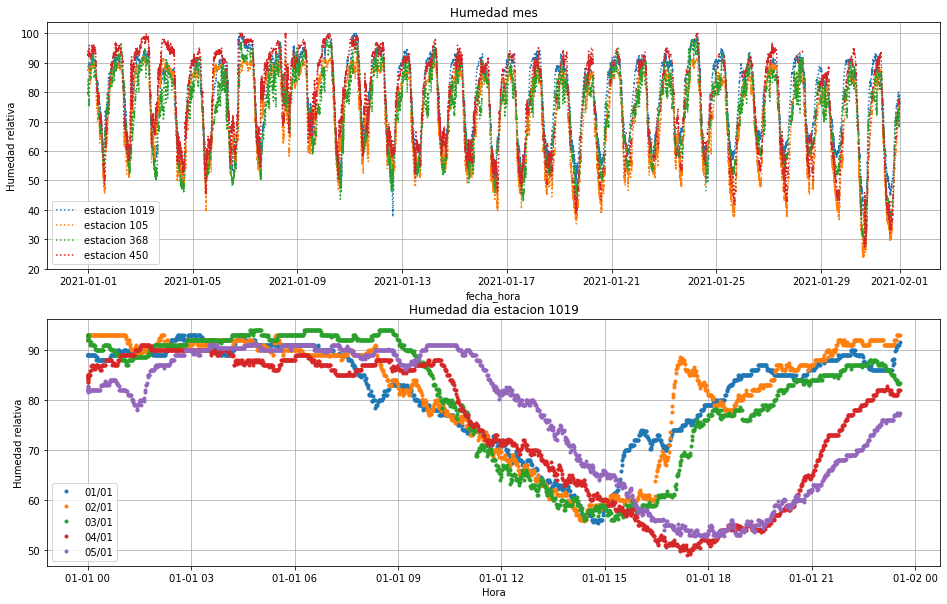

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

#Humedad

ax[0].set_title('Humedad mes')
ax[0].plot(datos_siata.index, datos_siata.Humedad_1019, ':', label='estacion 1019')
ax[0].plot(datos_siata.index, datos_siata.Humedad_105, ':', label='estacion 105')
ax[0].plot(datos_siata.index, datos_siata.Humedad_368, ':', label='estacion 368')
ax[0].plot(datos_siata.index, datos_siata.Humedad_450, ':', label='estacion 450')
ax[0].set_xlabel('fecha_hora')
ax[0].set_ylabel('Humedad relativa')
ax[0].grid()
ax[0].legend()

ax[1].set_title('Humedad dia estacion 1019')
ax[1].plot(datos_siata.index[0:1440], datos_siata.Humedad_1019[0:1440], '.', label='01/01')
ax[1].plot(datos_siata.index[0:1440], datos_siata.Humedad_1019[1440:2880], '.', label='02/01')
ax[1].plot(datos_siata.index[0:1440], datos_siata.Humedad_1019[2880:4320], '.', label='03/01')
ax[1].plot(datos_siata.index[0:1440], datos_siata.Humedad_1019[4320:5760], '.', label='04/01')
ax[1].plot(datos_siata.index[0:1440], datos_siata.Humedad_1019[5760:7200], '.', label='05/01')
ax[1].set_xlabel('Hora')
ax[1].set_ylabel('Humedad relativa')
ax[1].grid()
ax[1].legend()

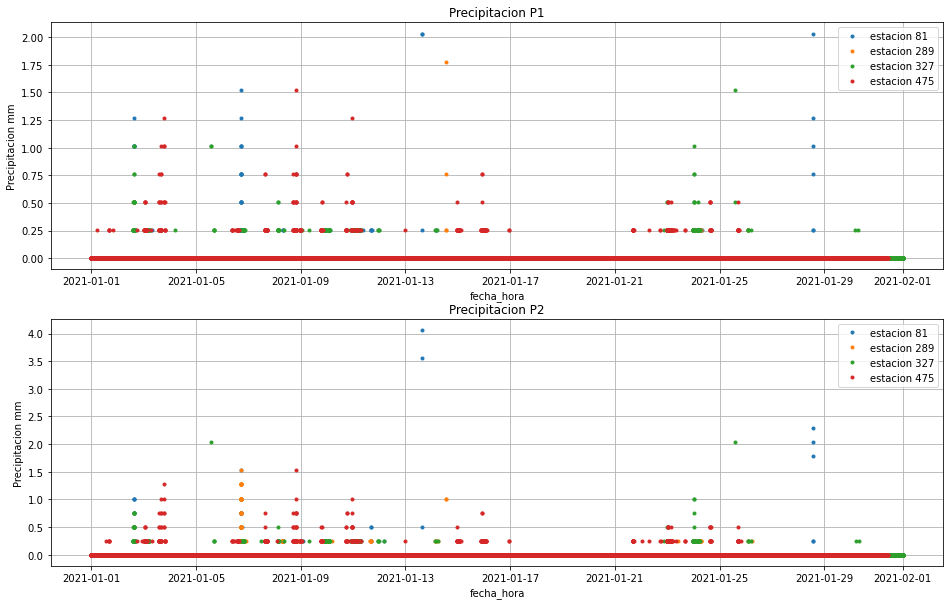

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

#precipitacion

ax[0].set_title('Precipitacion P1')
ax[0].plot(datos_siata.index, datos_siata.P1_81, '.', label='estacion 81')
ax[0].plot(datos_siata.index, datos_siata.P1_289, '.', label='estacion 289')
ax[0].plot(datos_siata.index, datos_siata.P1_327, '.', label='estacion 327')
ax[0].plot(datos_siata.index, datos_siata.P1_475, '.', label='estacion 475')
ax[0].set_xlabel('fecha_hora')
ax[0].set_ylabel('Precipitacion mm')
ax[0].grid()
ax[0].legend()

ax[1].set_title('Precipitacion P2')
ax[1].plot(datos_siata.index, datos_siata.P2_81, '.', label='estacion 81')
ax[1].plot(datos_siata.index, datos_siata.P2_289, '.', label='estacion 289')
ax[1].plot(datos_siata.index, datos_siata.P2_327, '.', label='estacion 327')
ax[1].plot(datos_siata.index, datos_siata.P2_475, '.', label='estacion 475')
ax[1].set_xlabel('fecha_hora')
ax[1].set_xlabel('fecha_hora')
ax[1].set_ylabel('Precipitacion mm')
ax[1].grid()
ax[1].legend()

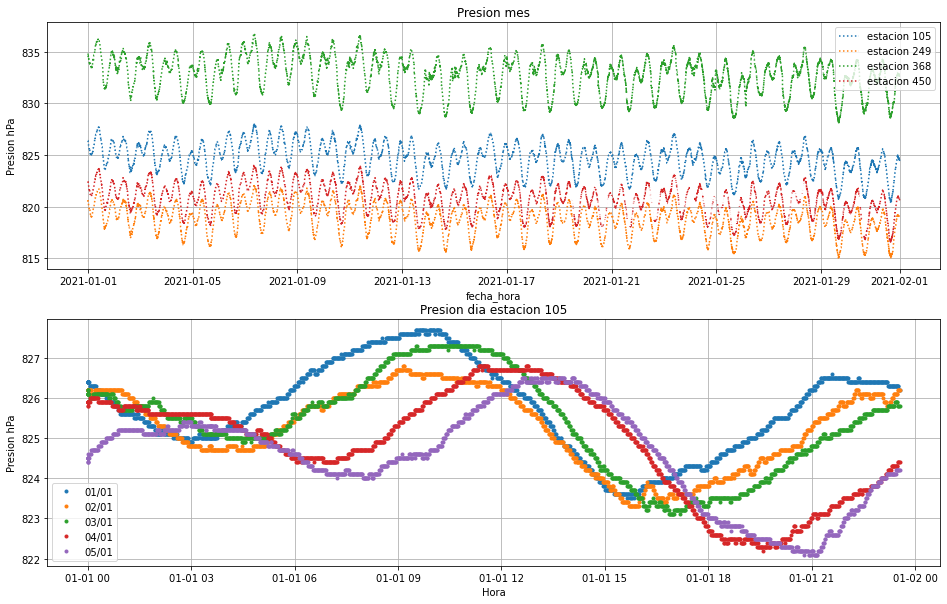

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

#presion

ax[0].set_title('Presion mes')
ax[0].plot(datos_siata.index, datos_siata.Presion_105, ':', label='estacion 105')
ax[0].plot(datos_siata.index, datos_siata.Presion_249, ':', label='estacion 249')
ax[0].plot(datos_siata.index, datos_siata.Presion_368, ':', label='estacion 368')
ax[0].plot(datos_siata.index, datos_siata.Presion_450, ':', label='estacion 450')
ax[0].set_xlabel('fecha_hora')
ax[0].set_ylabel('Presion hPa')
ax[0].grid()
ax[0].legend()

ax[1].set_title('Presion dia estacion 105')
ax[1].plot(datos_siata.index[0:1440], datos_siata.Presion_105[0:1440], '.', label='01/01')
ax[1].plot(datos_siata.index[0:1440], datos_siata.Presion_105[1440:2880], '.', label='02/01')
ax[1].plot(datos_siata.index[0:1440], datos_siata.Presion_105[2880:4320], '.', label='03/01')
ax[1].plot(datos_siata.index[0:1440], datos_siata.Presion_105[4320:5760], '.', label='04/01')
ax[1].plot(datos_siata.index[0:1440], datos_siata.Presion_105[5760:7200], '.', label='05/01')
ax[1].set_xlabel('Hora')
ax[1].set_ylabel('Presion hPa')
ax[1].grid()
ax[1].legend()

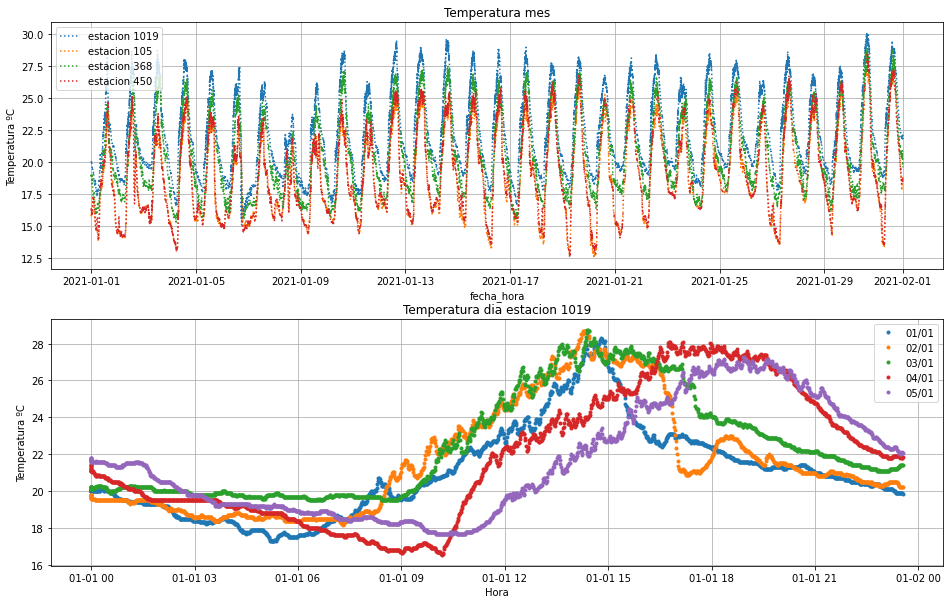

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(16, 10))

#Humedad

ax[0].set_title('Temperatura mes')
ax[0].plot(datos_siata.index, datos_siata.Temperatura_1019, ':', label='estacion 1019')
ax[0].plot(datos_siata.index, datos_siata.Temperatura_105, ':', label='estacion 105')
ax[0].plot(datos_siata.index, datos_siata.Temperatura_368, ':', label='estacion 368')
ax[0].plot(datos_siata.index, datos_siata.Temperatura_450, ':', label='estacion 450')
ax[0].set_xlabel('fecha_hora')
ax[0].set_ylabel('Temperatura ºC')
ax[0].grid()
ax[0].legend()

ax[1].set_title('Temperatura dia estacion 1019')
ax[1].plot(datos_siata.index[0:1440], datos_siata.Temperatura_1019[0:1440], '.', label='01/01')
ax[1].plot(datos_siata.index[0:1440], datos_siata.Temperatura_1019[1440:2880], '.', label='02/01')
ax[1].plot(datos_siata.index[0:1440], datos_siata.Temperatura_1019[2880:4320], '.', label='03/01')
ax[1].plot(datos_siata.index[0:1440], datos_siata.Temperatura_1019[4320:5760], '.', label='04/01')
ax[1].plot(datos_siata.index[0:1440], datos_siata.Temperatura_1019[5760:7200], '.', label='05/01')
ax[1].set_xlabel('Hora')
ax[1].set_ylabel('Temperatura ºC')
ax[1].grid()
ax[1].legend()

On the other hand, we can visualize the distribution of the missing data on each of the columns, where the white stripes represent the missing values.

Text(0.5, 1.0, 'Missing data in Humedad')

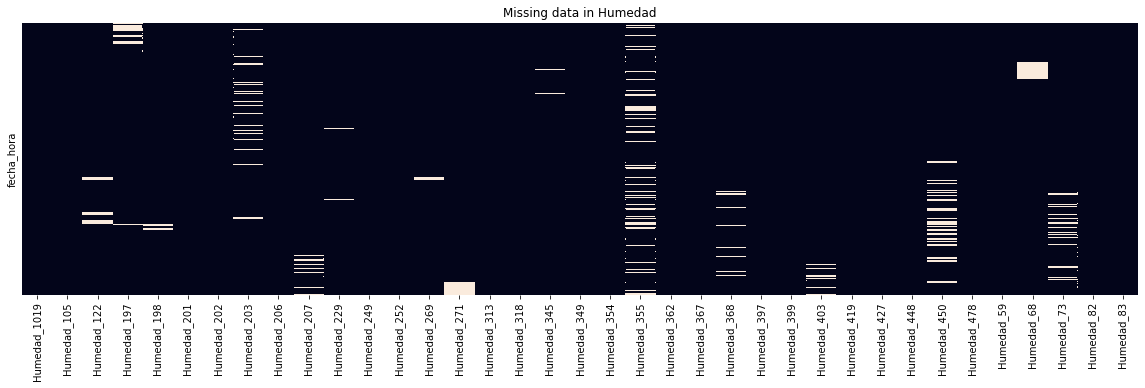

In [12]:
plt.figure(figsize=(20, 5))
sns.heatmap(datos_siata.loc[:,'Humedad_1019':'Humedad_83'].isnull(), cbar=False, yticklabels=False)
plt.title('Missing data in Humedad')

Text(0.5, 1.0, 'Missing data in Precipitacion')

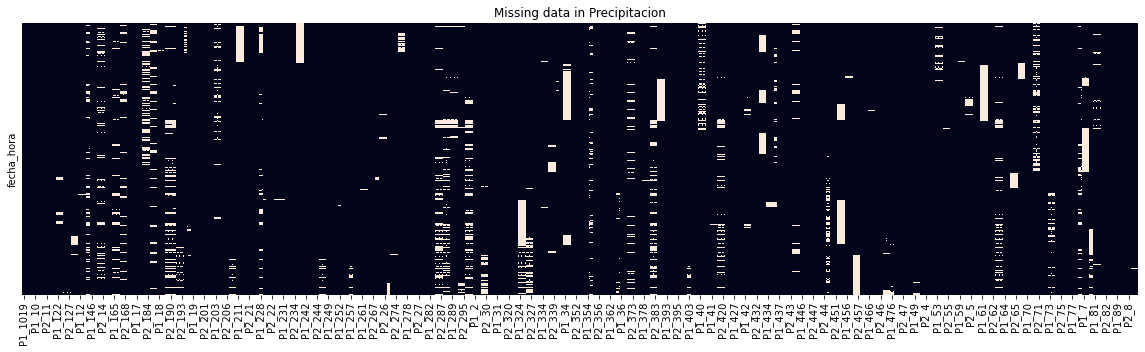

In [13]:
plt.figure(figsize=(20, 5))
sns.heatmap(datos_siata.loc[:,'P1_1019':'P2_9'].isnull(), cbar=False, yticklabels=False)
plt.title('Missing data in Precipitacion')

Text(0.5, 1.0, 'Missing data in Presion')

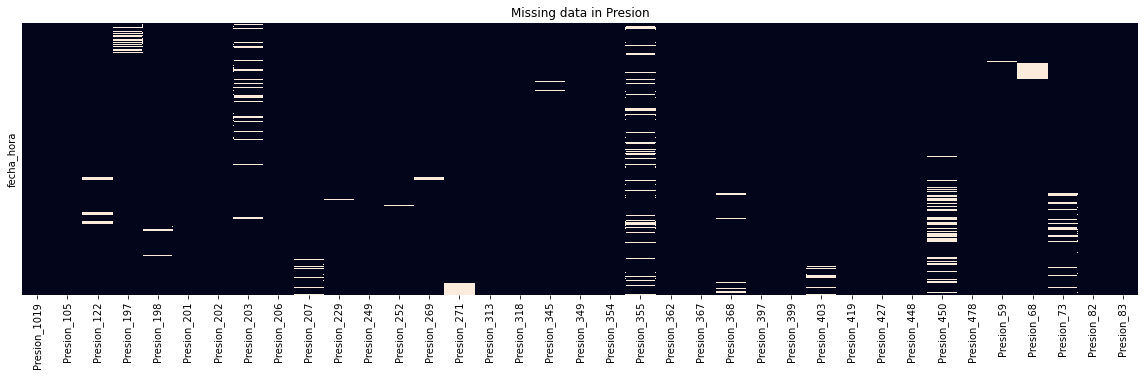

In [14]:
plt.figure(figsize=(20, 5))
sns.heatmap(datos_siata.loc[:,'Presion_1019':'Presion_83'].isnull(), cbar=False, yticklabels=False)
plt.title('Missing data in Presion')

Text(0.5, 1.0, 'Missing data in temperatura')

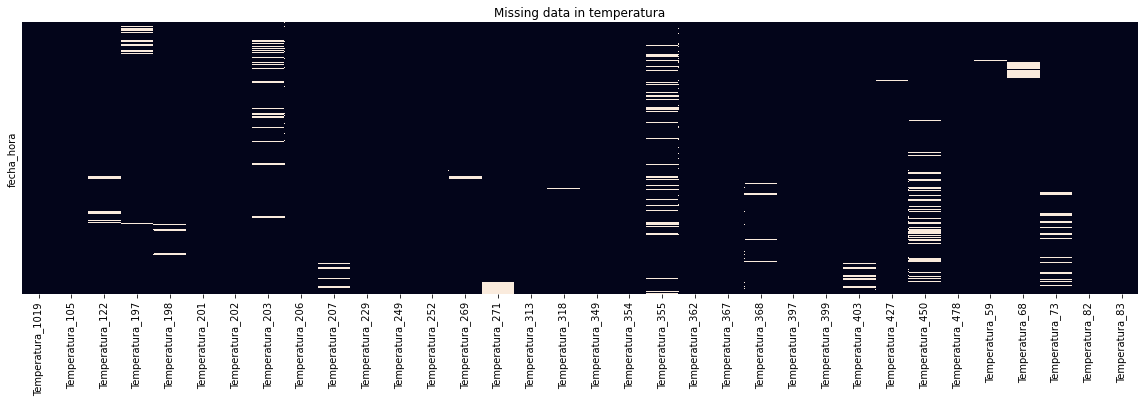

In [15]:
plt.figure(figsize=(20, 5))
sns.heatmap(datos_siata.loc[:,'Temperatura_1019':'Temperatura_83'].isnull(), cbar=False, yticklabels=False)
plt.title('Missing data in temperatura')

## Replace missing data
In the case of the humidity, pressure and temperature variables, we can see that the behavior of the data as a function of time is approximately continuous and cyclical and we can see that in the vast majority of stations the missing data are well distributed over time and are not concentrated in a single period of time (except for station number 68 and 271). Taking this into account, it was decided to use a simple linear interpolation method to fill in the missing data for this type of variables.

In [8]:
datos_siata.loc[:,'Humedad_1019':'Humedad_83'] = datos_siata.loc[:,'Humedad_1019':'Humedad_83'].interpolate()
datos_siata.loc[:,'Presion_1019':'Presion_83'] = datos_siata.loc[:,'Presion_1019':'Presion_83'].interpolate()
datos_siata.loc[:,'Temperatura_1019':'Temperatura_83'] = datos_siata.loc[:,'Temperatura_1019':'Temperatura_83'].interpolate()

In the case of the precipitation variable, we observe that most of the values presented in the different stations are 0 except for some specific peaks that correspond to periods of rain, in this case an approximation of the missing data cannot be made using interpolation since the behavior is not continuous and there are several stations with very long periods of time with missing data. Taking this into account, the missing values were replaced by 0, this clearly can generate errors in the model since periods where there could be precipitation are completely eliminated, but since we have such a high number of meteorological stations in this particular variable, it is posible that the error decreases.

In [9]:
datos_siata.loc[:,'P1_1019':'P2_9'] = datos_siata.loc[:,'P1_1019':'P2_9'].replace(np.nan, 0)

## Remove outlier data

Now that the missing values have been replaced we can do an analysis of the distribution of each variable using a boxplot in order to find outlier data or data distributions with strange behavior.

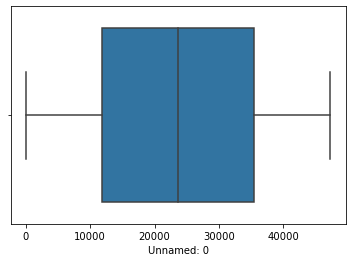

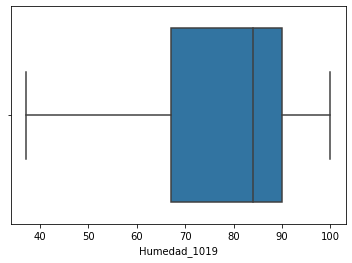

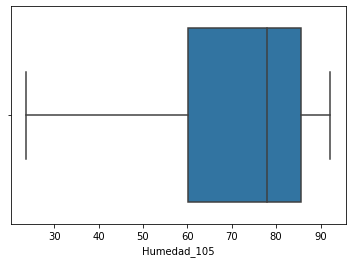

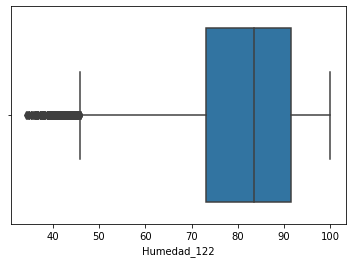

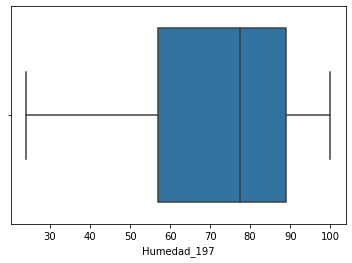

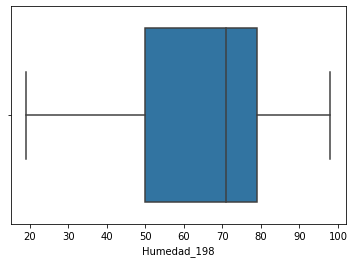

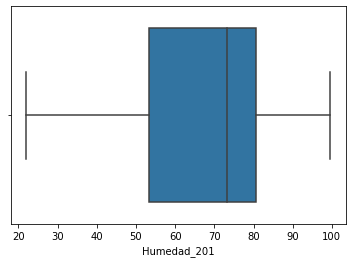

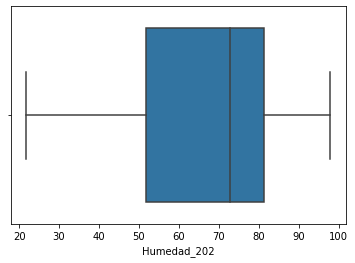

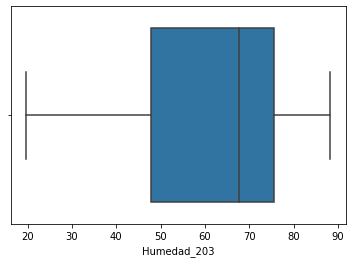

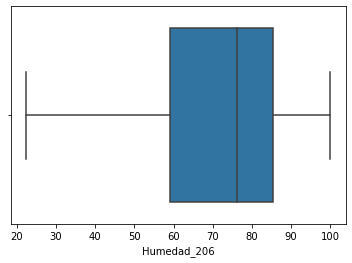

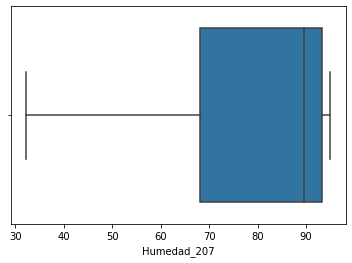

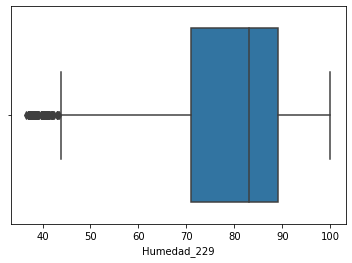

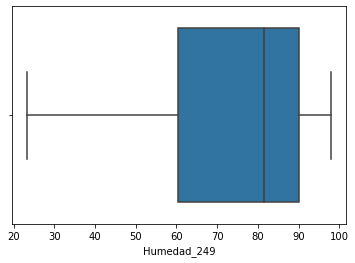

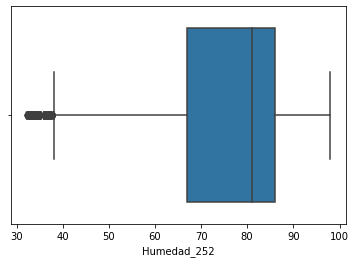

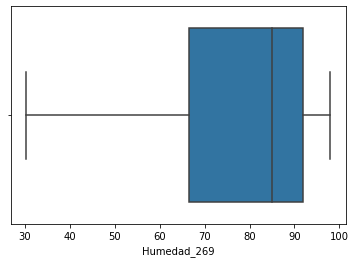

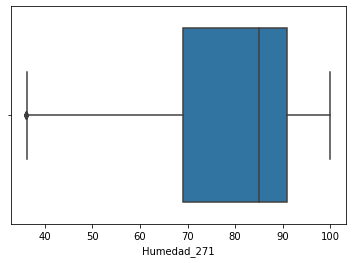

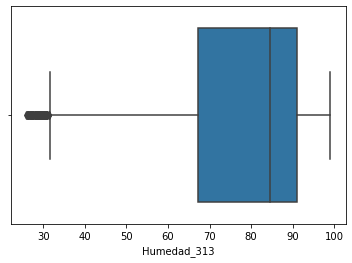

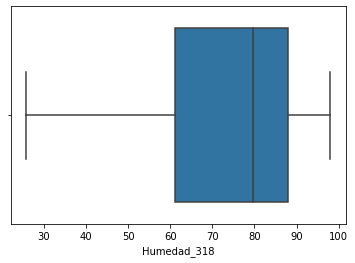

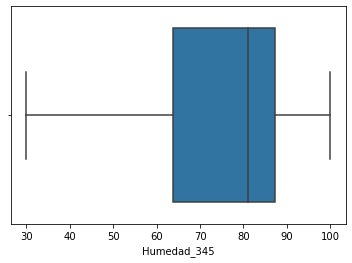

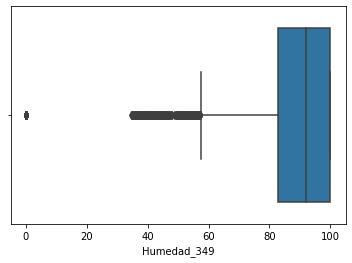

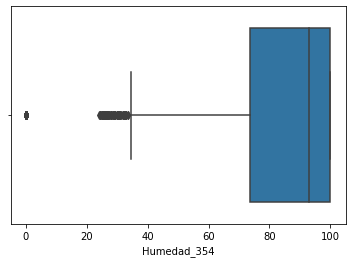

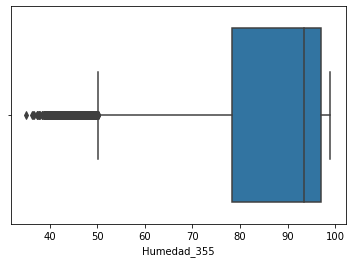

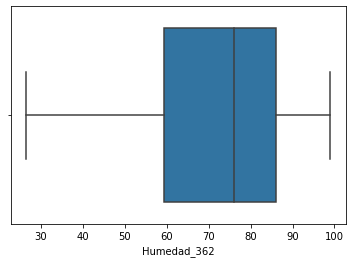

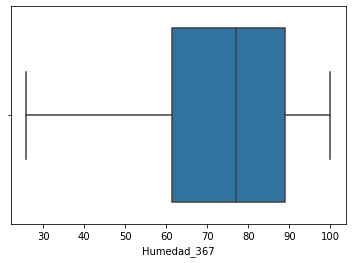

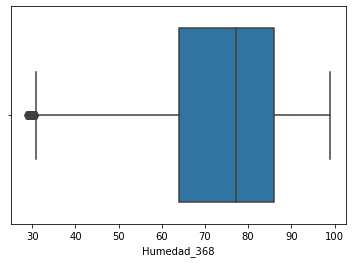

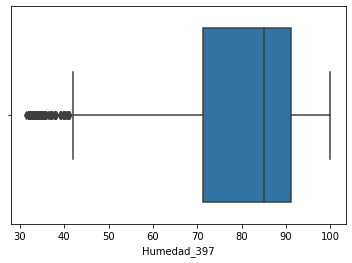

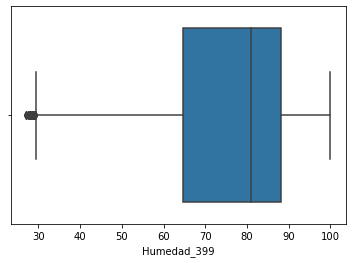

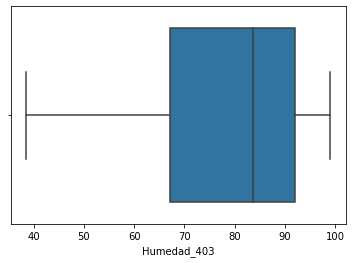

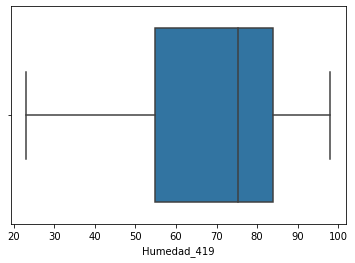

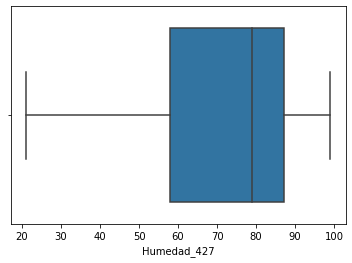

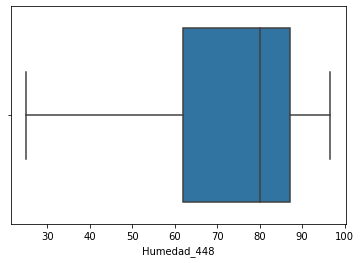

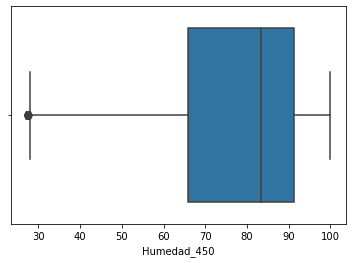

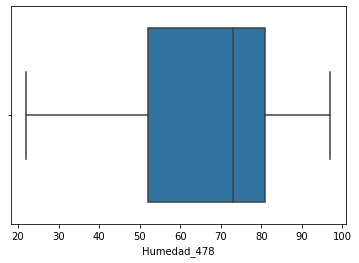

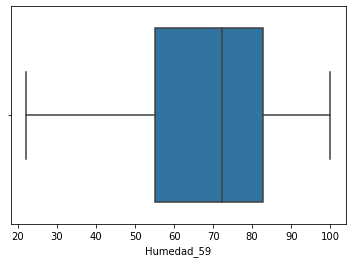

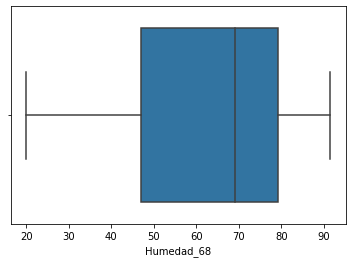

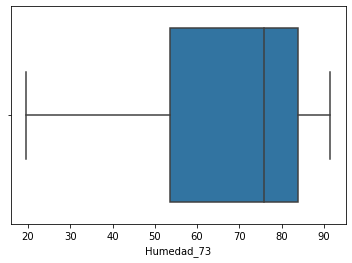

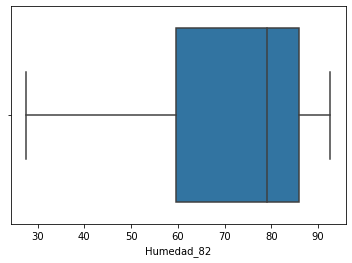

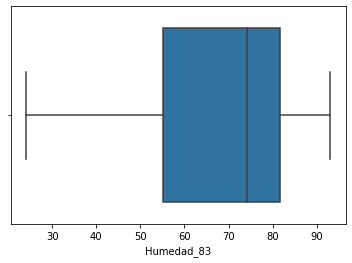

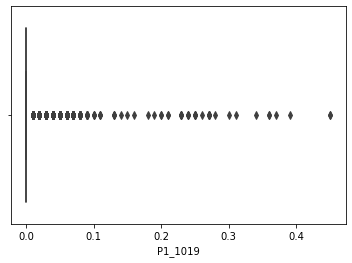

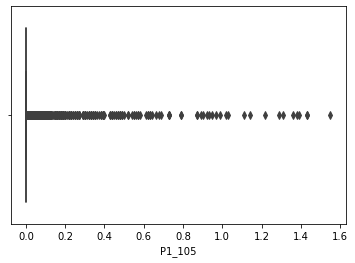

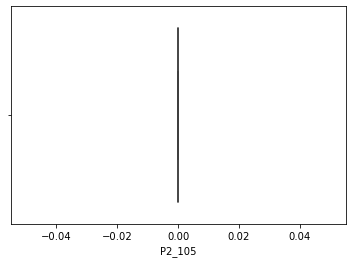

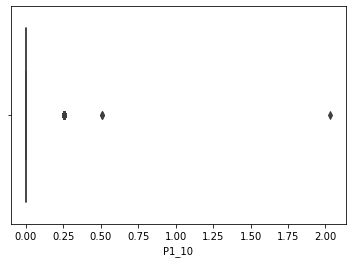

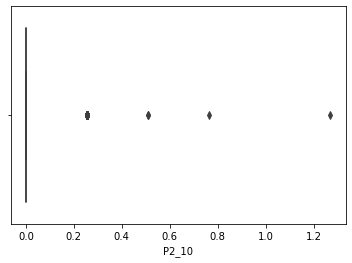

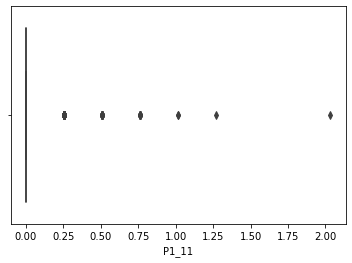

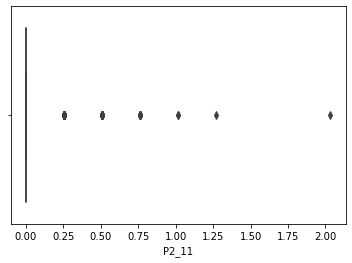

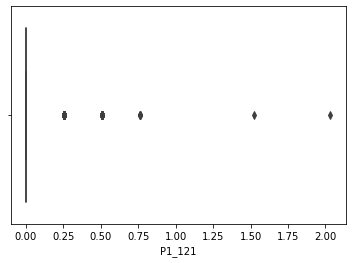

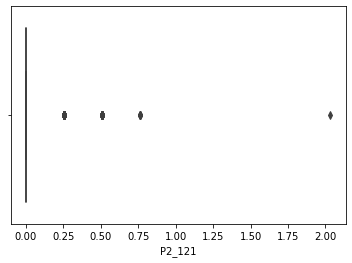

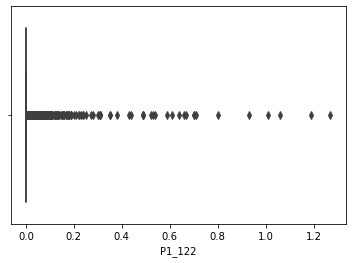

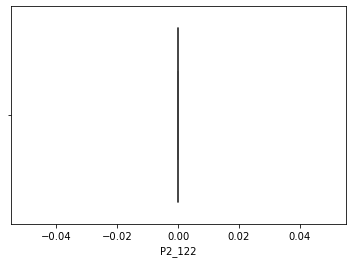

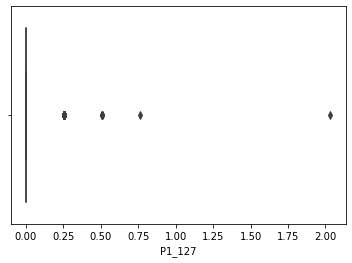

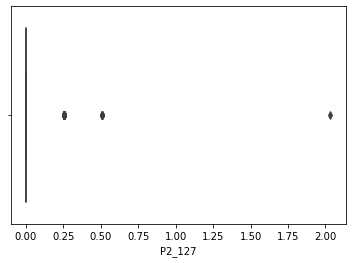

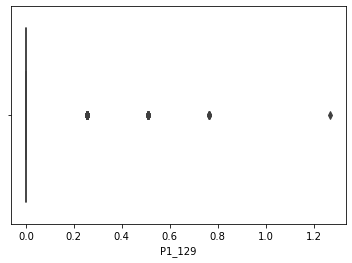

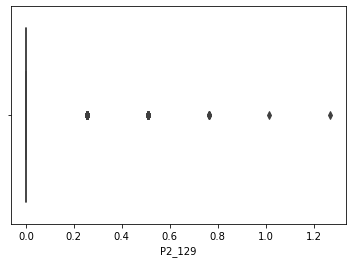

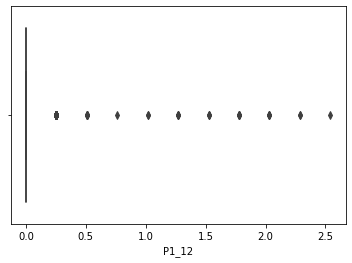

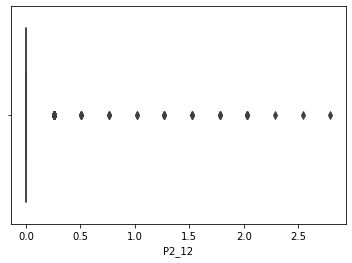

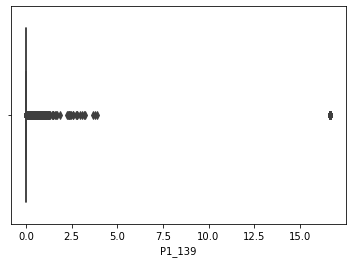

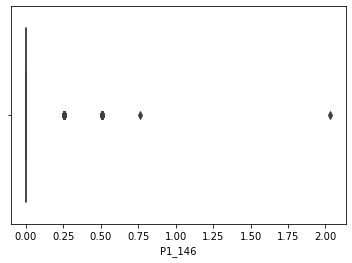

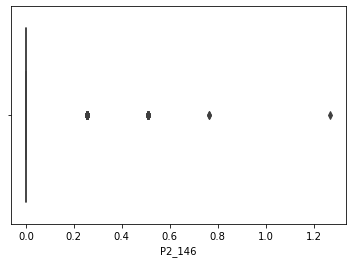

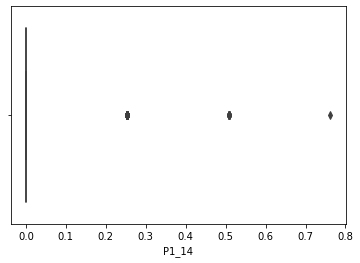

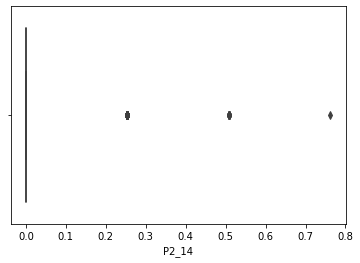

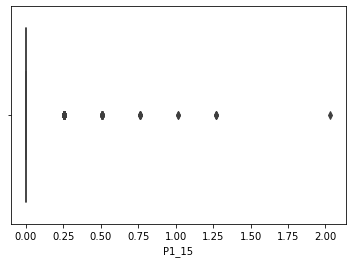

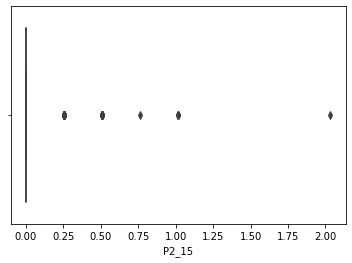

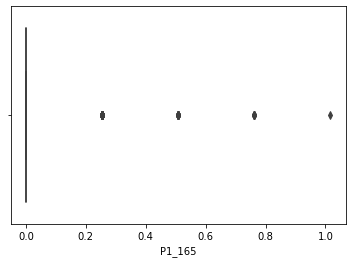

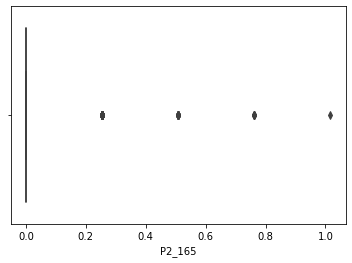

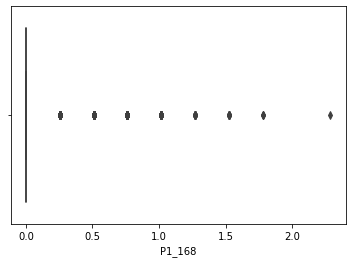

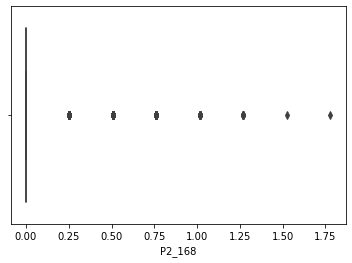

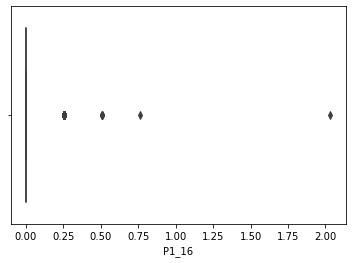

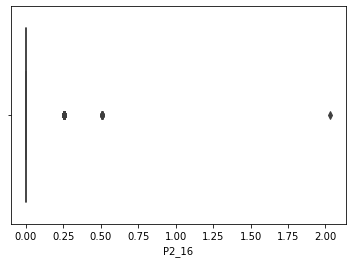

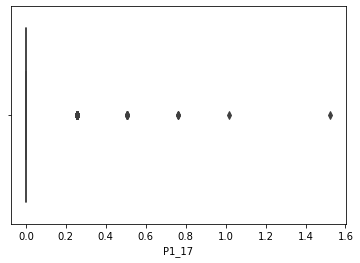

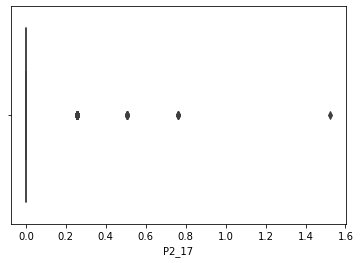

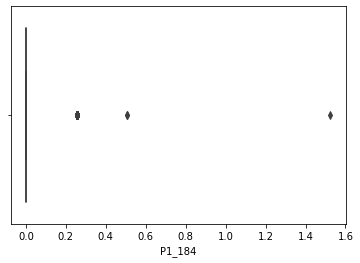

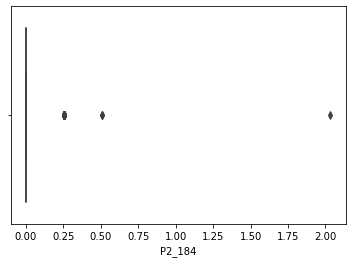

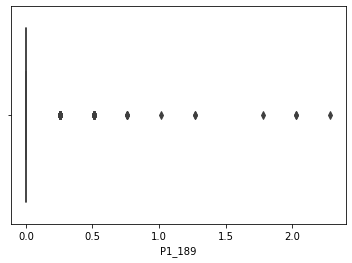

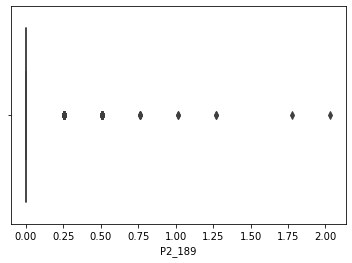

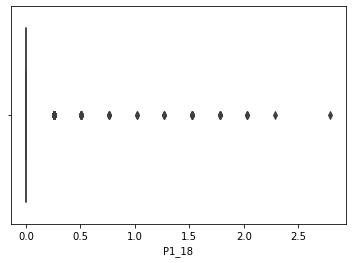

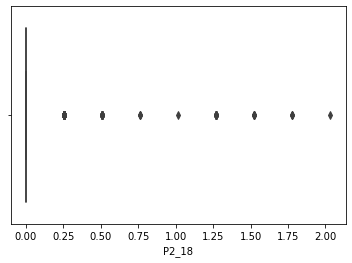

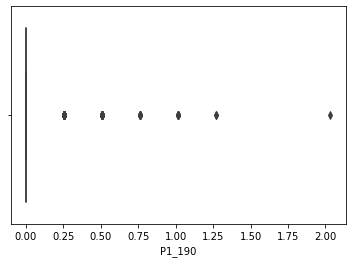

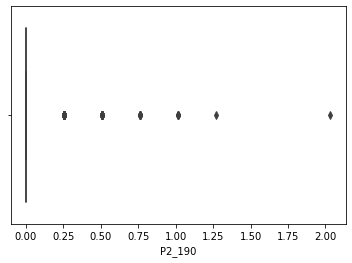

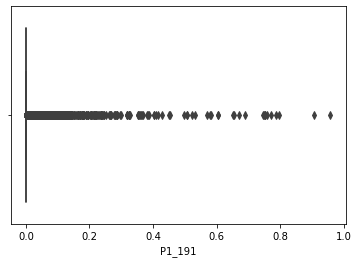

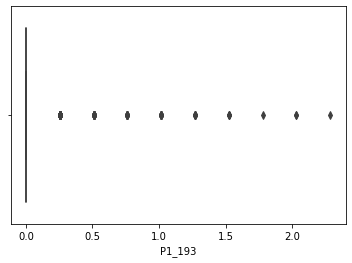

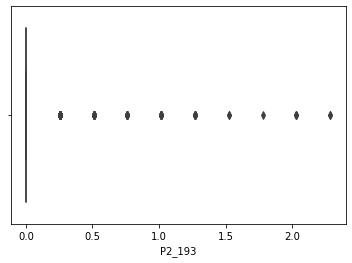

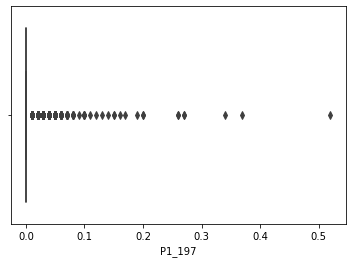

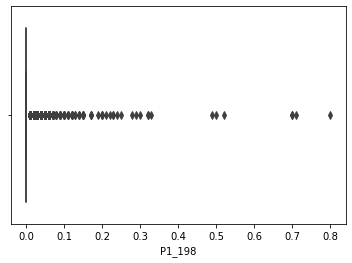

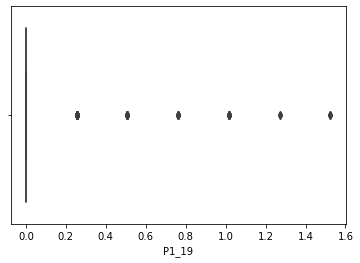

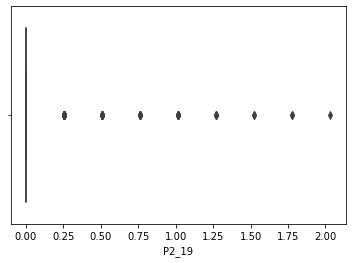

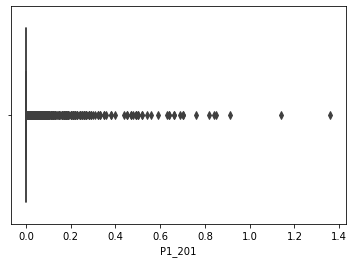

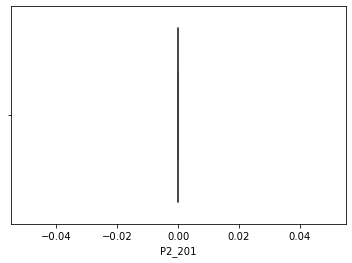

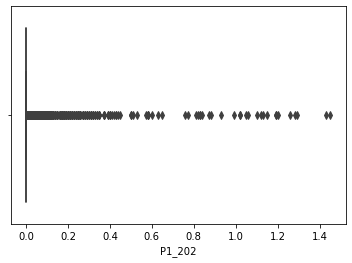

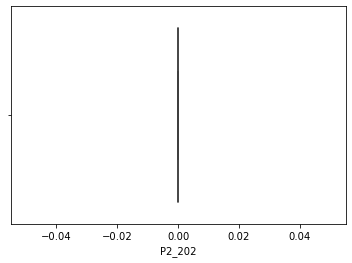

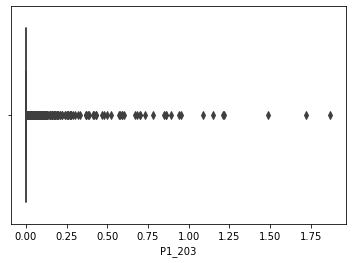

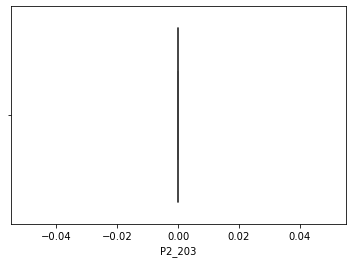

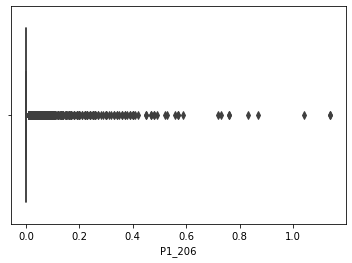

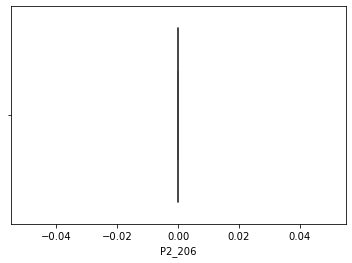

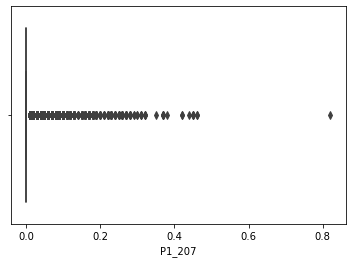

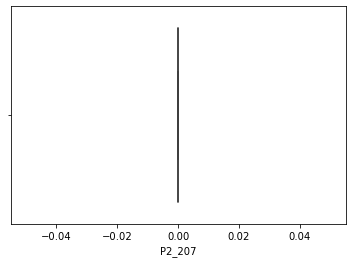

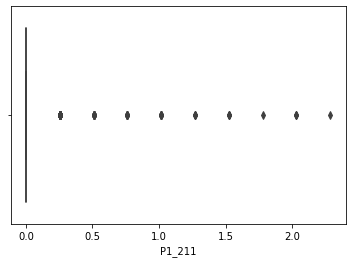

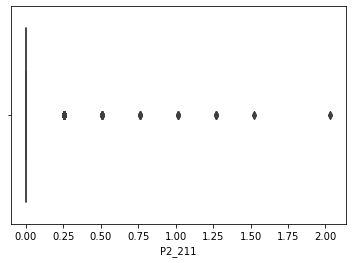

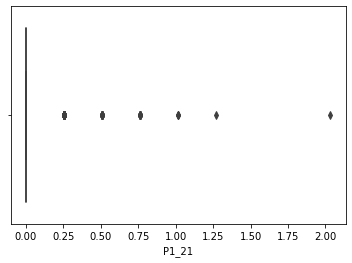

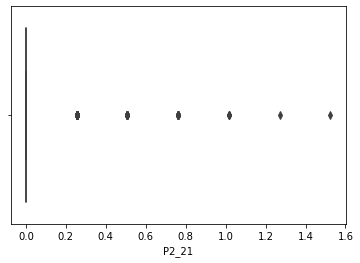

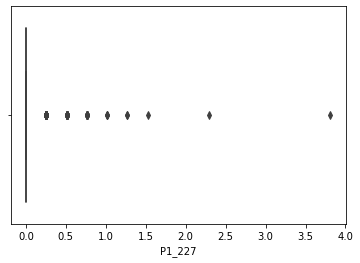

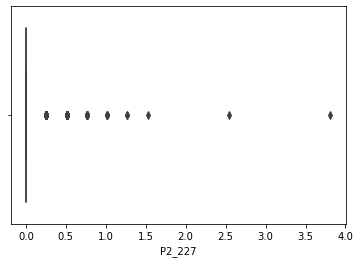

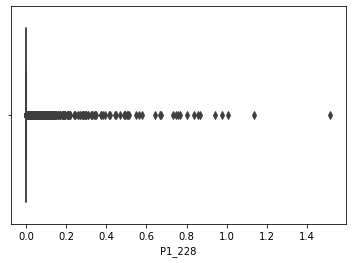

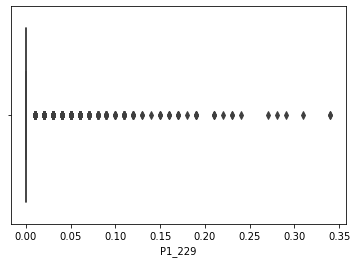

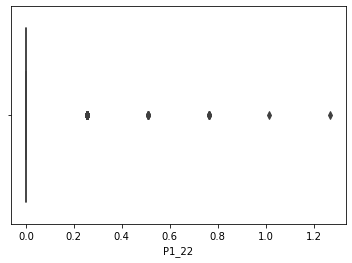

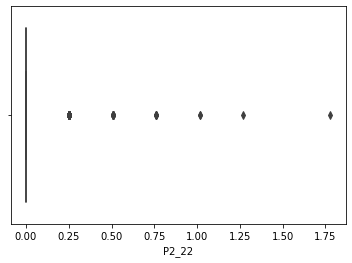

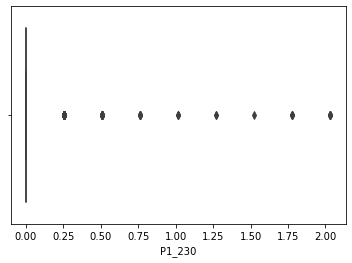

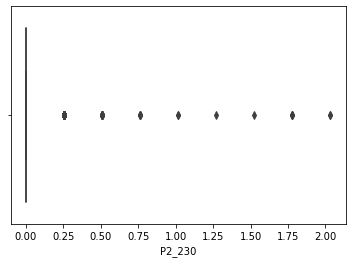

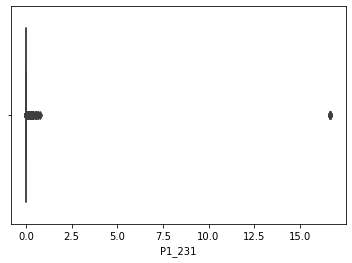

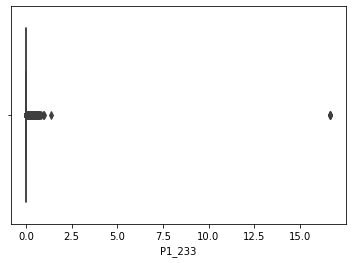

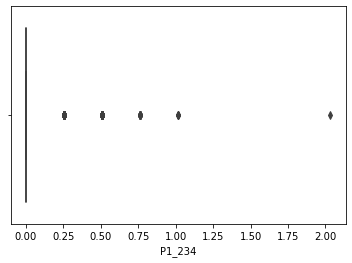

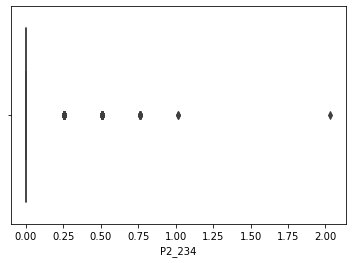

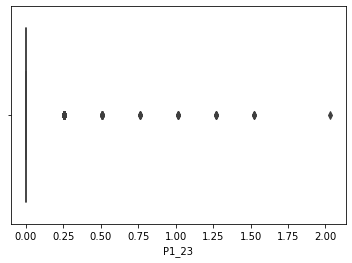

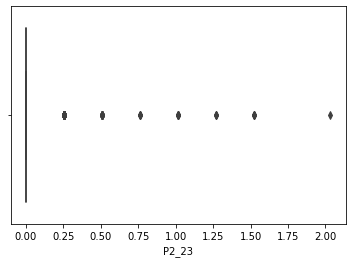

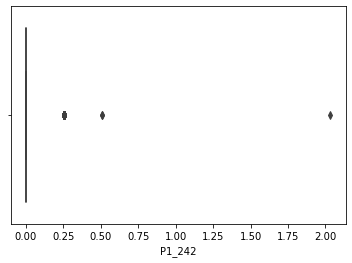

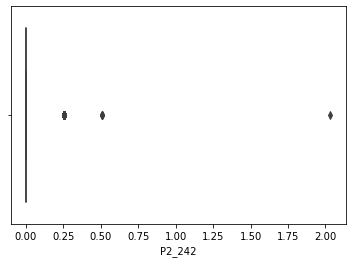

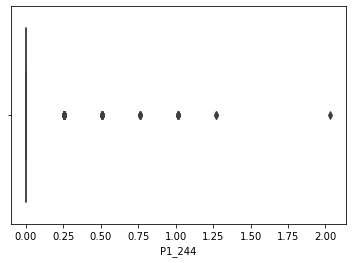

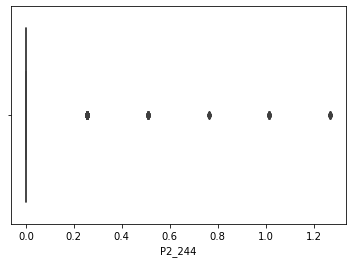

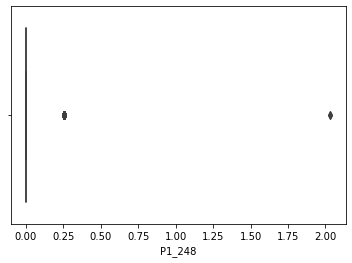

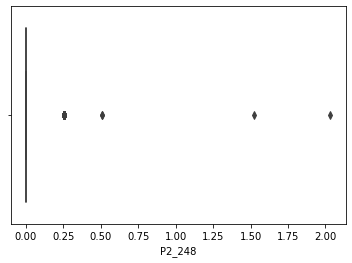

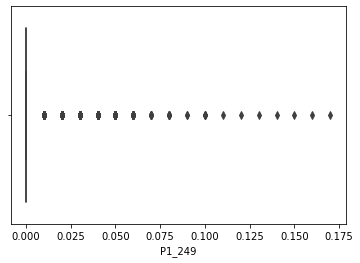

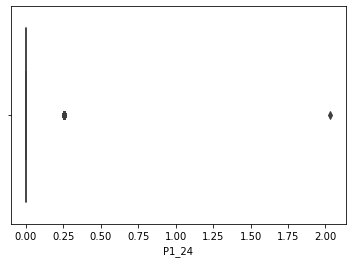

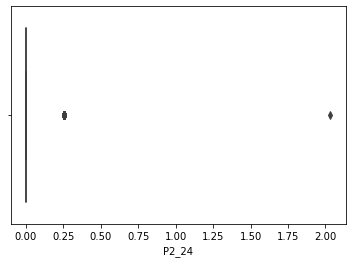

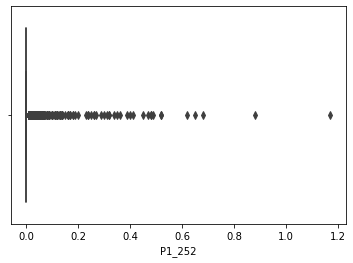

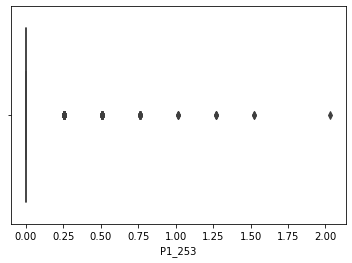

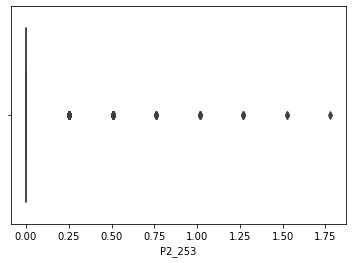

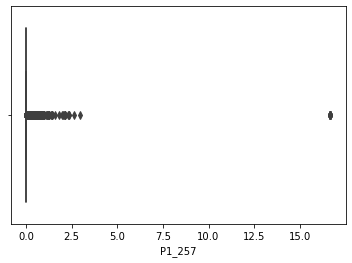

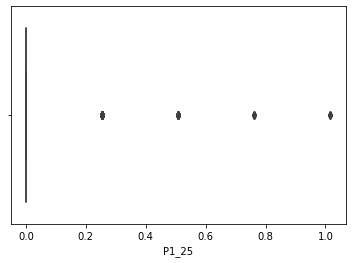

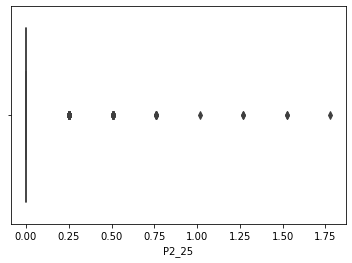

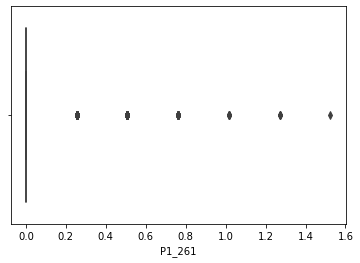

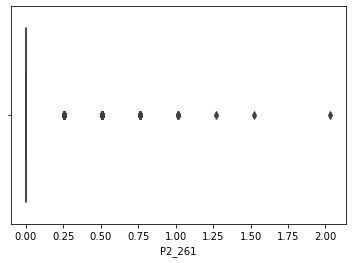

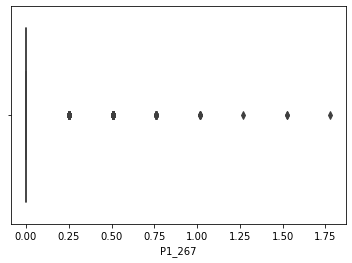

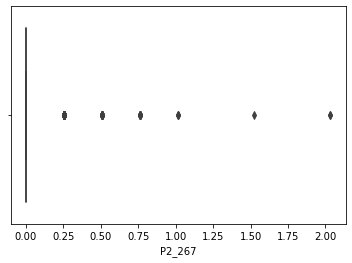

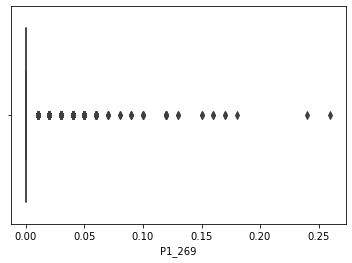

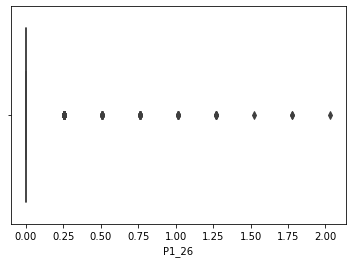

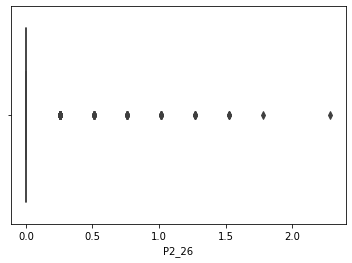

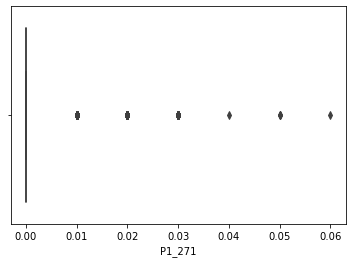

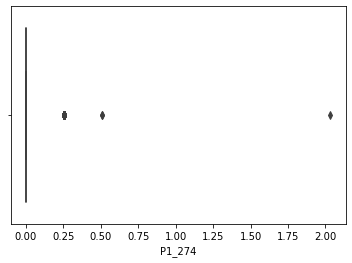

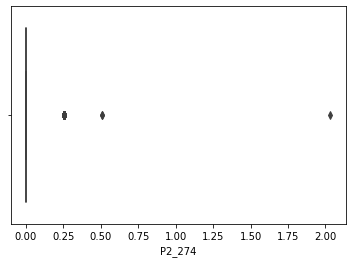

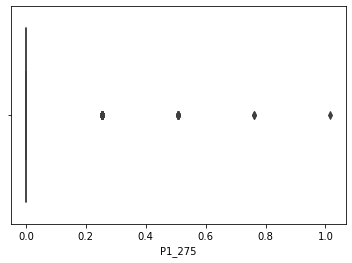

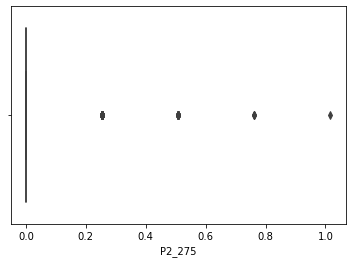

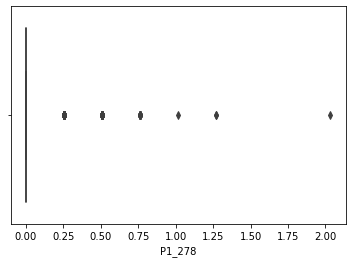

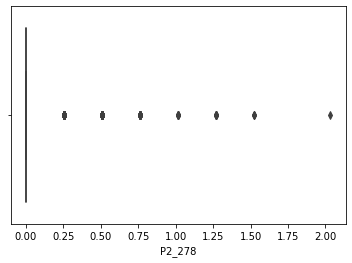

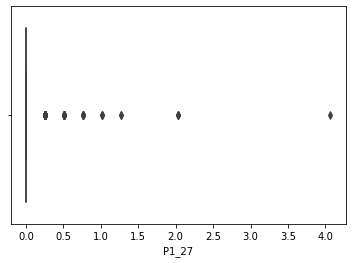

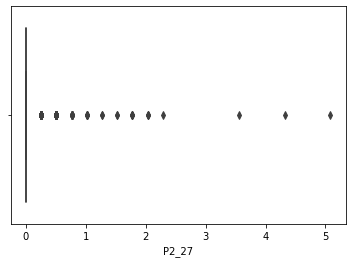

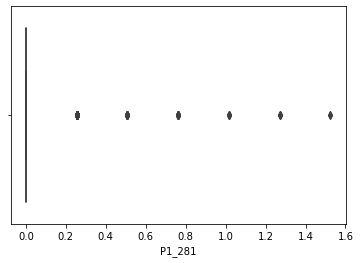

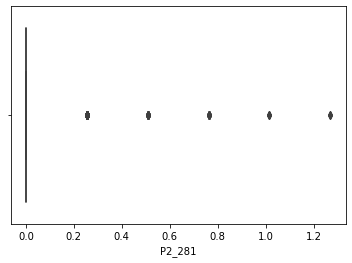

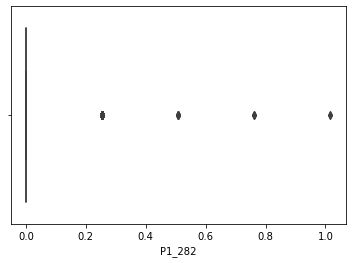

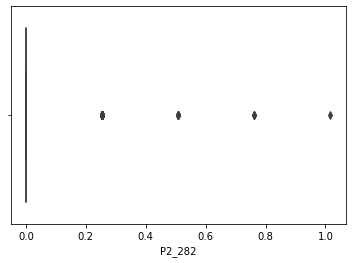

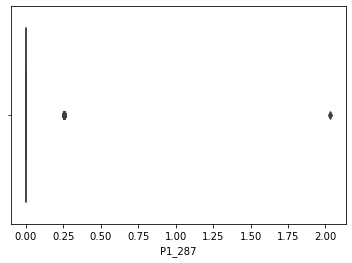

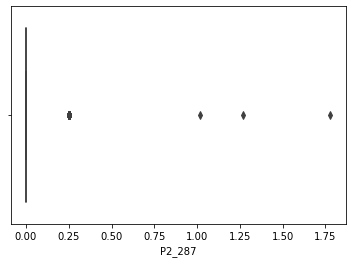

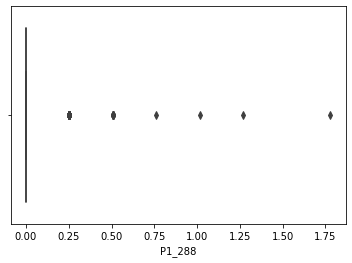

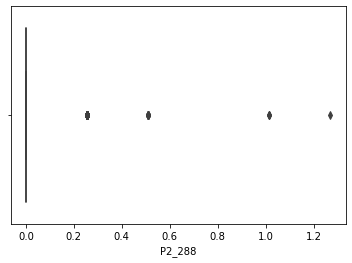

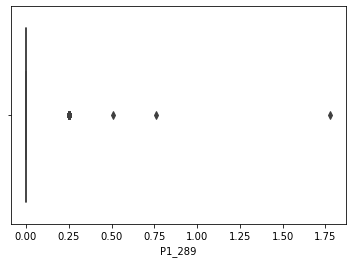

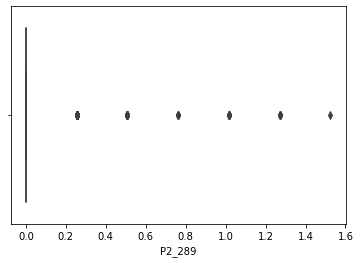

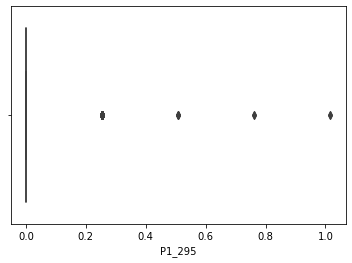

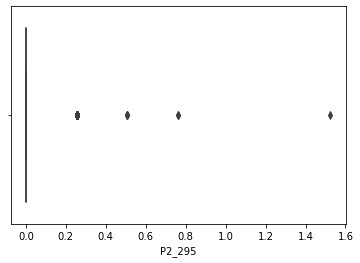

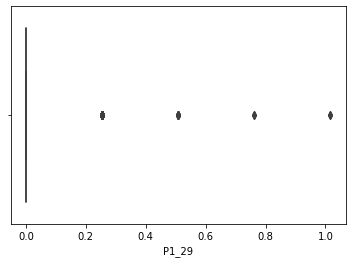

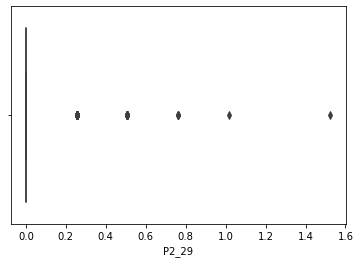

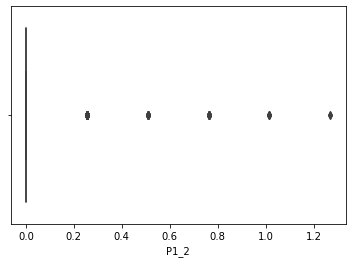

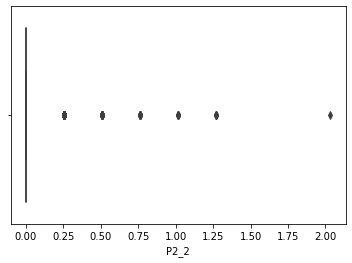

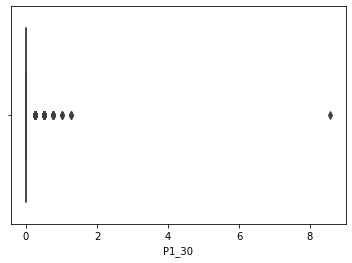

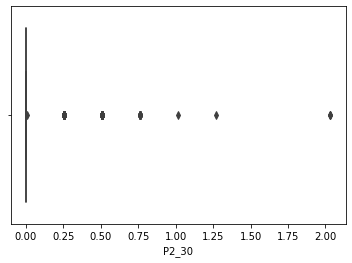

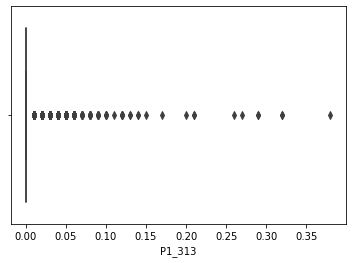

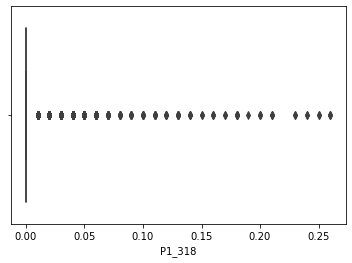

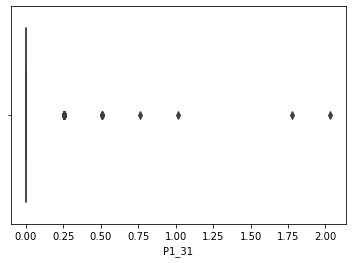

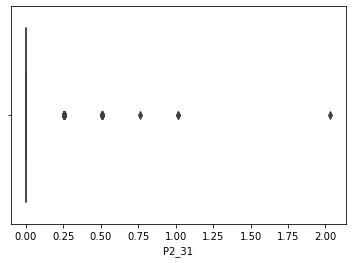

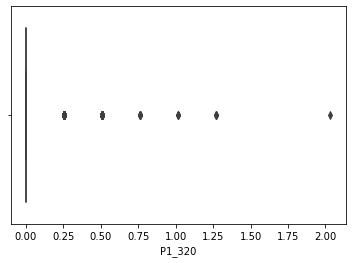

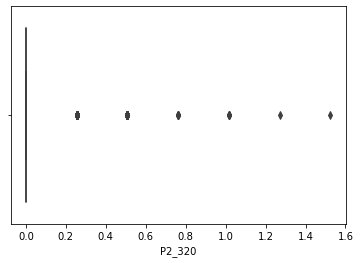

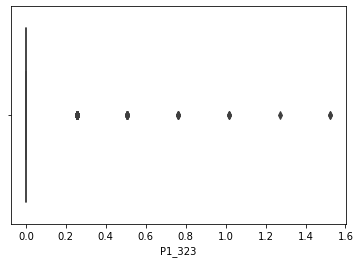

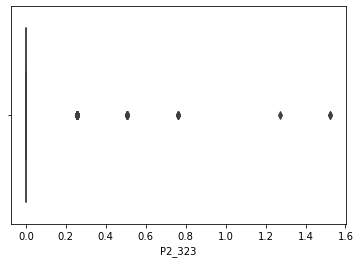

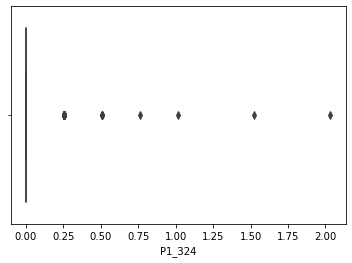

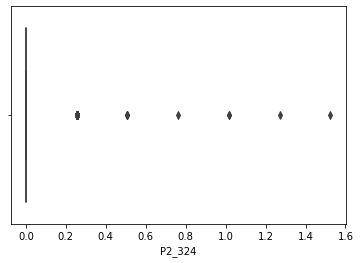

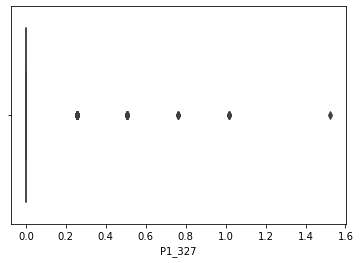

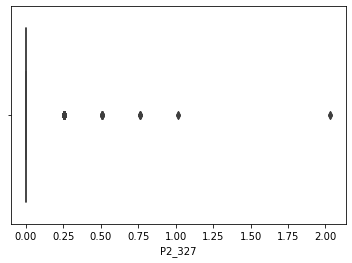

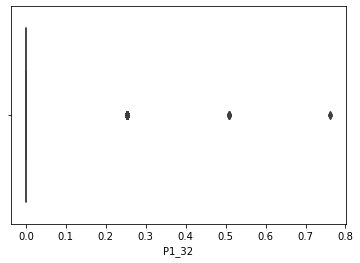

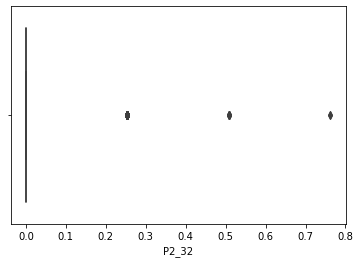

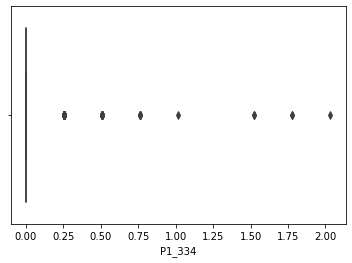

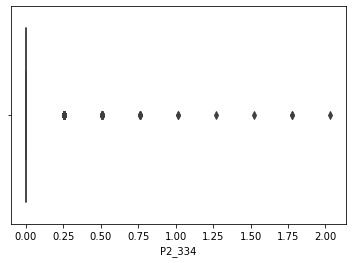

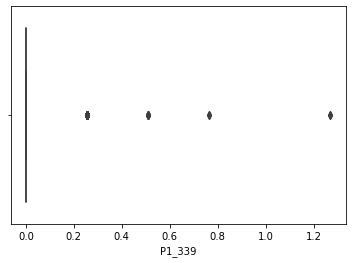

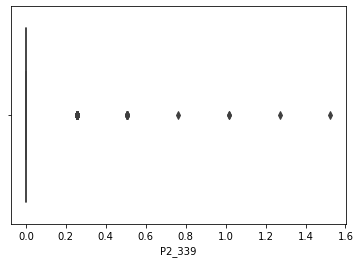

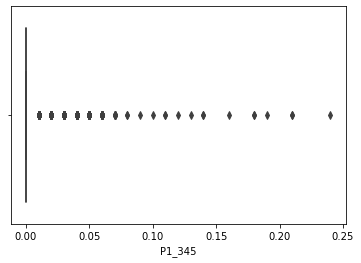

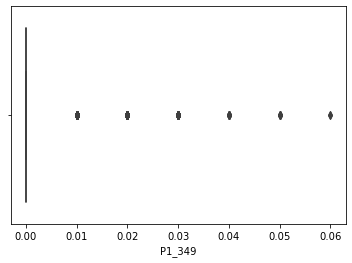

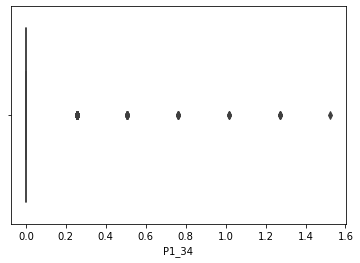

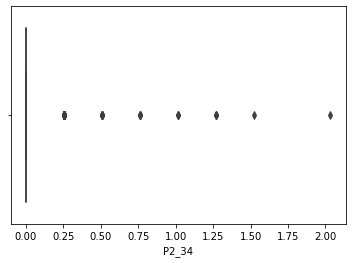

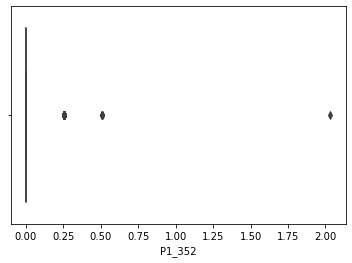

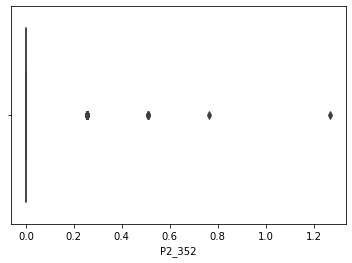

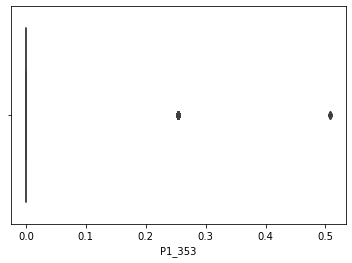

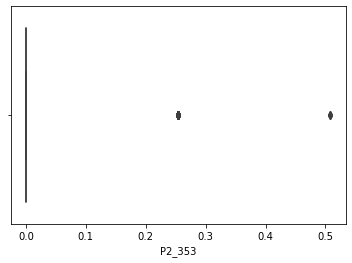

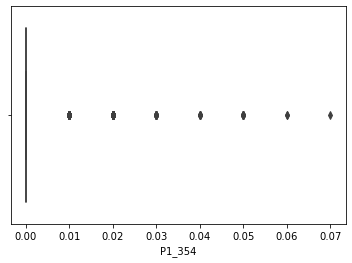

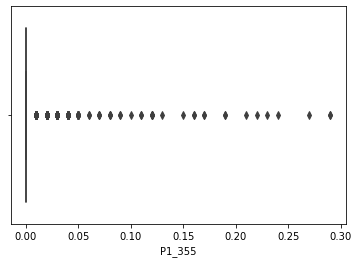

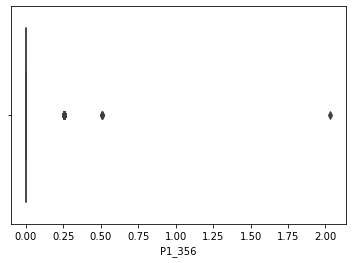

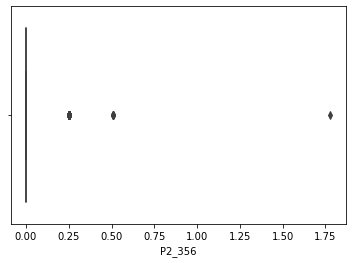

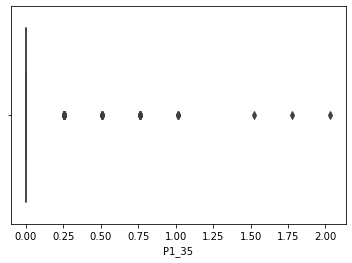

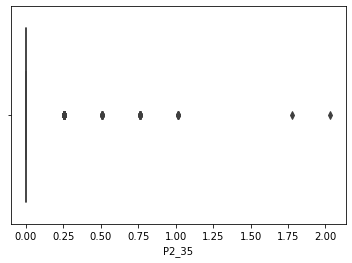

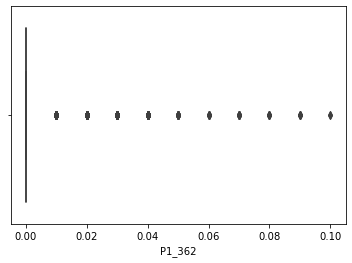

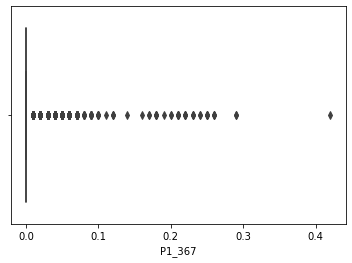

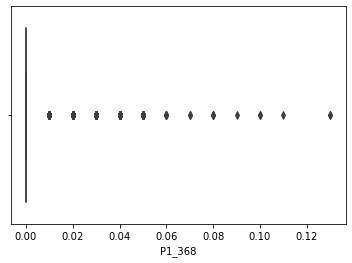

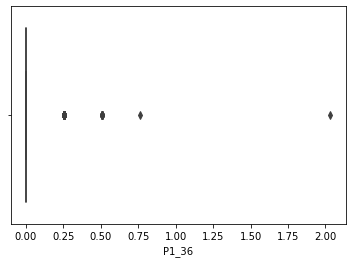

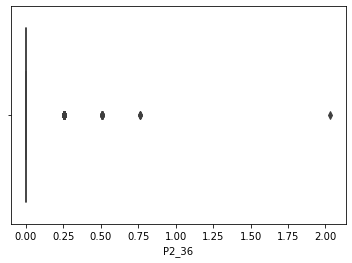

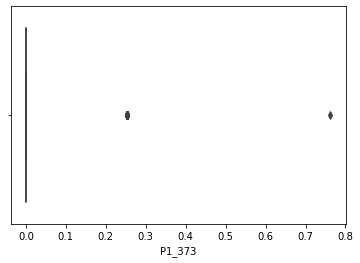

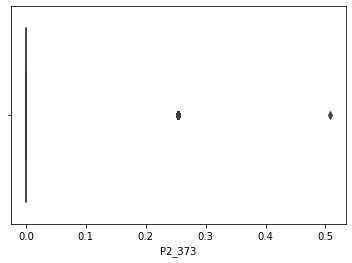

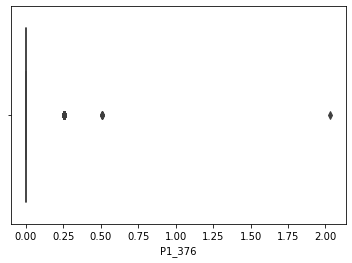

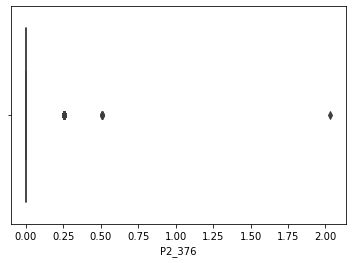

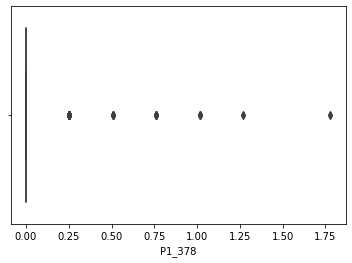

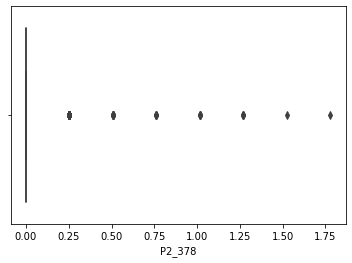

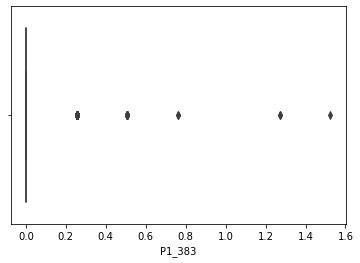

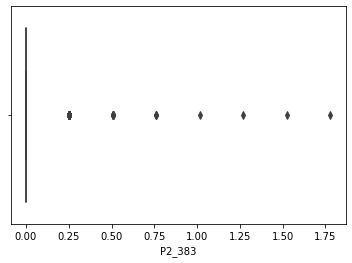

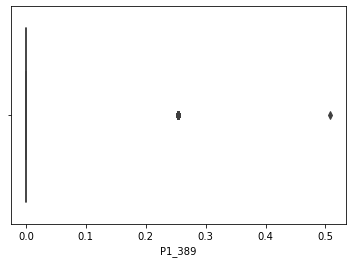

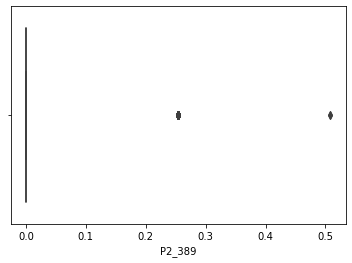

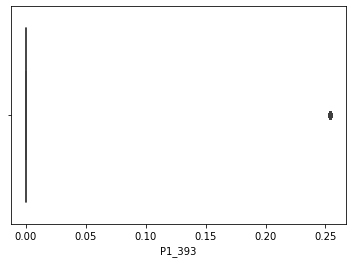

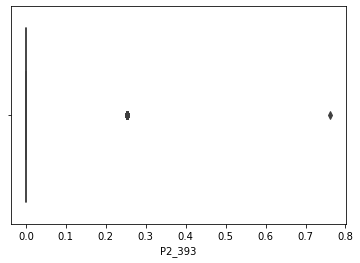

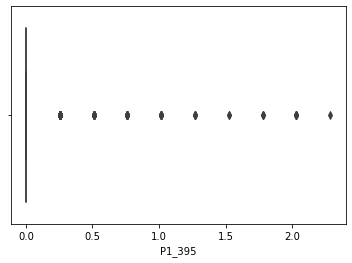

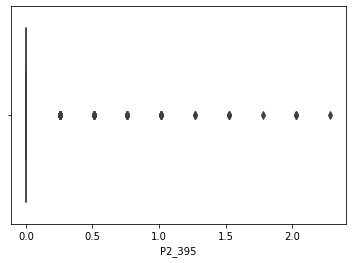

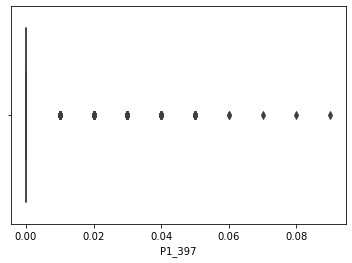

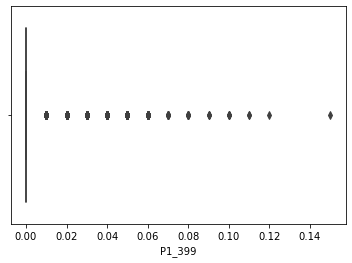

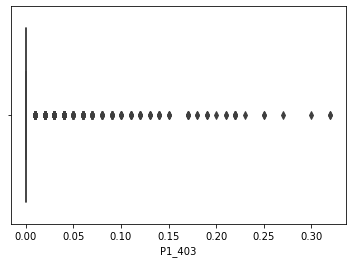

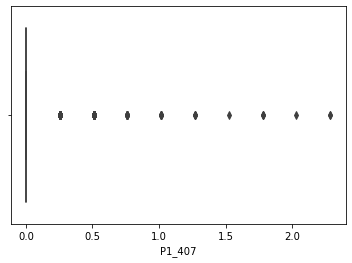

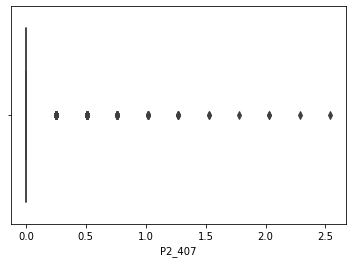

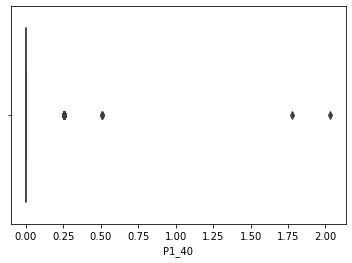

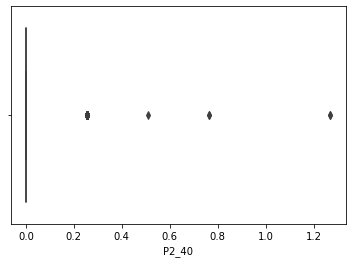

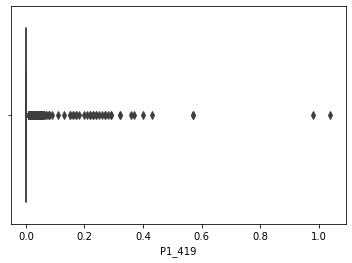

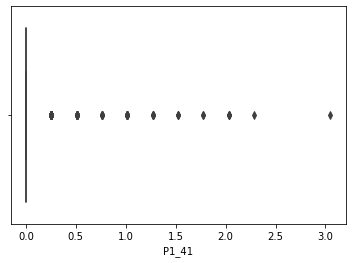

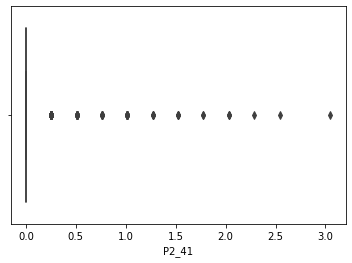

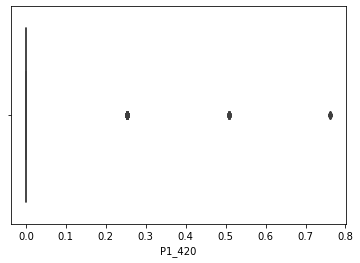

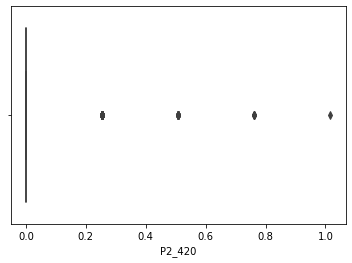

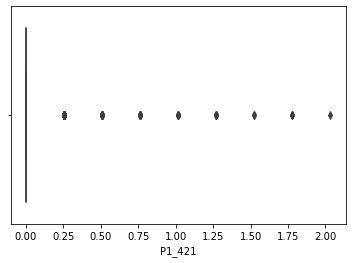

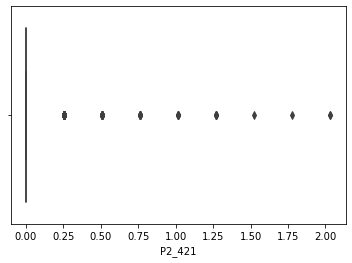

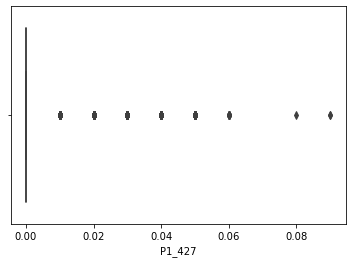

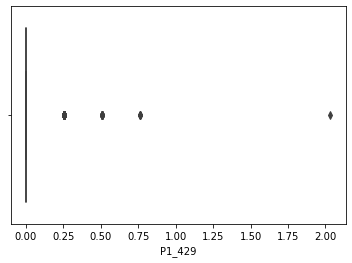

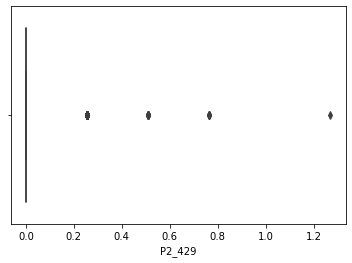

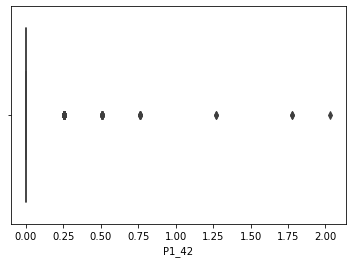

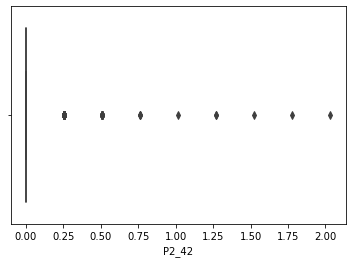

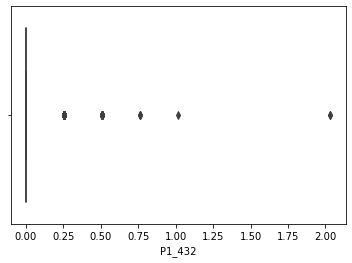

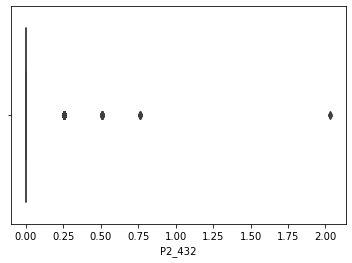

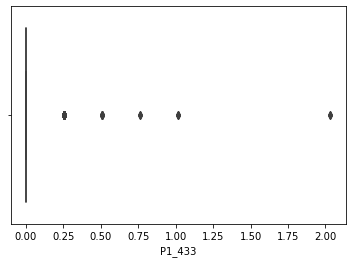

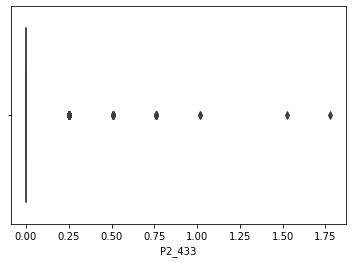

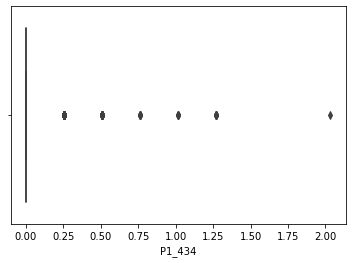

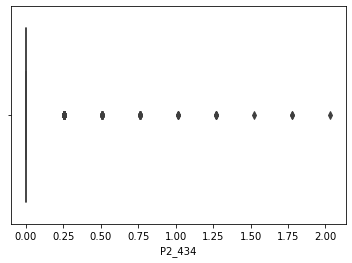

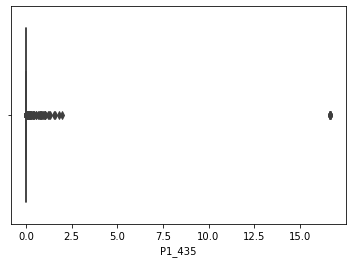

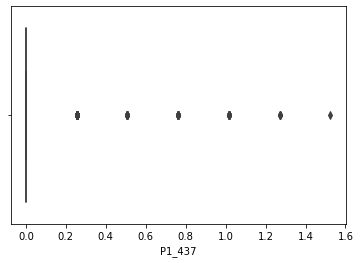

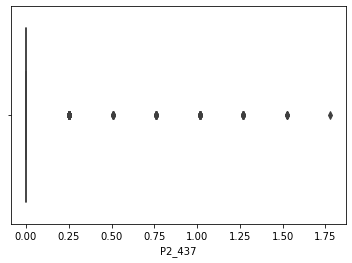

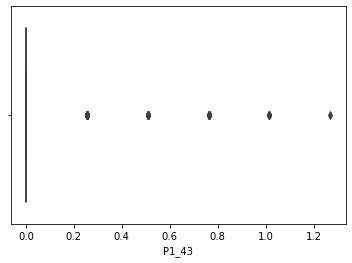

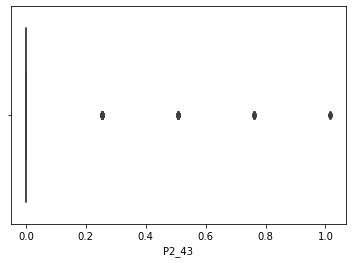

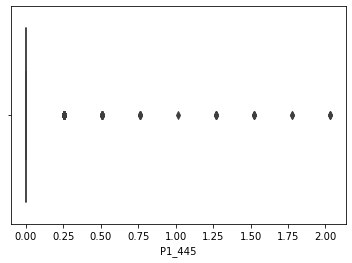

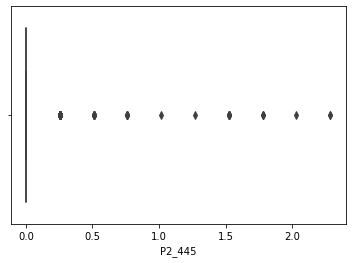

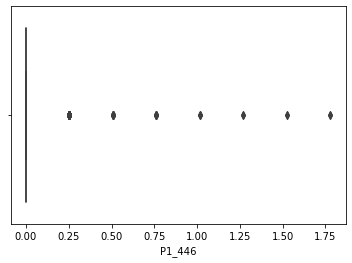

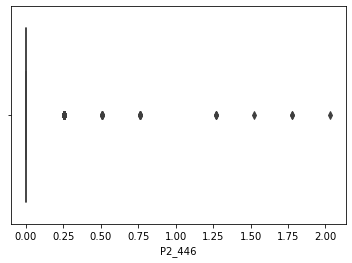

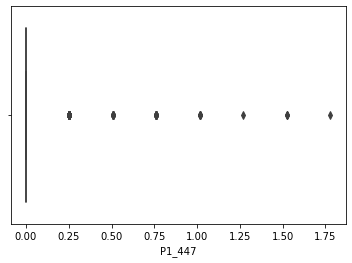

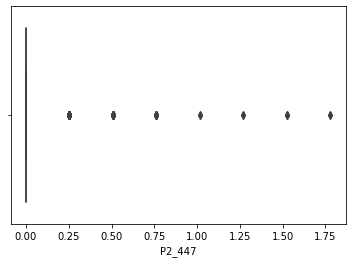

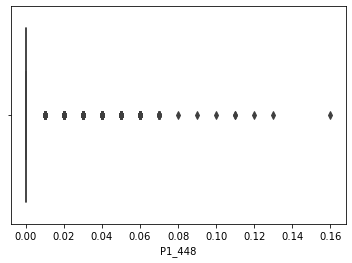

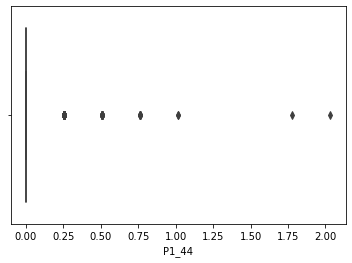

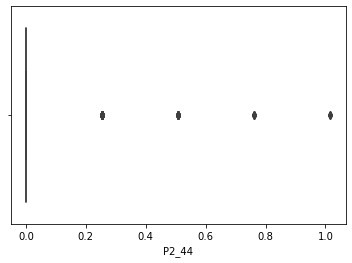

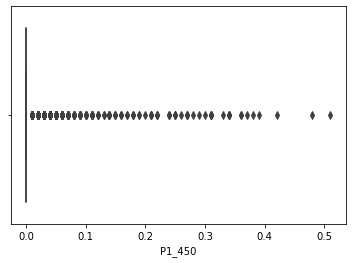

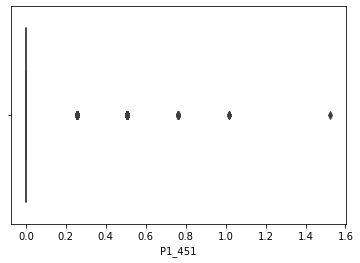

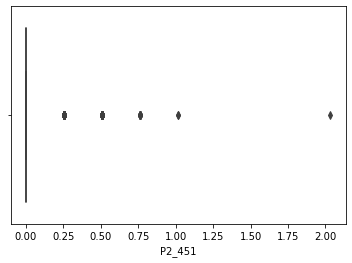

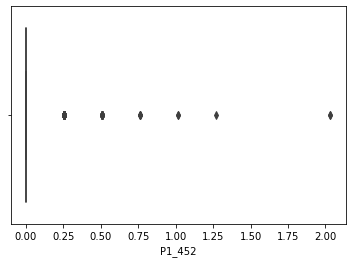

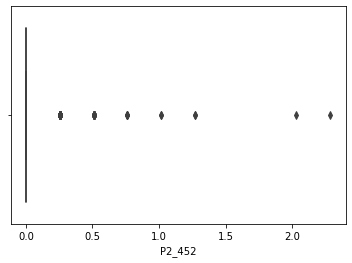

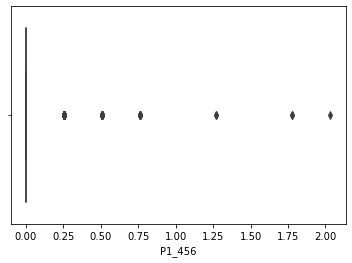

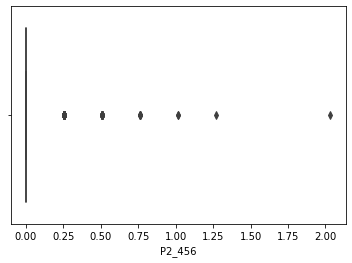

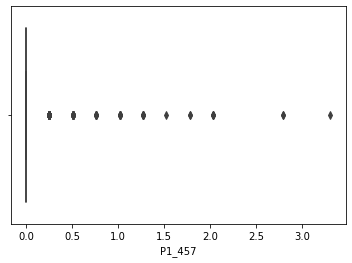

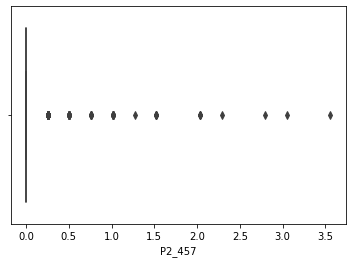

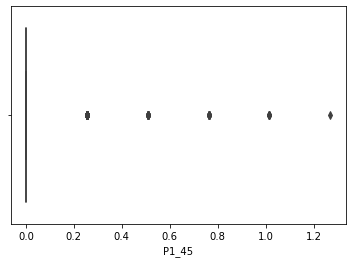

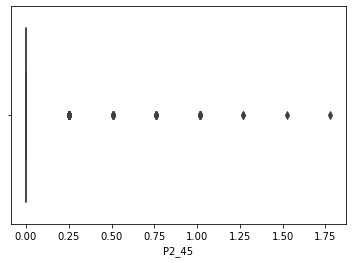

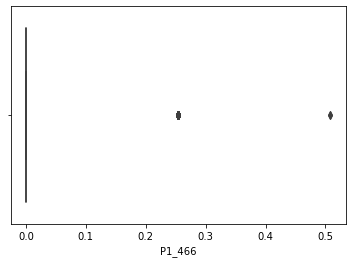

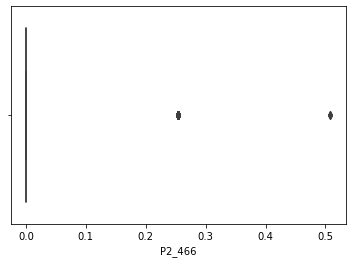

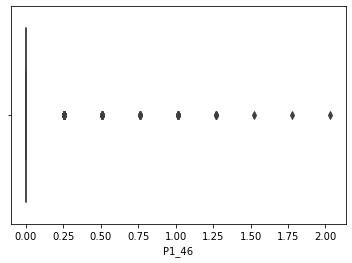

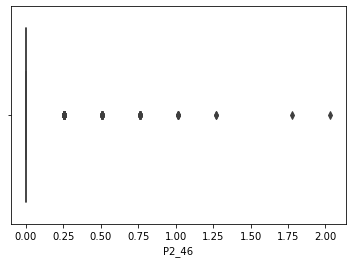

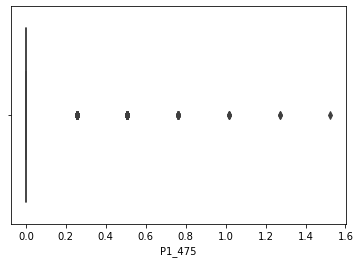

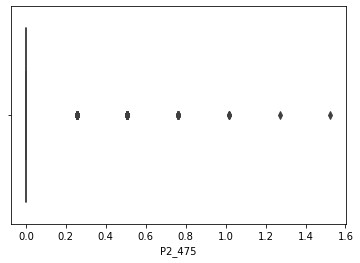

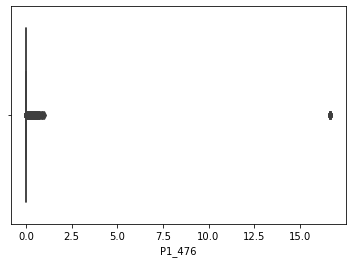

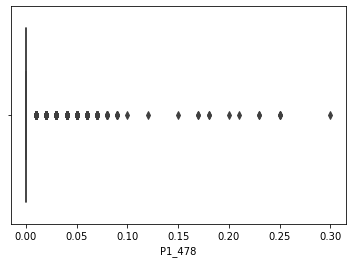

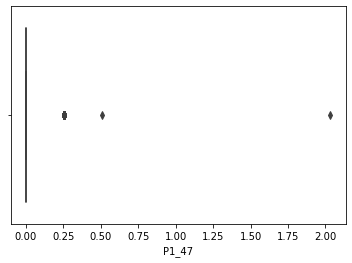

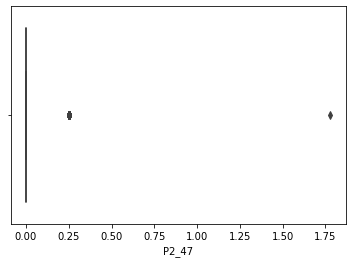

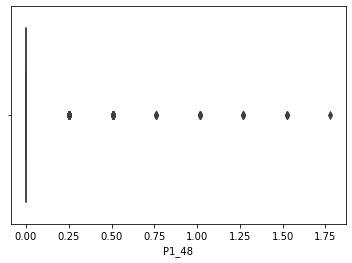

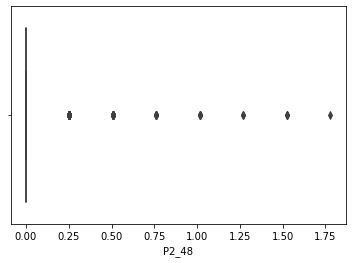

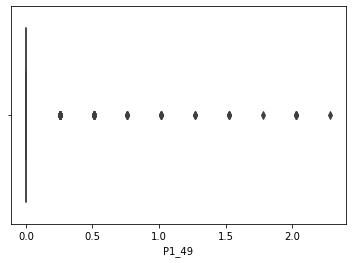

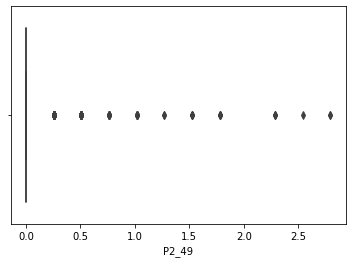

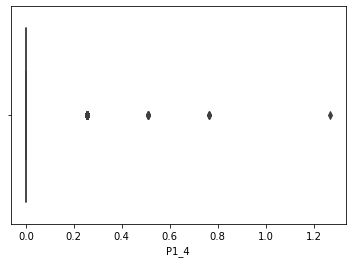

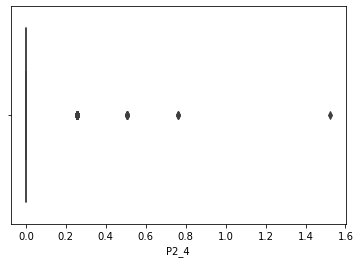

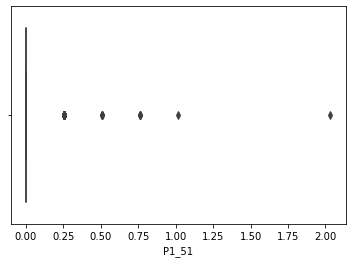

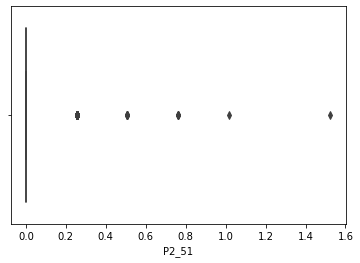

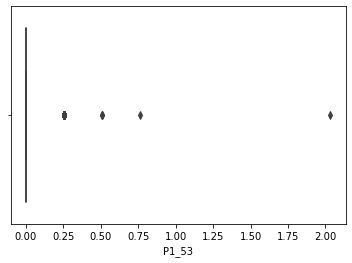

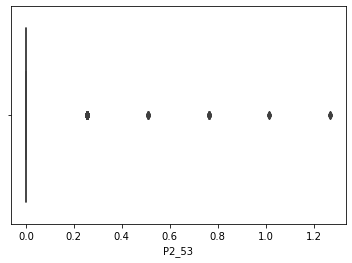

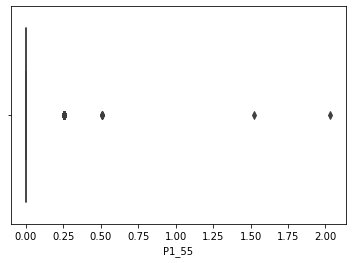

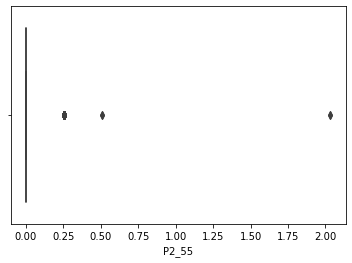

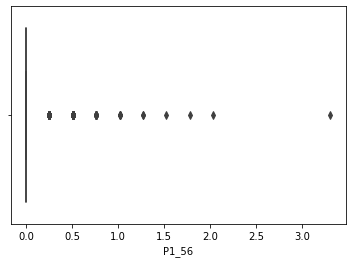

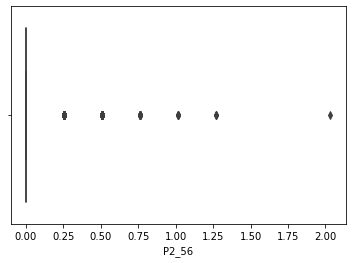

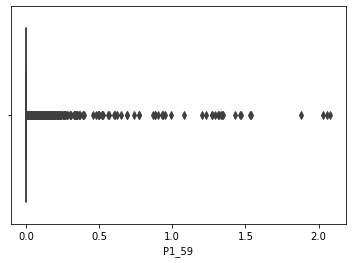

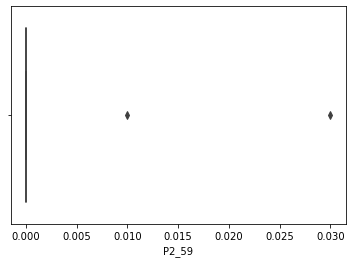

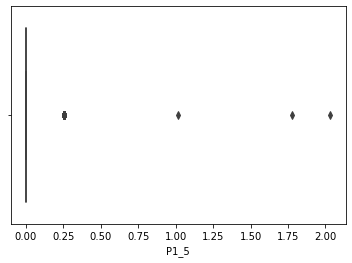

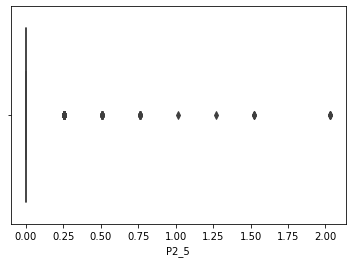

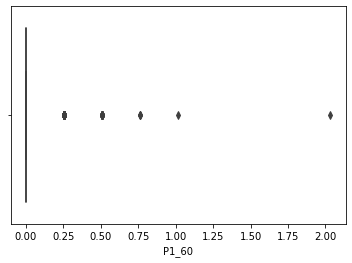

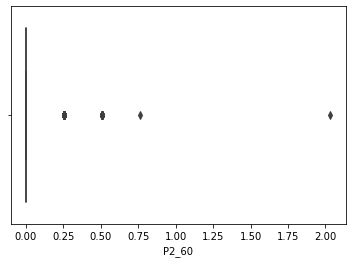

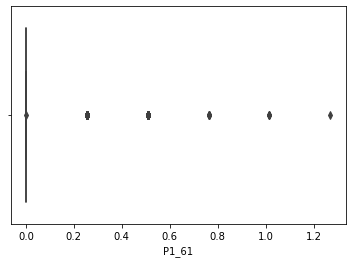

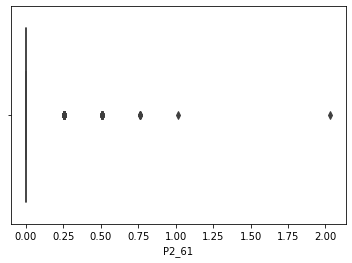

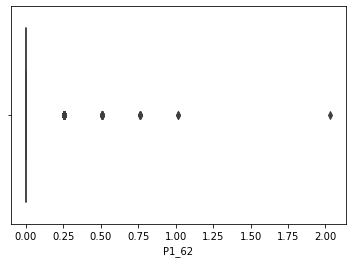

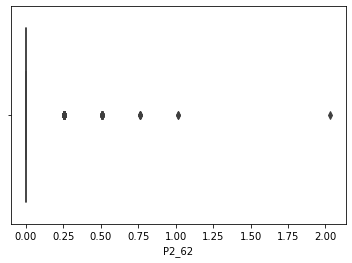

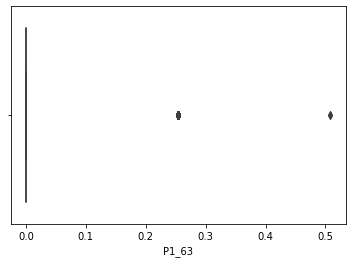

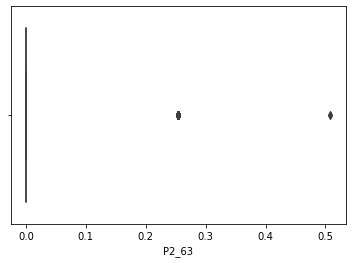

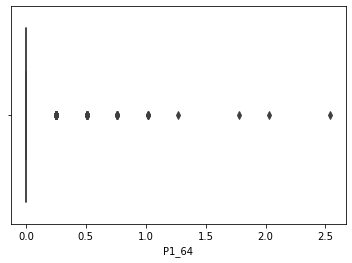

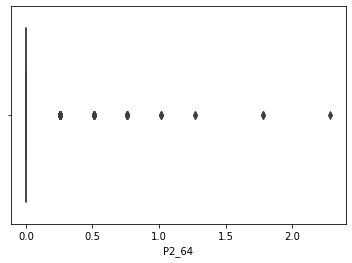

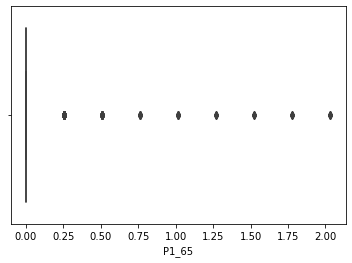

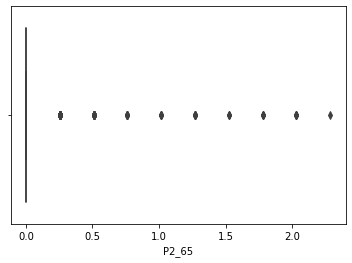

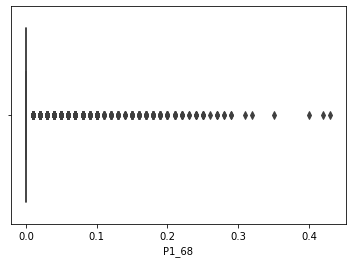

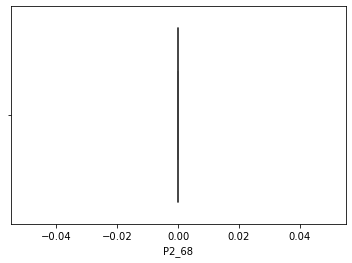

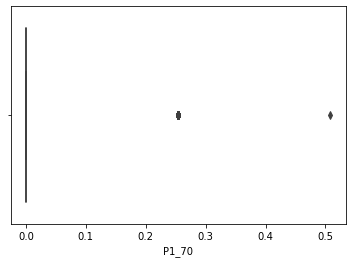

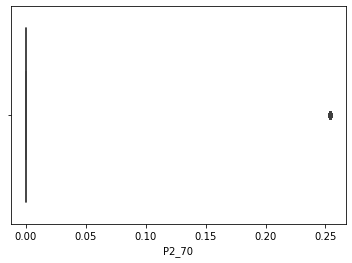

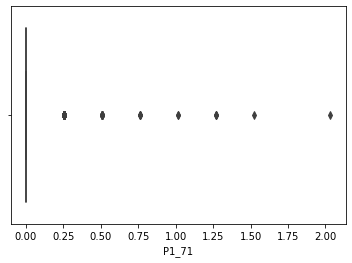

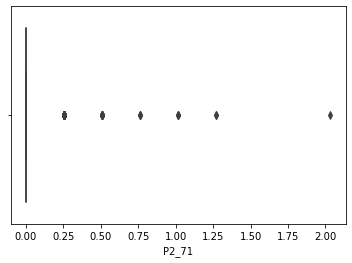

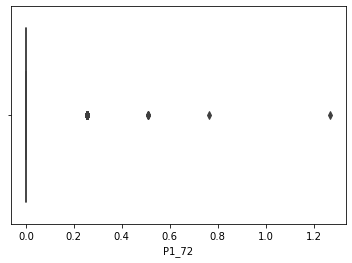

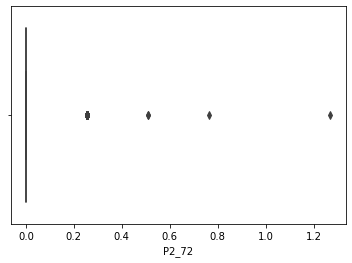

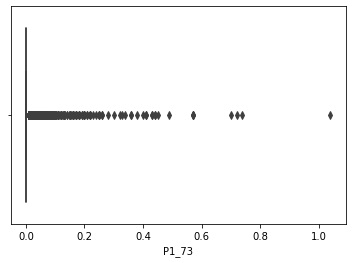

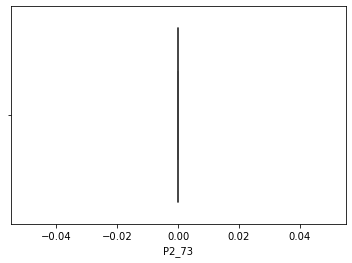

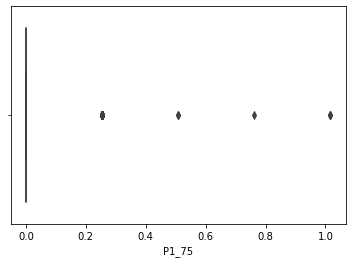

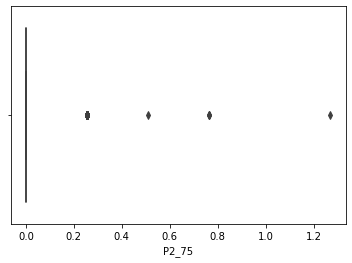

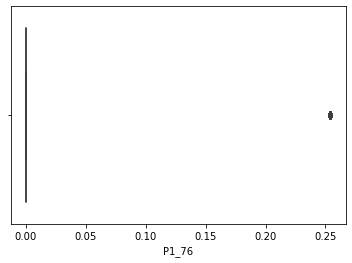

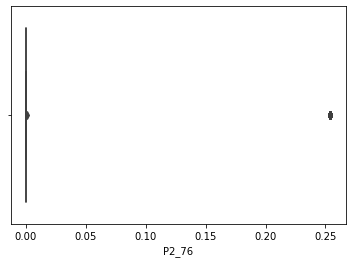

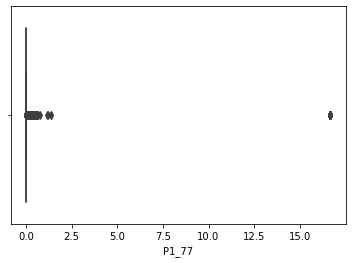

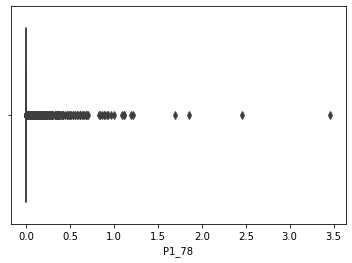

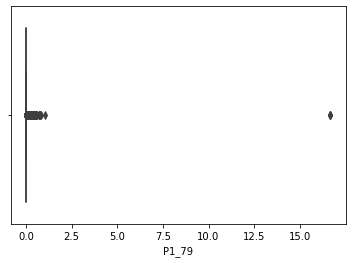

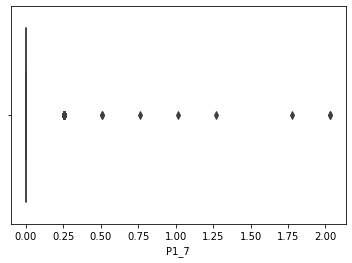

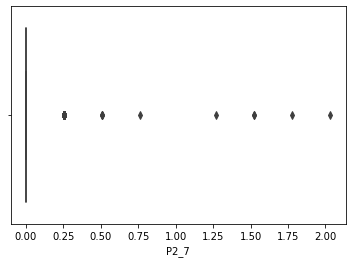

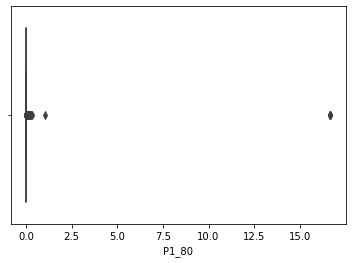

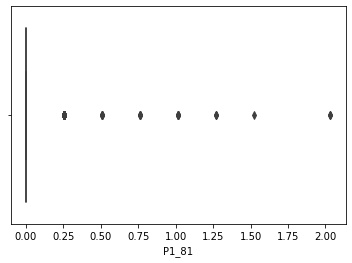

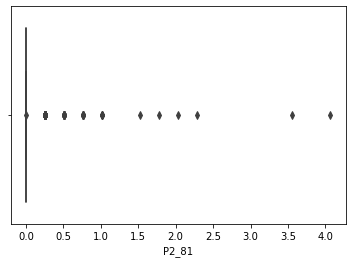

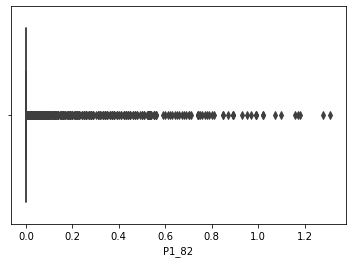

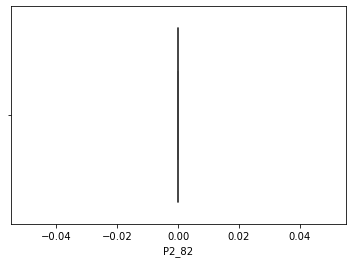

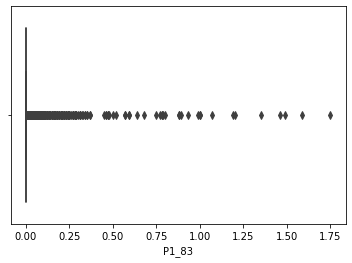

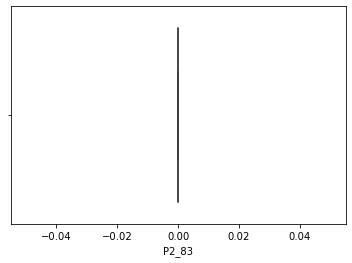

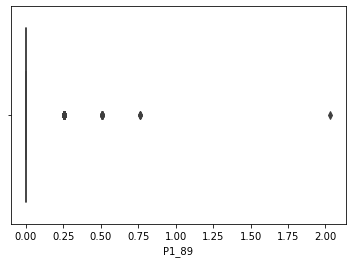

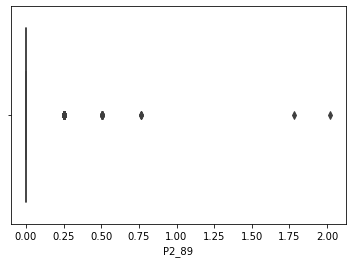

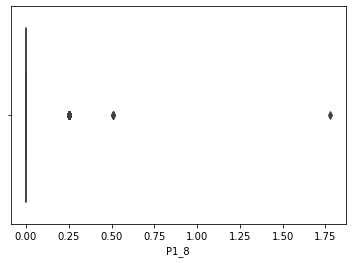

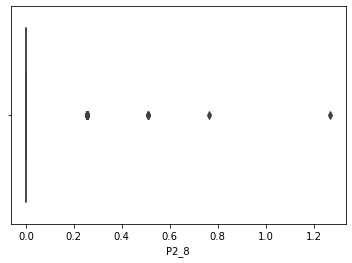

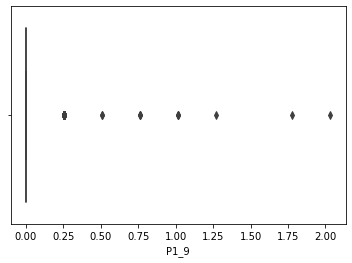

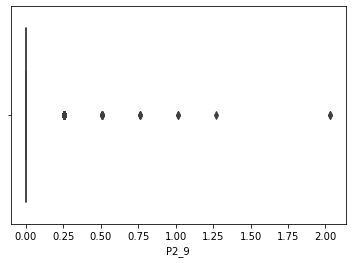

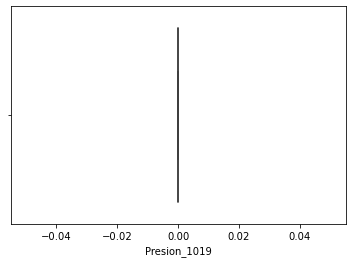

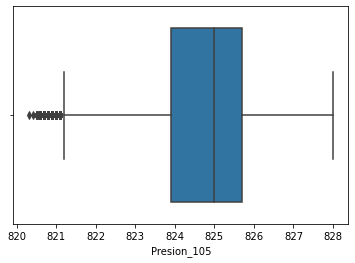

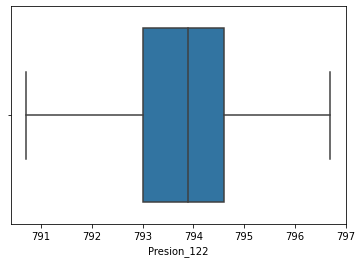

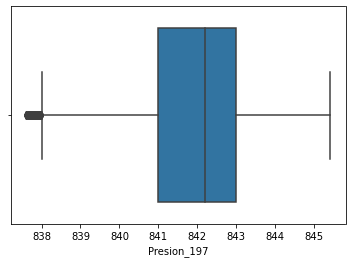

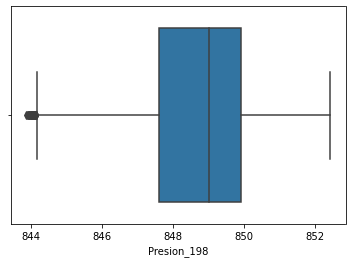

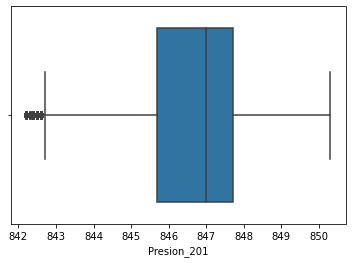

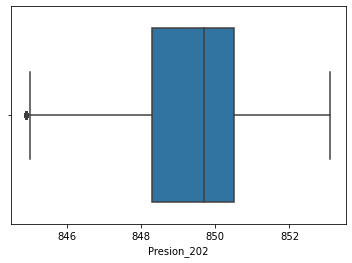

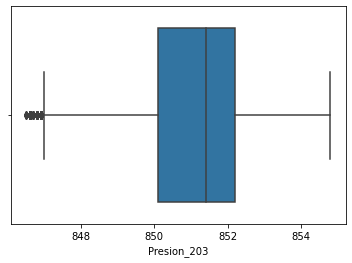

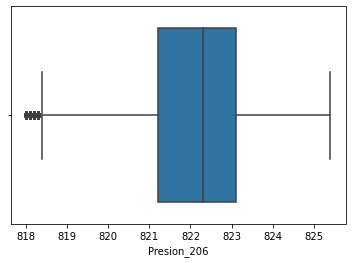

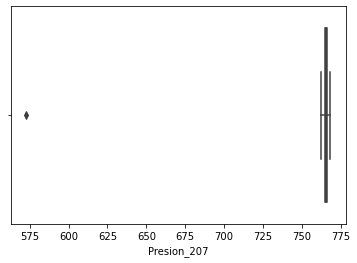

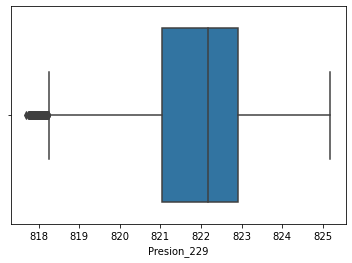

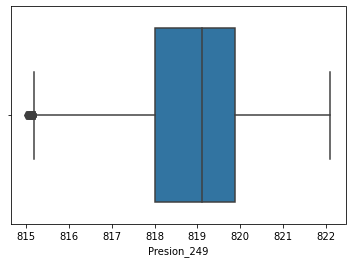

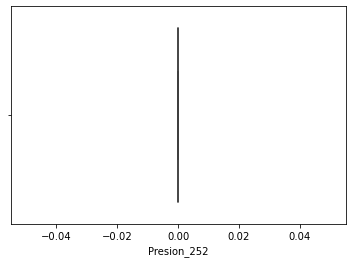

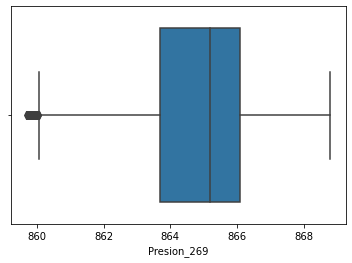

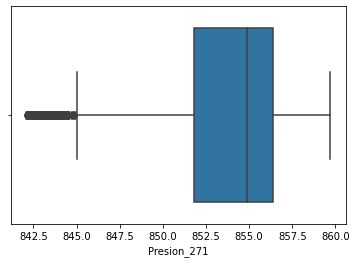

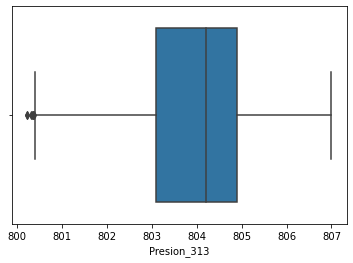

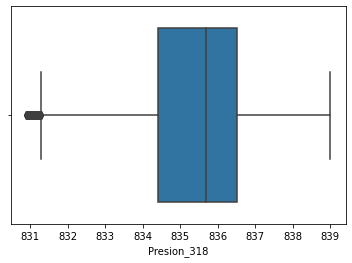

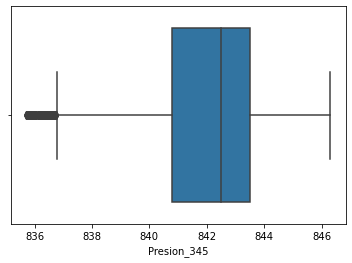

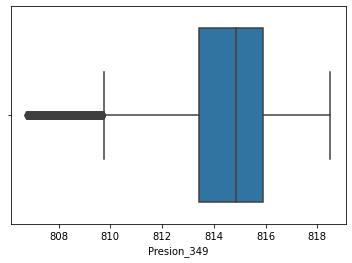

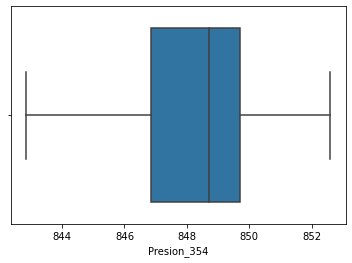

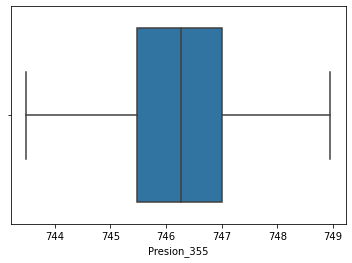

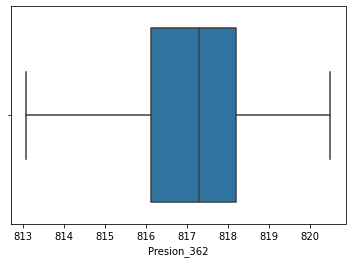

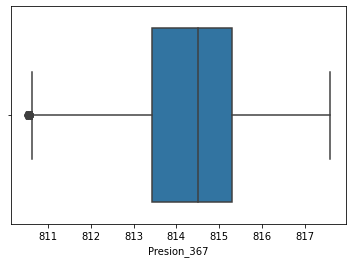

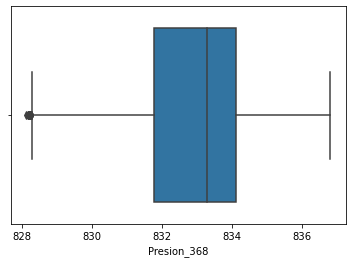

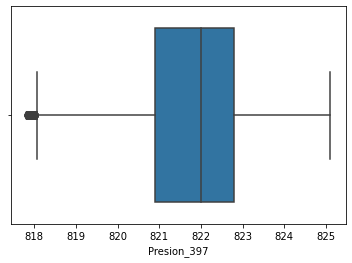

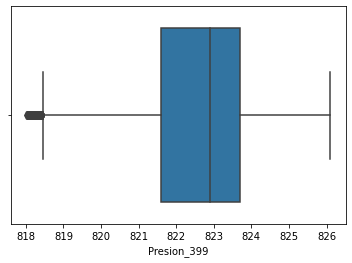

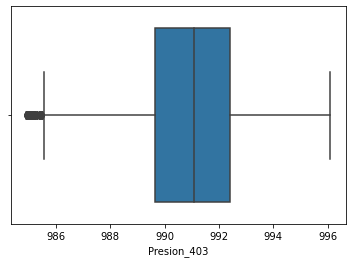

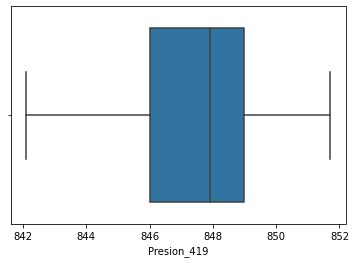

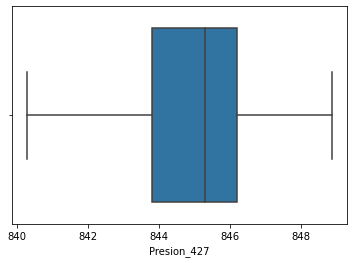

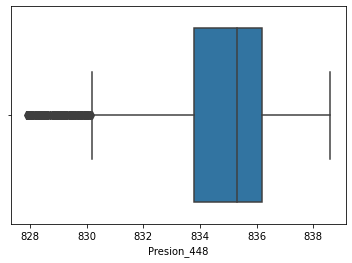

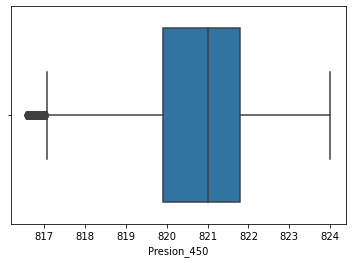

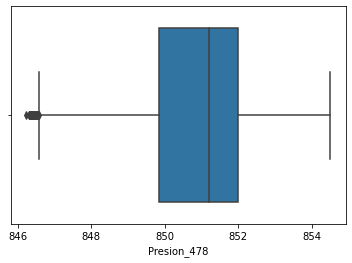

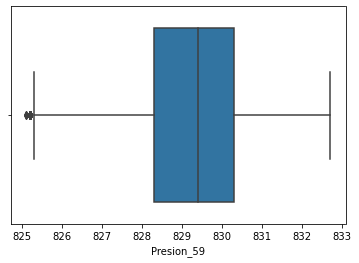

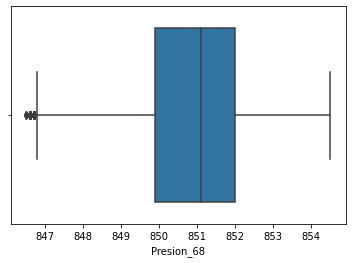

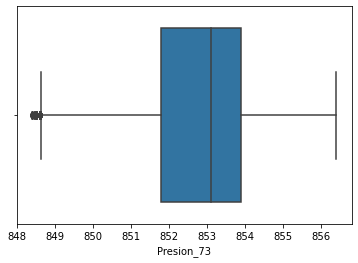

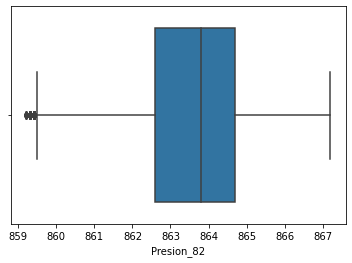

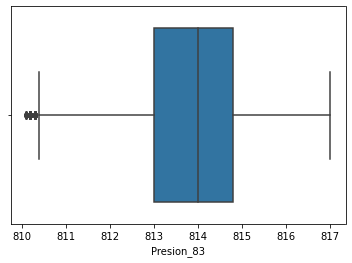

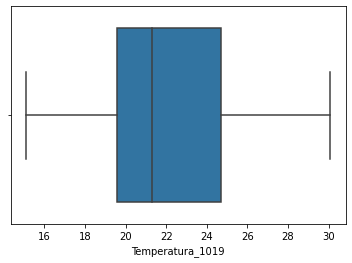

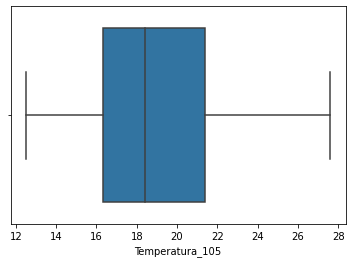

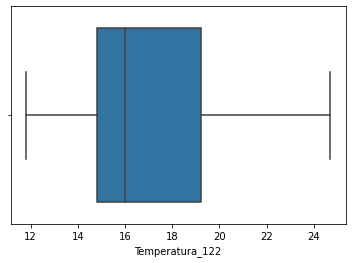

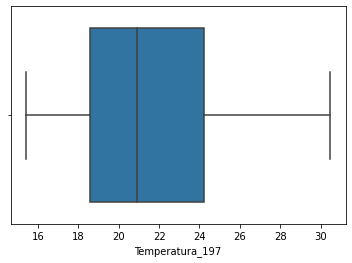

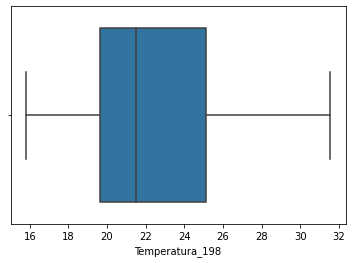

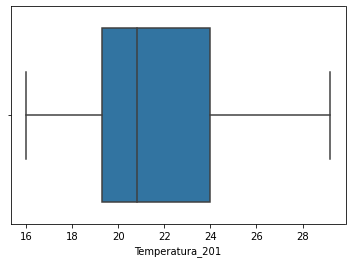

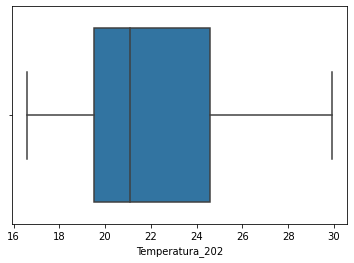

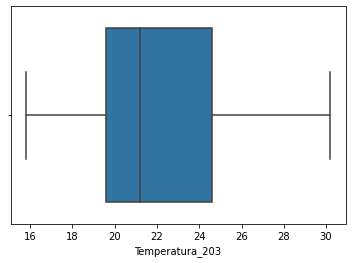

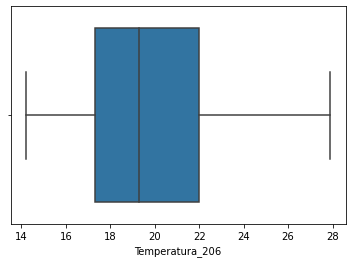

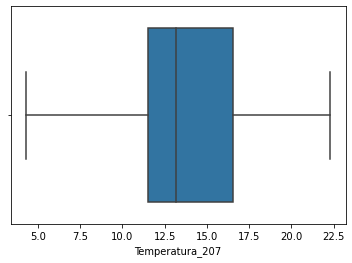

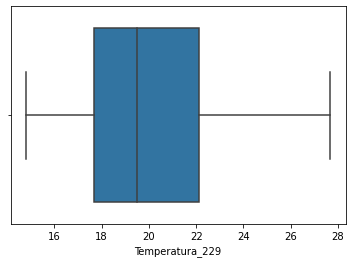

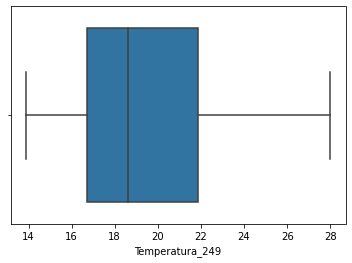

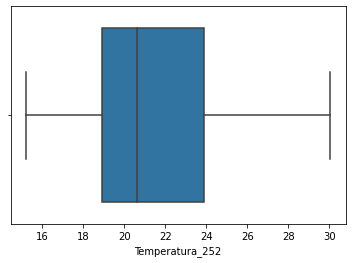

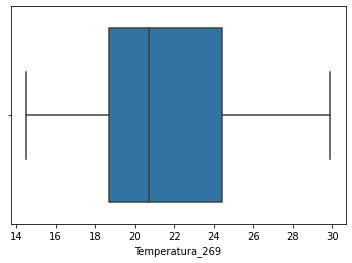

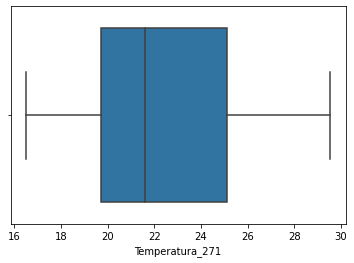

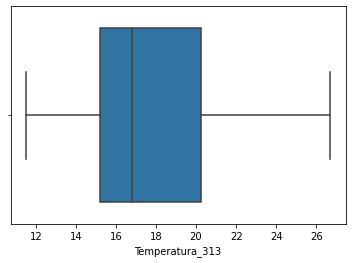

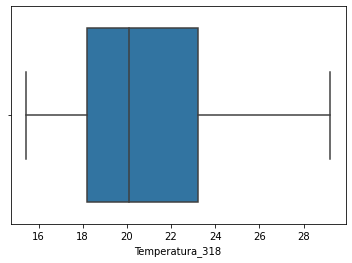

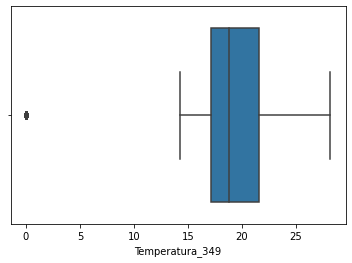

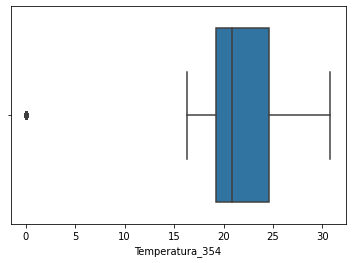

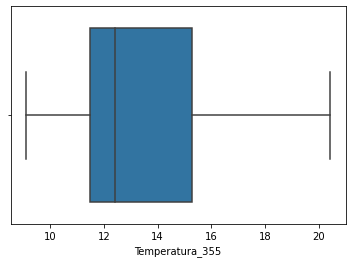

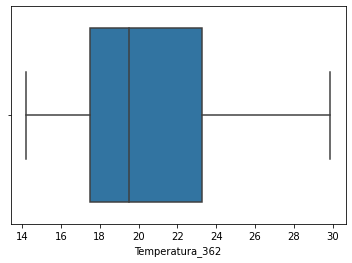

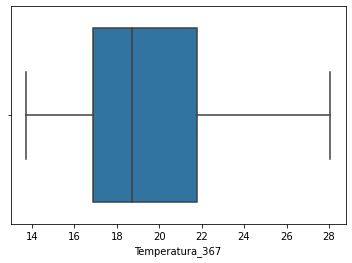

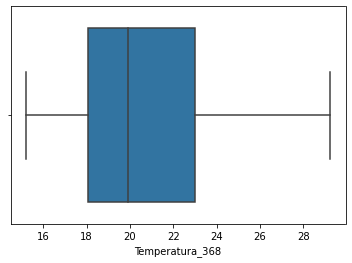

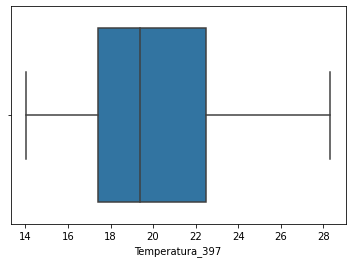

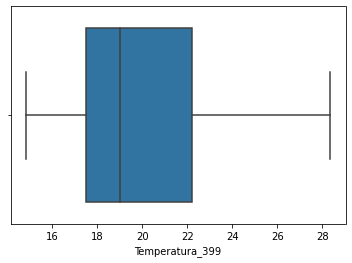

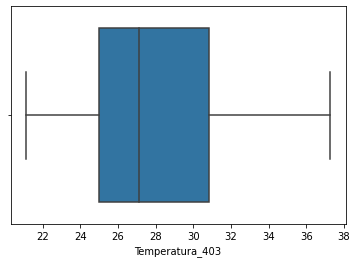

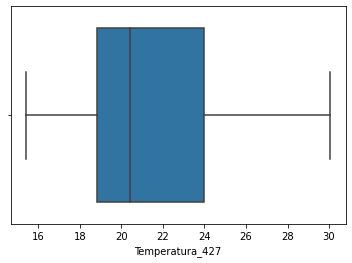

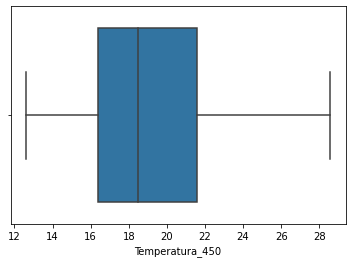

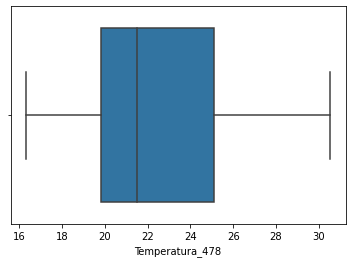

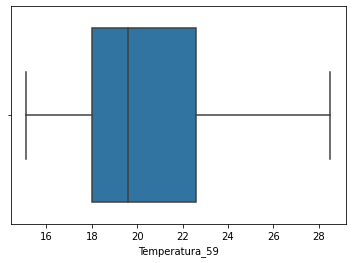

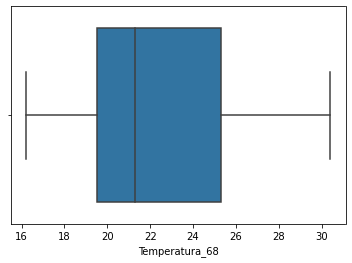

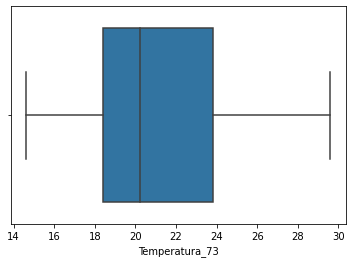

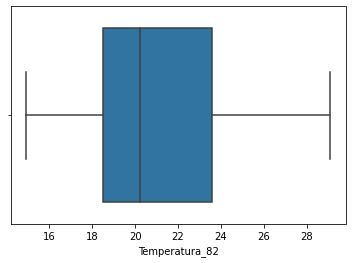

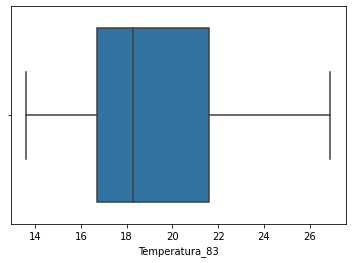

In [18]:
#boxplots are plotted for each column
for i in range(len(datos_siata.columns)):
    plt.figure()
    sns.boxplot(x=datos_siata.iloc[:,i])
    plt.show()

The data that present outliers in this case are: Humedad_349, Humedad_354, P1_139, P1_231, P1_233, P1_257, P1_30, P1_435, P1_77, P1_79, P1_80, Presion_207, Temperatura_349, Temperatura_354. These outliers are removed and replaced as in the case of missing data using an interpolation (in the case of rainfall interpolation is also used since it is very likely that these outliers have occurred in periods of rain)

In [10]:
datos_siata['Humedad_349'][datos_siata.Humedad_349 < 20] = np.nan
datos_siata['Humedad_349'] = datos_siata['Humedad_349'].interpolate()
#sns.boxplot(x=datos_siata['Humedad_349'])

datos_siata['Humedad_354'][datos_siata.Humedad_354 < 20] = np.nan
datos_siata['Humedad_354'] = datos_siata['Humedad_354'].interpolate()
#sns.boxplot(x=datos_siata['Humedad_354'])

datos_siata['P1_139'][datos_siata.P1_139 > 5] = np.nan
datos_siata['P1_139'] = datos_siata['P1_139'].interpolate()
#sns.boxplot(x=datos_siata['P1_139'])

datos_siata['P1_231'][datos_siata.P1_231 > 5] = np.nan
datos_siata['P1_231'] = datos_siata['P1_231'].interpolate()
#sns.boxplot(x=datos_siata['P1_231'])

datos_siata['P1_233'][datos_siata.P1_233 > 5] = np.nan
datos_siata['P1_233'] = datos_siata['P1_233'].interpolate()
#sns.boxplot(x=datos_siata['P1_233'])

datos_siata['P1_257'][datos_siata.P1_257 > 5] = np.nan
datos_siata['P1_257'] = datos_siata['P1_257'].interpolate()
#sns.boxplot(x=datos_siata['P1_257'])

datos_siata['P1_30'][datos_siata.P1_30 > 5] = np.nan
datos_siata['P1_30'] = datos_siata['P1_30'].interpolate()
#sns.boxplot(x=datos_siata['P1_30'])

datos_siata['P1_435'][datos_siata.P1_435 > 5] = np.nan
datos_siata['P1_435'] = datos_siata['P1_435'].interpolate()
#sns.boxplot(x=datos_siata['P1_435'])

datos_siata['P1_77'][datos_siata.P1_77 > 5] = np.nan
datos_siata['P1_77'] = datos_siata['P1_77'].interpolate()
#sns.boxplot(x=datos_siata['P1_77'])

datos_siata['P1_79'][datos_siata.P1_79 > 5] = np.nan
datos_siata['P1_79'] = datos_siata['P1_79'].interpolate()
#sns.boxplot(x=datos_siata['P1_79'])

datos_siata['P1_80'][datos_siata.P1_80 > 5] = np.nan
datos_siata['P1_80'] = datos_siata['P1_80'].interpolate()
#sns.boxplot(x=datos_siata['P1_80'])

datos_siata['Presion_207'][datos_siata.Presion_207 < 600] = np.nan
datos_siata['Presion_207'] = datos_siata['Presion_207'].interpolate()
#sns.boxplot(x=datos_siata['Presion_207'])

datos_siata['Temperatura_349'][datos_siata.Temperatura_349 < 5] = np.nan
datos_siata['Temperatura_349'] = datos_siata['Temperatura_349'].interpolate()
#sns.boxplot(x=datos_siata['Temperatura_349'])

datos_siata['Temperatura_354'][datos_siata.Temperatura_354 < 5] = np.nan
datos_siata['Temperatura_354'] = datos_siata['Temperatura_354'].interpolate()
#sns.boxplot(x=datos_siata['Temperatura_354'])

In addition, the boxplots also allow us to observe that there are some columns that present data equal to 0 for the entire month of January, so these are eliminated.

In [11]:
datos_siata = datos_siata.drop(columns=['P2_105','P2_122','P2_201','P2_202','P2_203','P2_206','P2_207',
                                        'P2_68','P2_73','P2_82','P2_83','Presion_252','Presion_1019'])

## Normalize data
We normalize the data obtained since we are working with measurements with very different units (% humidity, mm of water, hPA and ºC)

In [12]:
scaler = StandardScaler()
scaler.fit(datos_siata)
siata_norm = pd.DataFrame(scaler.transform(datos_siata), columns=datos_siata.columns, index=datos_siata.index)

siata_norm

Unnamed: 0  Humedad_1019  Humedad_105  Humedad_122  \
fecha_hora                                                                
2021-01-01 00:00:00   -1.732014      0.754166     1.000448     0.478996   
2021-01-01 00:00:00   -1.731941      0.754166     1.000448     0.478996   
2021-01-01 00:00:00   -1.731868      0.754166     1.000448     0.478996   
2021-01-01 00:00:00   -1.731795      0.754166     1.000448     0.478996   
2021-01-01 00:00:00   -1.731722      0.754166     1.000448     0.478996   
...                         ...           ...          ...          ...   
2021-01-31 23:55:00    1.731722      0.004979    -0.077863    -0.521351   
2021-01-31 23:56:00    1.731795     -0.045217    -0.064384    -0.561048   
2021-01-31 23:57:00    1.731868     -0.176324    -0.057644    -0.537230   
2021-01-31 23:58:00    1.731941     -0.348638    -0.050905    -0.568987   
2021-01-31 23:59:00    1.732014     -0.148605    -0.050905    -0.576926   

                     Humedad_197  Humedad_198  Humedad_201  Humedad_202  \
fecha_hora                                                                
2021-01-01 00:00:00     0.569701     0.738215     0.729070     0.768658   
2021-01-01 00:00:00     0.569701     0.738215     0.729070     0.768658   
2021-01-01 00:00:00     0.569701     0.738215     0.729070     0.768658   
2021-01-01 00:00:00     0.569701     0.738215     0.729070     0.768658   
2021-01-01 00:00:00     0.569701     0.738215     0.729070     0.768658   
...                          ...          ...          ...          ...   
2021-01-31 23:55:00     0.110325    -0.076006     0.016787    -0.542574   
2021-01-31 23:56:00     0.110325    -0.076006    -0.051942    -0.465790   
2021-01-31 23:57:00     0.110325    -0.096362    -0.201896    -0.406726   
2021-01-31 23:58:00     0.110325    -0.134165    -0.395587    -0.365381   
2021-01-31 23:59:00     0.052903    -0.134165    -0.201896    -0.371287   

                     Humedad_203  Humedad_206  ...  Temperatura_399  \
fecha_hora                                     ...                    
2021-01-01 00:00:00     0.668465     0.879100  ...        -0.811750   
2021-01-01 00:00:00     0.668465     0.879100  ...        -0.811750   
2021-01-01 00:00:00     0.668465     0.879100  ...        -0.811750   
2021-01-01 00:00:00     0.668465     0.879100  ...        -0.811750   
2021-01-01 00:00:00     0.668465     0.879100  ...        -0.811750   
...                          ...          ...  ...              ...   
2021-01-31 23:55:00    -0.044627     0.065058  ...        -0.153616   
2021-01-31 23:56:00    -0.076180     0.071133  ...        -0.153616   
2021-01-31 23:57:00    -0.069869     0.052909  ...        -0.157081   
2021-01-31 23:58:00    -0.063559     0.028609  ...        -0.188255   
2021-01-31 23:59:00    -0.057248     0.028609  ...        -0.188255   

                     Temperatura_403  Temperatura_427  Temperatura_450  \
fecha_hora                                                               
2021-01-01 00:00:00        -0.577729        -0.676468        -0.818168   
2021-01-01 00:00:00        -0.577729        -0.676468        -0.818168   
2021-01-01 00:00:00        -0.577729        -0.676468        -0.818168   
2021-01-01 00:00:00        -0.577729        -0.676468        -0.818168   
2021-01-01 00:00:00        -0.577729        -0.676468        -0.818168   
...                              ...              ...              ...   
2021-01-31 23:55:00        -0.422153        -0.127472        -0.126106   
2021-01-31 23:56:00        -0.422153        -0.157972        -0.117079   
2021-01-31 23:57:00        -0.422153        -0.148822        -0.096017   
2021-01-31 23:58:00        -0.422153        -0.157972        -0.114070   
2021-01-31 23:59:00        -0.422153        -0.157972        -0.129115   

                     Temperatura_478  Temperatura_59  Temperatura_68  \
fecha_hora                                                             
2021-01-01 00:00:00        -0.646347  

## Correlation
As we could see previously, the behavior of the variables that correspond to the same measure for the different meteorological stations is very similar, so it is clear that these measures present a high correlation (this correlation is causal since the meteorological conditions vary depending on the sector but they will not present completely different behaviors). To observe this better, we make a heat map with the correlations between the different variables, being almost 400 variables, it is a bit complicated, but the behavior that we are mentioning can be clearly observed.

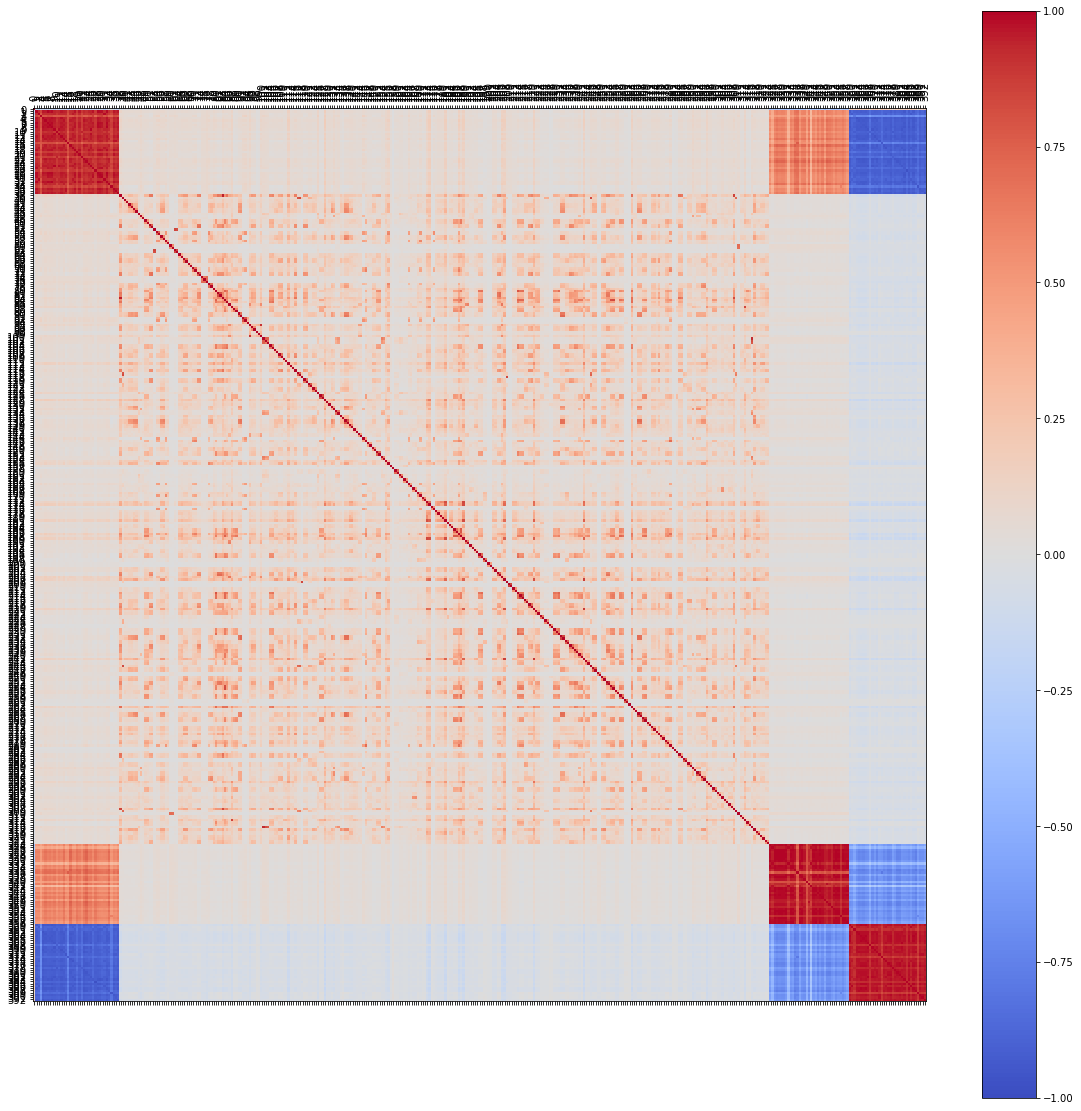

In [22]:
corr = siata_norm.corr()
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(siata_norm.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
plt.show()

The 4 types of variables humidity, precipitation, pressure and temperature can be clearly distinguished, and as we mentioned it can be seen that between the different measures of each of these variables there is a very high correlation (the one that presents a less marked correlation is the variable of precipitation). On the other hand, a correlation close to -1 can be observed between the humidity and temperature variables.

## Dimensionality-reduction
Since we have a very high number of variables with high collinearity, it is necessary to perform a dimensionality reduction process on the data set. First, autoencoders were used to perform this data compression, however, when using the entire data set and testing with different configurations on the NN, it was necessary to considerably reduce the learning rate of the optimizer so that the loss function could converge, however it converges for values that are too high (close to 0.78 for validation data) so we assume that too much information is lost in this compression process.

In [20]:
#split the data into train and test sets
X_train, X_test = train_test_split(siata_norm, random_state=1046)
X_train.shape

(35504, 393)

In [21]:
#create autoencoder class
class Autoencoder(Model):
    def __init__(self, input_shape, output_shape):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
                                            layers.InputLayer(input_shape),
                                            layers.Dense(units=300, activation='relu'),
                                            layers.Dense(units=350, activation='relu'),
                                            layers.Dense(units=200, activation='relu'),
                                            layers.Dense(units=output_shape, activation='relu')])
    
        self.decoder = tf.keras.Sequential([
                                            layers.Dense(units=200, activation='relu'),
                                            layers.Dense(units=350, activation='relu'),
                                            layers.Dense(units=300, activation='relu'),
                                            layers.Dense(units=input_shape, activation='sigmoid')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [22]:
#compile
autoencoder = Autoencoder(X_train.shape[1], 160)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
#train
history=autoencoder.fit(X_train, X_train,
                        epochs=100,
                        shuffle=True,
                        validation_data=(X_test, X_test))

Epoch 1/100
1110/1110 [==============================] - 20s 16ms/step - loss: 0.8920 - val_loss: 0.8077
Epoch 2/100
1110/1110 [==============================] - 14s 12ms/step - loss: 0.8504 - val_loss: 0.7990
Epoch 3/100
1110/1110 [==============================] - 14s 13ms/step - loss: 0.8436 - val_loss: 0.7934
Epoch 4/100
1110/1110 [==============================] - 15s 14ms/step - loss: 0.8380 - val_loss: 0.7910
Epoch 5/100
1110/1110 [==============================] - 16s 15ms/step - loss: 0.8359 - val_loss: 0.7899
Epoch 6/100
1110/1110 [==============================] - 17s 15ms/step - loss: 0.8340 - val_loss: 0.7880
Epoch 7/100
1110/1110 [==============================] - 15s 13ms/step - loss: 0.8322 - val_loss: 0.7861
Epoch 8/100
1110/1110 [==============================] - 14s 13ms/step - loss: 0.8301 - val_loss: 0.7852
Epoch 9/100
1110/1110 [==============================] - 14s 12ms/step - loss: 0.8288 - val_loss: 0.7840
Epoch 10/100
1110/1110 [==============================]

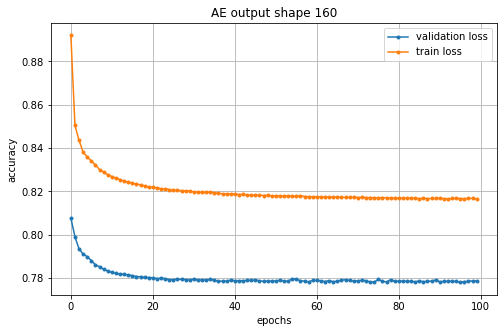

In [28]:
#visualization of the accuracy
fig,ax=plt.subplots(1,1,figsize=(8,5))

ax.plot(np.arange(100),history.history['val_loss'], '.-', label='validation loss')
ax.plot(np.arange(100),history.history['loss'], '.-', label='train loss')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.set_title('AE output shape 160')
ax.grid()
ax.legend()

Then the same process was carried out dividing the data set into the 4 types of variables that we are analyzing (humidity, precipitation, pressure and temperature)
### Humedad

In [27]:
#split the data into train and test sets
X_train_humedad, X_test_humedad = train_test_split(siata_norm.loc[:,'Humedad_1019':'Humedad_83'], random_state=1046)
X_train_humedad.shape

(35504, 37)

In [28]:
#create autoencoder class
class Autoencoder(Model):
    def __init__(self, input_shape, output_shape):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
                                            layers.InputLayer(input_shape),
                                            layers.Dense(units=32, activation='relu'),
                                            layers.Dense(units=16, activation='relu'),
                                            layers.Dense(units=8, activation='relu'),
                                            layers.Dense(units=output_shape, activation='relu')])
    
        self.decoder = tf.keras.Sequential([
                                            layers.Dense(units=8, activation='relu'),
                                            layers.Dense(units=16, activation='relu'),
                                            layers.Dense(units=32, activation='relu'),
                                            layers.Dense(units=input_shape, activation='sigmoid')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [29]:
#compile
autoencoder_humedad = Autoencoder(X_train_humedad.shape[1], 4)
autoencoder_humedad.compile(optimizer='adam', loss='mse')
#train
history_humedad=autoencoder_humedad.fit(X_train_humedad, X_train_humedad,
                                        epochs=100,
                                        shuffle=True,
                                        validation_data=(X_test_humedad, X_test_humedad))

Epoch 1/100
1110/1110 [==============================] - 2s 1ms/step - loss: 0.6833 - val_loss: 0.6644
Epoch 2/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6407 - val_loss: 0.6626
Epoch 3/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6396 - val_loss: 0.6618
Epoch 4/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6386 - val_loss: 0.6605
Epoch 5/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6364 - val_loss: 0.6585
Epoch 6/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6343 - val_loss: 0.6559
Epoch 7/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6329 - val_loss: 0.6552
Epoch 8/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6323 - val_loss: 0.6548
Epoch 9/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6320 - val_loss: 0.6545
Epoch 10/100
1110/1110 [==============================] - 1s 1ms/step - l

Epoch 80/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6258 - val_loss: 0.6485
Epoch 81/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6258 - val_loss: 0.6486
Epoch 82/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6258 - val_loss: 0.6485
Epoch 83/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6258 - val_loss: 0.6485
Epoch 84/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6258 - val_loss: 0.6485
Epoch 85/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6258 - val_loss: 0.6485
Epoch 86/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6258 - val_loss: 0.6484
Epoch 87/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6257 - val_loss: 0.6484
Epoch 88/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6258 - val_loss: 0.6486
Epoch 89/100
1110/1110 [==============================] - 1s 1ms

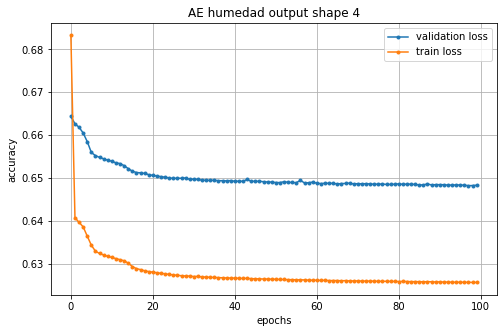

In [30]:
#visualization of the loss function
fig,ax=plt.subplots(1,1,figsize=(8,5))

ax.plot(np.arange(100),history_humedad.history['val_loss'], '.-', label='validation loss')
ax.plot(np.arange(100),history_humedad.history['loss'], '.-', label='train loss')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.set_title('AE humedad output shape 4')
ax.grid()
ax.legend()

### Presion

In [31]:
#split the data into train and test sets
X_train_presion, X_test_presion = train_test_split(siata_norm.loc[:,'Presion_105':'Presion_83'], random_state=1046)
X_train_presion.shape

(35504, 35)

In [32]:
#compile
autoencoder_presion = Autoencoder(X_train_presion.shape[1], 4)
autoencoder_presion.compile(optimizer='adam', loss='mse')
#train
history_presion=autoencoder_presion.fit(X_train_presion, X_train_presion,
                                        epochs=100,
                                        shuffle=True,
                                        validation_data=(X_test_presion, X_test_presion))

Epoch 1/100
1110/1110 [==============================] - 2s 1ms/step - loss: 0.6577 - val_loss: 0.6434
Epoch 2/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6226 - val_loss: 0.6398
Epoch 3/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6159 - val_loss: 0.6347
Epoch 4/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6139 - val_loss: 0.6339
Epoch 5/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6134 - val_loss: 0.6335
Epoch 6/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6130 - val_loss: 0.6333
Epoch 7/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6128 - val_loss: 0.6330
Epoch 8/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6126 - val_loss: 0.6328
Epoch 9/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6122 - val_loss: 0.6324
Epoch 10/100
1110/1110 [==============================] - 1s 1ms/step - l

Epoch 80/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6096 - val_loss: 0.6300
Epoch 81/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6096 - val_loss: 0.6301
Epoch 82/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6096 - val_loss: 0.6300
Epoch 83/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6096 - val_loss: 0.6301
Epoch 84/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6097 - val_loss: 0.6301
Epoch 85/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6096 - val_loss: 0.6300
Epoch 86/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6096 - val_loss: 0.6300
Epoch 87/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6096 - val_loss: 0.6300
Epoch 88/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.6096 - val_loss: 0.6300
Epoch 89/100
1110/1110 [==============================] - 1s 1ms

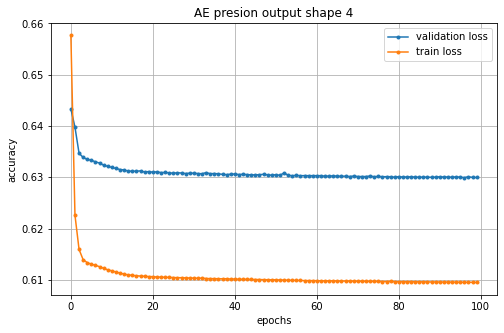

In [33]:
#visualization of the loss function
fig,ax=plt.subplots(1,1,figsize=(8,5))

ax.plot(np.arange(100),history_presion.history['val_loss'], '.-', label='validation loss')
ax.plot(np.arange(100),history_presion.history['loss'], '.-', label='train loss')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.set_title('AE presion output shape 4')
ax.grid()
ax.legend()

### Temperatura

In [34]:
#split the data into train and test sets
X_train_temp, X_test_temp = train_test_split(siata_norm.loc[:,'Temperatura_1019':'Temperatura_83'], random_state=1046)
X_train_temp.shape

(35504, 34)

In [35]:
#compile
autoencoder_temp = Autoencoder(X_train_temp.shape[1], 4)
autoencoder_temp.compile(optimizer='adam', loss='mse')
#train
history_temp=autoencoder_temp.fit(X_train_temp, X_train_temp,
                                  epochs=100,
                                  shuffle=True,
                                  validation_data=(X_test_temp, X_test_temp))

Epoch 1/100
1110/1110 [==============================] - 2s 1ms/step - loss: 0.5428 - val_loss: 0.5109
Epoch 2/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.5103 - val_loss: 0.5086
Epoch 3/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.5065 - val_loss: 0.5060
Epoch 4/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.5058 - val_loss: 0.5056
Epoch 5/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.5050 - val_loss: 0.5045
Epoch 6/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.5039 - val_loss: 0.5037
Epoch 7/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.5033 - val_loss: 0.5033
Epoch 8/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.5030 - val_loss: 0.5031
Epoch 9/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.5028 - val_loss: 0.5029
Epoch 10/100
1110/1110 [==============================] - 1s 1ms/step - l

Epoch 80/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.4984 - val_loss: 0.4987
Epoch 81/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.4984 - val_loss: 0.4987
Epoch 82/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.4984 - val_loss: 0.4986
Epoch 83/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.4984 - val_loss: 0.4986
Epoch 84/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.4984 - val_loss: 0.4986
Epoch 85/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.4983 - val_loss: 0.4986
Epoch 86/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.4984 - val_loss: 0.4986
Epoch 87/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.4983 - val_loss: 0.4985
Epoch 88/100
1110/1110 [==============================] - 1s 1ms/step - loss: 0.4983 - val_loss: 0.4986
Epoch 89/100
1110/1110 [==============================] - 1s 1ms

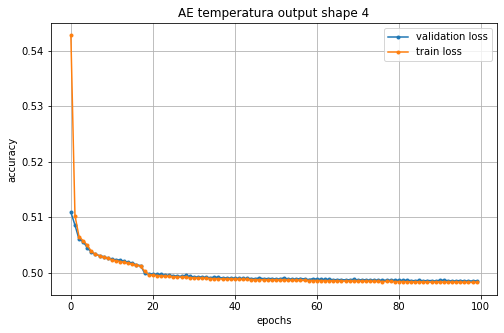

In [36]:
#visualization of the loss function
fig,ax=plt.subplots(1,1,figsize=(8,5))

ax.plot(np.arange(100),history_temp.history['val_loss'], '.-', label='validation loss')
ax.plot(np.arange(100),history_temp.history['loss'], '.-', label='train loss')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.set_title('AE temperatura output shape 4')
ax.grid()
ax.legend()

For the reduction process of these variables, it is also observed that the loss function converges for quite high values, the minimum being close to 0.5, for which a compression with a considerable loss of information is obtained, however these results will be used to train the final model.
### Precipitación 

In [24]:
#split the data into train and test sets
X_train_precipitacion, X_test_precipitacion = train_test_split(siata_norm.loc[:,'P1_1019':'P2_9'], random_state=1046)
X_train_precipitacion.shape

(35504, 286)

In [25]:
#create autoencoder class
class Autoencoder(Model):
    def __init__(self, input_shape, output_shape):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
                                            layers.InputLayer(input_shape),
                                            layers.Dense(units=256, activation='relu'),
                                            layers.Dense(units=192, activation='relu'),
                                            #layers.Dense(units=128, activation='relu'),
                                            #layers.Dense(units=64, activation='relu'),
                                            layers.Dense(units=output_shape, activation='relu')])
    
        self.decoder = tf.keras.Sequential([
                                            #layers.Dense(units=64, activation='relu'),
                                            #layers.Dense(units=128, activation='relu'),
                                            layers.Dense(units=192, activation='relu'),
                                            layers.Dense(units=256, activation='relu'),
                                            layers.Dense(units=input_shape, activation='sigmoid')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [26]:
#compile
autoencoder_precipitacion = Autoencoder(X_train_precipitacion.shape[1], 128)
autoencoder_precipitacion.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')
#train
history_precipitacion=autoencoder_precipitacion.fit(X_train_precipitacion, X_train_precipitacion,
                                                    epochs=100,
                                                    shuffle=True,
                                                    validation_data=(X_test_precipitacion, X_test_precipitacion))

Epoch 1/100
1110/1110 [==============================] - 14s 8ms/step - loss: 0.9918 - val_loss: 0.8701
Epoch 2/100
1110/1110 [==============================] - 9s 8ms/step - loss: 0.9350 - val_loss: 0.8616
Epoch 3/100
1110/1110 [==============================] - 9s 8ms/step - loss: 0.9277 - val_loss: 0.8567
Epoch 4/100
1110/1110 [==============================] - 9s 8ms/step - loss: 0.9232 - val_loss: 0.8540
Epoch 5/100
1110/1110 [==============================] - 9s 8ms/step - loss: 0.9201 - val_loss: 0.8521
Epoch 6/100
1110/1110 [==============================] - 9s 8ms/step - loss: 0.9179 - val_loss: 0.8499
Epoch 7/100
1110/1110 [==============================] - 9s 8ms/step - loss: 0.9159 - val_loss: 0.8488
Epoch 8/100
1110/1110 [==============================] - 8s 8ms/step - loss: 0.9142 - val_loss: 0.8477
Epoch 9/100
1110/1110 [==============================] - 9s 8ms/step - loss: 0.9130 - val_loss: 0.8470
Epoch 10/100
1110/1110 [==============================] - 8s 8ms/step - 

Epoch 80/100
1110/1110 [==============================] - 9s 8ms/step - loss: 0.9031 - val_loss: 0.8443
Epoch 81/100
1110/1110 [==============================] - 9s 8ms/step - loss: 0.9032 - val_loss: 0.8444
Epoch 82/100
1110/1110 [==============================] - 8s 7ms/step - loss: 0.9031 - val_loss: 0.8446
Epoch 83/100
1110/1110 [==============================] - 8s 7ms/step - loss: 0.9030 - val_loss: 0.8440
Epoch 84/100
1110/1110 [==============================] - 9s 8ms/step - loss: 0.9031 - val_loss: 0.8446
Epoch 85/100
1110/1110 [==============================] - 9s 8ms/step - loss: 0.9031 - val_loss: 0.8440
Epoch 86/100
1110/1110 [==============================] - 10s 9ms/step - loss: 0.9031 - val_loss: 0.8444
Epoch 87/100
1110/1110 [==============================] - 9s 8ms/step - loss: 0.9030 - val_loss: 0.8444
Epoch 88/100
1110/1110 [==============================] - 9s 8ms/step - loss: 0.9030 - val_loss: 0.8449
Epoch 89/100
1110/1110 [==============================] - 9s 8m

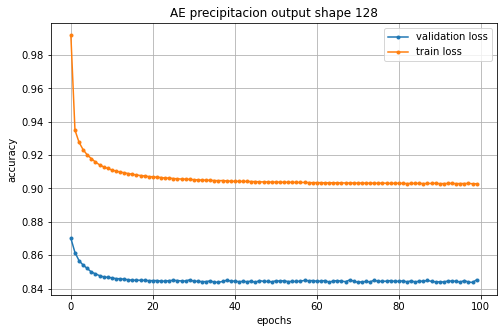

In [27]:
#visualization of the loss function
fig,ax=plt.subplots(1,1,figsize=(8,5))

ax.plot(np.arange(100),history_precipitacion.history['val_loss'], '.-', label='validation loss')
ax.plot(np.arange(100),history_precipitacion.history['loss'], '.-', label='train loss')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.set_title('AE precipitacion output shape 128')
ax.grid()
ax.legend()

Again for the case of the precipitation variables we can see that when applying the autoencoders with different structures for the NN it is necessary to considerably reduce the learning rate and it is seen that the loss function converges again for very high values (close to 0.84 for validtion data), so in this case we will use the PCA (principal component analysis) dimensionality reduction method to dimensionally reduce this type of variables.

### PCA

With the PCA a new system of variables is obtained through a linear transformation where the eigenvectors of the correlation matrix of the variables to be reduced are taken as new dimensions, from this new coordinate system we analyze the accumulated variance as a function of the quantity of variables that we take for the new reduced system.

In [41]:
#apply the PCA method
pca = PCA()

precipitacion_pca = pd.DataFrame(pca.fit_transform(siata_norm.loc[:,'P1_1019':'P2_9']))

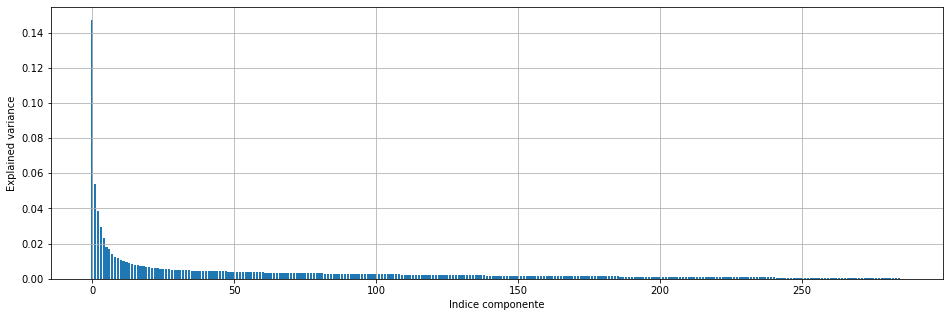

In [42]:
#display the variance and cumulative variance of the variables obtained
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(16,5))
plt.bar(np.arange(0,286), var_exp, align='center')
plt.ylabel('Explained variance')
plt.xlabel('Indice componente')
plt.grid()
plt.show()

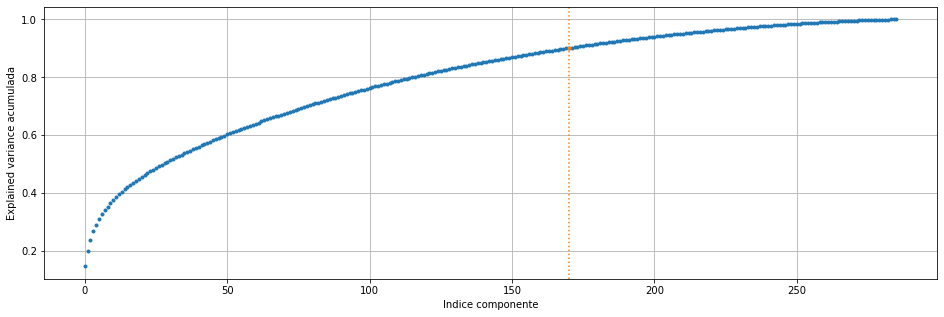

In [43]:
plt.figure(figsize=(16,5))
plt.plot(np.arange(0,286), cum_var_exp, '.')
plt.plot(np.arange(0,286)[cum_var_exp>0.9][0], cum_var_exp[cum_var_exp>0.9][0], '.')
plt.axvline(np.arange(0,286)[cum_var_exp>0.9][0],0,1,ls=':',color='tab:orange')
plt.ylabel('Explained variance acumulada')
plt.xlabel('Indice componente')
plt.grid()
plt.show()

In this case we obtain a cumulative variance of 0.9 by taking 170 variables from this new coordinate system so we reduce the set of 286 variables that we had initially

On the other hand, we can apply the PCA method directly to the initial set of data, in this case we obtain a smaller set of data in general where by taking 160 variables of the new coordinate system, an accumulated variance of 0.9 is obtained.

In [44]:
#apply the PCA method
pca = PCA()

siata_pca = pd.DataFrame(pca.fit_transform(siata_norm))

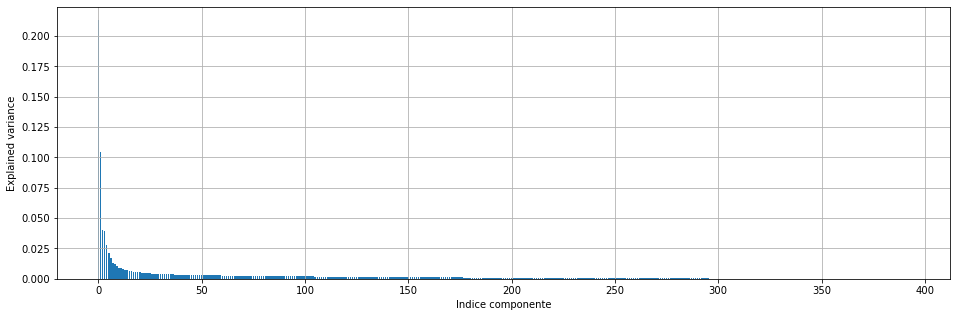

In [45]:
#display the variance and cumulative variance of the variables obtained
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(16,5))
plt.bar(np.arange(0,393), var_exp, align='center')
plt.ylabel('Explained variance')
plt.xlabel('Indice componente')
plt.grid()
plt.show()

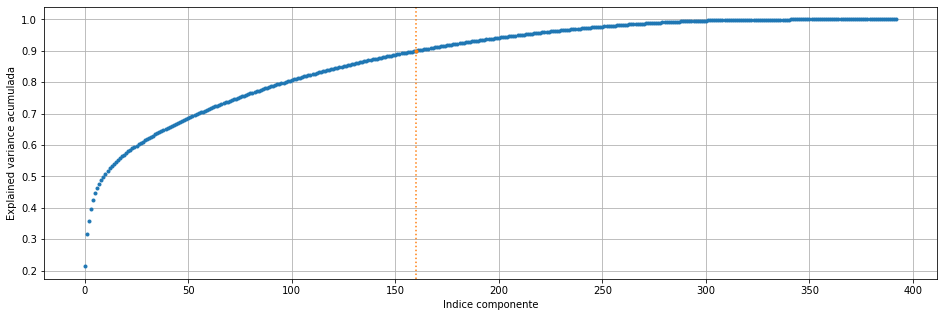

In [46]:
plt.figure(figsize=(16,5))
plt.plot(np.arange(0,393), cum_var_exp, '.')
plt.plot(np.arange(0,393)[cum_var_exp>0.9][0], cum_var_exp[cum_var_exp>0.9][0], '.')
plt.axvline(np.arange(0,393)[cum_var_exp>0.9][0],0,1,ls=':',color='tab:orange')
plt.ylabel('Explained variance acumulada')
plt.xlabel('Indice componente')
plt.grid()
plt.show()

## Reduced dataframes
In this case we save 4 data sets with reduced dimensions: 1) reduction over all variables using AE 2) only applying the reduction on humidity, pressure and temperature using AE and the original Precipitation data. 3) the reduction on humidity, pressure and temperature using AE and the reduction using PCA on precipitation. 4) reduction over all variables using PCA.

In [29]:
#Reduced data set 1 is obtained.
reduced_full_ae = autoencoder.encoder(siata_norm.to_numpy()).numpy()
reduced_full_ae = pd.DataFrame(reduced_full_ae, index=datos_siata.index)

#Reduced data set 2 is obtained.
humedad_ae = autoencoder_humedad.encoder(siata_norm.loc[:,'Humedad_1019':'Humedad_83'].to_numpy()).numpy()
presion_ae = autoencoder_presion.encoder(siata_norm.loc[:,'Presion_105':'Presion_83'].to_numpy()).numpy()
temperatura_ae = autoencoder_temp.encoder(siata_norm.loc[:,'Temperatura_1019':'Temperatura_83'].to_numpy()).numpy()

ae = np.concatenate((humedad_ae,presion_ae,temperatura_ae), axis=1)

precipitacion_original = siata_norm.loc[:,'P1_1019':'P2_9'].to_numpy()
precipitacion_pca = precipitacion_pca[:,0:170]

reduced_ae = np.concatenate((ae,precipitacion_original), axis=1)
reduced_ae = pd.DataFrame(reduced_ae, index=datos_siata.index)

#Reduced data set 3 is obtained.
reduced_ae_pca = np.concatenate((ae,precipitacion_pca), axis=1)
reduced_ae_pca = pd.DataFrame(reduced_ae_pca, index=datos_siata.index)

#Reduced data set 4 is obtained.
reduced_pca = siata_pca.iloc[:,0:160].to_numpy()
reduced_pca = pd.DataFrame(reduced_pca, index=datos_siata.index)

In this case, the original data set is reduced using autoencoders to 160 dimensions to compare those obtained with those obtained with the PCA method, which also reduces the system to 160 dimensions.

In [30]:
#The reduced data is saved in a csv to make it easier to handle the data later
reduced_full_ae.to_csv('reduced_full_ae.csv')
reduced_ae.to_csv('reduced_ae.csv')
reduced_ae_pca.to_csv('reduced_ae_pca.csv')
reduced_pca.to_csv('reduced_pca.csv')

In [31]:
reduced_full_ae

0         1    2         3         4         5    \
fecha_hora                                                                   
2021-01-01 00:00:00  2.413487  0.866595  0.0  2.242357  1.309563  0.490545   
2021-01-01 00:00:00  2.413479  0.866589  0.0  2.242368  1.309550  0.490549   
2021-01-01 00:00:00  2.413470  0.866582  0.0  2.242379  1.309538  0.490552   
2021-01-01 00:00:00  2.413460  0.866576  0.0  2.242391  1.309527  0.490554   
2021-01-01 00:00:00  2.413452  0.866569  0.0  2.242402  1.309519  0.490559   
...                       ...       ...  ...       ...       ...       ...   
2021-01-31 23:55:00  2.339830  4.014544  0.0  0.891212  2.783924  0.000000   
2021-01-31 23:56:00  2.370748  3.879194  0.0  0.969776  2.745995  0.000000   
2021-01-31 23:57:00  2.439265  3.850888  0.0  1.019047  2.798728  0.000000   
2021-01-31 23:58:00  2.500404  3.805968  0.0  1.068627  2.814100  0.000000   
2021-01-31 23:59:00  2.435961  3.862896  0.0  1.049326  2.820630  0.000000   

                     6         7         8         9    ...       150  \
fecha_hora                                              ...             
2021-01-01 00:00:00  0.0  0.052759  5.725495  5.682232  ...  2.870345   
2021-01-01 00:00:00  0.0  0.052779  5.725441  5.682217  ...  2.870354   
2021-01-01 00:00:00  0.0  0.052797  5.725387  5.682196  ...  2.870364   
2021-01-01 00:00:00  0.0  0.052817  5.725335  5.682178  ...  2.870373   
2021-01-01 00:00:00  0.0  0.052837  5.725278  5.682160  ...  2.870381   
...                  ...       ...       ...       ...  ...       ...   
2021-01-31 23:55:00  0.0  3.892523  5.765883  2.553627  ...  0.000000   
2021-01-31 23:56:00  0.0  3.879632  5.750945  2.449246  ...  0.000000   
2021-01-31 23:57:00  0.0  3.921705  5.841094  2.466595  ...  0.000000   
2021-01-31 23:58:00  0.0  3.922201  5.760384  2.317979  ...  0.000000   
2021-01-31 23:59:00  0.0  3.949619  5.784338  2.385407  ...  0.000000   

                          151       152       153       154       155  \
fecha_hora                                                              
2021-01-01 00:00:00  3.970177  5.160622  0.000000  0.000000  5.688167   
2021-01-01 00:00:00  3.970148  5.160608  0.000000  0.000000  5.688132   
2021-01-01 00:00:00  3.970117  5.160601  0.000000  0.000000  5.688102   
2021-01-01 00:00:00  3.970083  5.160588  0.000000  0.000000  5.688070   
2021-01-01 00:00:00  3.970052  5.160576  0.000000  0.000000  5.688036   
...                       ...       ...       ...       ...       ...   
2021-01-31 23:55:00  1.918764  3.987060  0.843519  1.771165  2.404447   
2021-01-31 23:56:00  1.852926  4.060342  0.831573  1.755905  2.450950   
2021-01-31 23:57:00  1.818510  4.074581  0.647129  1.874653  2.608313   
2021-01-31 23:58:00  1.693328  4.097731  0.477439  1.970874  2.619778   
2021-01-31 23:59:00  1.787787  4.092007  0.668524  1.950516  2.514215   

                          156       157       158       159  
fecha_hora                                                   
2021-01-01 00:00:00  0.677172  4.212957  5.684127  1.457153  
2021-01-01 00:00:00  0.677171  4.212940  5.684131  1.457157  
2021-01-01 00:00:00  0.677173  4.212921  5.684133  1.457160  
2021-01-01 00:00:00  0.677175  4.212904  5.684134  1.457165  
2021-01-01 00:00:00  0.677176  4.212885  5.684136  1.457169  
...                       ...       ...       ...       ...  
2021-01-31 23:55:00  2.732477  4.255923  2.996560  3.455692  
2021-01-31 23:56:00  2.730227  4.269573  3.017729  3.392941  
2021-01-31 23:57:00  2.749800  4.377090  2.969415  3.319687  
2021-01-31 23:58:00  2.665252  4.475847  2.836277  3.299256  
2021-01-31 23:59:00  2.714866  4.483394  2.800990  3.298891  

[47339 rows x 160 columns]

In [57]:
reduced_ae

0         1         2          3         4    \
fecha_hora                                                               
2021-01-01 00:00:00  1.649305  1.347153  1.850103   2.238317  6.892502   
2021-01-01 00:00:00  1.649305  1.347153  1.850103   2.238317  6.892502   
2021-01-01 00:00:00  1.649305  1.347153  1.850103   2.238317  6.892502   
2021-01-01 00:00:00  1.649305  1.347153  1.850103   2.238317  6.892502   
2021-01-01 00:00:00  1.649305  1.347153  1.850103   2.238317  6.892502   
...                       ...       ...       ...        ...       ...   
2021-01-31 23:55:00  7.216040  5.847245  5.119563  12.941918  9.412034   
2021-01-31 23:56:00  7.081392  5.676199  4.982352  12.789566  9.991235   
2021-01-31 23:57:00  7.300367  5.698805  5.073651  12.968758  9.770637   
2021-01-31 23:58:00  6.830319  5.537029  5.175261  12.804183  9.786211   
2021-01-31 23:59:00  7.103309  5.701358  5.022354  12.859037  9.827315   

                          5          6    7          8          9    ...  \
fecha_hora                                                           ...   
2021-01-01 00:00:00  7.946938   2.280917  0.0  18.662300  41.183819  ...   
2021-01-01 00:00:00  7.946938   2.280917  0.0  18.662300  41.183819  ...   
2021-01-01 00:00:00  7.946938   2.280917  0.0  18.662300  41.183819  ...   
2021-01-01 00:00:00  7.946938   2.280917  0.0  18.662300  41.183819  ...   
2021-01-01 00:00:00  7.946938   2.280917  0.0  18.662300  41.183819  ...   
...                       ...        ...  ...        ...        ...  ...   
2021-01-31 23:55:00  2.326462  11.668601  0.0   2.647684  31.351139  ...   
2021-01-31 23:56:00  2.140654  12.673103  0.0   2.640184  31.497656  ...   
2021-01-31 23:57:00  2.143918  12.517776  0.0   3.057065  31.484415  ...   
2021-01-31 23:58:00  2.087259  12.414677  0.0   3.104067  31.286314  ...   
2021-01-31 23:59:00  1.956081  12.623450  0.0   3.184254  31.163313  ...   

                          288       289       290       291       292  \
fecha_hora                                                              
2021-01-01 00:00:00 -0.049965 -0.040717 -0.089114  0.645321 -0.047576   
2021-01-01 00:00:00 -0.049965 -0.040717 -0.089114  0.645321 -0.047576   
2021-01-01 00:00:00 -0.049965 -0.040717 -0.089114  0.645321 -0.047576   
2021-01-01 00:00:00 -0.049965 -0.040717 -0.089114  0.645321 -0.047576   
2021-01-01 00:00:00 -0.049965 -0.040717 -0.089114  0.645321 -0.047576   
...                       ...       ...       ...       ...       ...   
2021-01-31 23:55:00 -0.049965 -0.040717 -0.089114 -0.062886 -0.047576   
2021-01-31 23:56:00 -0.049965 -0.040717 -0.089114 -0.062886 -0.047576   
2021-01-31 23:57:00 -0.049965 -0.040717 -0.089114 -0.062886 -0.047576   
2021-01-31 23:58:00 -0.049965 -0.040717 -0.089114 -0.062886 -0.047576   
2021-01-31 23:59:00 -0.049965 -0.040717 -0.089114 -0.062886 -0.047576   

                          293       294      295       296       297  
fecha_hora                                                            
2021-01-01 00:00:00 -0.046852 -0.054127 -0.05747 -0.047459 -0.048485  
2021-01-01 00:00:00 -0.046852 -0.054127 -0.05747 -0.047459 -0.048485  
2021-01-01 00:00:00 -0.046852 -0.054127 -0.05747 -0.047459 -0.048485  
2021-01-01 00:00:00 -0.046852 -0.054127 -0.05747 -0.047459 -0.048485  
2021-01-01 00:00:00 -0.046852 -0.054127 -0.05747 -0.047459 -0.048485  
...                       ...       ...      ...       ...       ...  
2021-01-31 23:55:00 -0.046852 -0.054127 -0.05747 -0.047459 -0.048485  
2021-01-31 23:56:00 -0.046852 -0.054127 -0.05747 -0.047459 -0.048485  
2021-01-31 23:57:00 -0.046852 -0.054127 -0.05747 -0.047459 -0.048485  
2021-01-31 23:58:00 -0.046852 -0.054127 -0.05747 -0.047459 -0.048485  
2021-01-31 23:59:00 -0.046852 -0.054127 -0.05747 -0.047459 -0.048485  

[47339 rows x 298 columns]

In [58]:
reduced_ae_pca

0         1         2          3         4    \
fecha_hora                                                               
2021-01-01 00:00:00  1.649305  1.347153  1.850103   2.238317  6.892502   
2021-01-01 00:00:00  1.649305  1.347153  1.850103   2.238317  6.892502   
2021-01-01 00:00:00  1.649305  1.347153  1.850103   2.238317  6.892502   
2021-01-01 00:00:00  1.649305  1.347153  1.850103   2.238317  6.892502   
2021-01-01 00:00:00  1.649305  1.347153  1.850103   2.238317  6.892502   
...                       ...       ...       ...        ...       ...   
2021-01-31 23:55:00  7.216040  5.847245  5.119563  12.941918  9.412034   
2021-01-31 23:56:00  7.081392  5.676199  4.982352  12.789566  9.991235   
2021-01-31 23:57:00  7.300367  5.698805  5.073651  12.968758  9.770637   
2021-01-31 23:58:00  6.830319  5.537029  5.175261  12.804183  9.786211   
2021-01-31 23:59:00  7.103309  5.701358  5.022354  12.859037  9.827315   

                          5          6    7          8          9    ...  \
fecha_hora                                                           ...   
2021-01-01 00:00:00  7.946938   2.280917  0.0  18.662300  41.183819  ...   
2021-01-01 00:00:00  7.946938   2.280917  0.0  18.662300  41.183819  ...   
2021-01-01 00:00:00  7.946938   2.280917  0.0  18.662300  41.183819  ...   
2021-01-01 00:00:00  7.946938   2.280917  0.0  18.662300  41.183819  ...   
2021-01-01 00:00:00  7.946938   2.280917  0.0  18.662300  41.183819  ...   
...                       ...        ...  ...        ...        ...  ...   
2021-01-31 23:55:00  2.326462  11.668601  0.0   2.647684  31.351139  ...   
2021-01-31 23:56:00  2.140654  12.673103  0.0   2.640184  31.497656  ...   
2021-01-31 23:57:00  2.143918  12.517776  0.0   3.057065  31.484415  ...   
2021-01-31 23:58:00  2.087259  12.414677  0.0   3.104067  31.286314  ...   
2021-01-31 23:59:00  1.956081  12.623450  0.0   3.184254  31.163313  ...   

                          172       173       174       175       176  \
fecha_hora                                                              
2021-01-01 00:00:00 -0.044557  0.003421  0.066459 -0.000149  0.026425   
2021-01-01 00:00:00 -0.044557  0.003421  0.066459 -0.000149  0.026425   
2021-01-01 00:00:00 -0.044557  0.003421  0.066459 -0.000149  0.026425   
2021-01-01 00:00:00 -0.044557  0.003421  0.066459 -0.000149  0.026425   
2021-01-01 00:00:00 -0.044557  0.003421  0.066459 -0.000149  0.026425   
...                       ...       ...       ...       ...       ...   
2021-01-31 23:55:00  0.006146 -0.003085 -0.012325  0.003761 -0.002621   
2021-01-31 23:56:00  0.009624 -0.005481 -0.017627  0.007294 -0.000236   
2021-01-31 23:57:00  0.003958 -0.001579 -0.008991  0.001539 -0.004121   
2021-01-31 23:58:00  0.004731 -0.002111 -0.010170  0.002324 -0.003591   
2021-01-31 23:59:00  0.003765 -0.001445 -0.008697  0.001343 -0.004254   

                          177       178       179       180       181  
fecha_hora                                                             
2021-01-01 00:00:00  0.136667  0.014420 -0.042382  0.015021 -0.014486  
2021-01-01 00:00:00  0.136667  0.014420 -0.042382  0.015021 -0.014486  
2021-01-01 00:00:00  0.136667  0.014420 -0.042382  0.015021 -0.014486  
2021-01-01 00:00:00  0.136667  0.014420 -0.042382  0.015021 -0.014486  
2021-01-01 00:00:00  0.136667  0.014420 -0.042382  0.015021 -0.014486  
...                       ...       ...       ...       ...       ...  
2021-01-31 23:55:00  0.002341 -0.012876  0.005010 -0.016655  0.000752  
2021-01-31 23:56:00 -0.001472 -0.015389  0.007659 -0.021369  0.002969  
2021-01-31 23:57:00  0.004739 -0.011295  0.003343 -0.013691 -0.000643  
2021-01-31 23:58:00  0.003892 -0.011854  0.003932 -0.014738 -0.000150  
2021-01-31 23:59:00  0.004951 -0.011155  0.003196 -0.013429 -0.000766  

[47339 rows x 182 columns]

In [59]:
reduced_pca

0         1         2         3         4    \
fecha_hora                                                              
2021-01-01 00:00:00  8.008808 -2.307227  2.529586  0.188306  0.517016   
2021-01-01 00:00:00  8.008806 -2.307228  2.529581  0.188306  0.517016   
2021-01-01 00:00:00  8.008804 -2.307228  2.529577  0.188307  0.517016   
2021-01-01 00:00:00  8.008802 -2.307229  2.529573  0.188307  0.517016   
2021-01-01 00:00:00  8.008800 -2.307229  2.529568  0.188308  0.517016   
...                       ...       ...       ...       ...       ...   
2021-01-31 23:55:00 -0.004700 -1.042019 -0.653058  0.285170  0.272873   
2021-01-31 23:56:00 -0.009387 -1.035773 -0.710864  0.288180  0.272988   
2021-01-31 23:57:00 -0.065748 -1.035806 -0.677669  0.286928  0.273134   
2021-01-31 23:58:00 -0.127217 -1.028172 -0.657170  0.283930  0.272923   
2021-01-31 23:59:00 -0.095204 -1.030522 -0.677260  0.285990  0.272588   

                          5         6         7         8         9    ...  \
fecha_hora                                                             ...   
2021-01-01 00:00:00  0.071082  0.452400 -0.134382 -0.170093 -0.173381  ...   
2021-01-01 00:00:00  0.071083  0.452399 -0.134386 -0.170093 -0.173379  ...   
2021-01-01 00:00:00  0.071083  0.452397 -0.134391 -0.170093 -0.173376  ...   
2021-01-01 00:00:00  0.071083  0.452396 -0.134395 -0.170092 -0.173374  ...   
2021-01-01 00:00:00  0.071083  0.452394 -0.134399 -0.170092 -0.173371  ...   
...                       ...       ...       ...       ...       ...  ...   
2021-01-31 23:55:00  0.026564  0.416706 -0.449241 -0.125459 -0.015996  ...   
2021-01-31 23:56:00  0.024280  0.408668 -0.445174 -0.129778 -0.018102  ...   
2021-01-31 23:57:00  0.032037  0.421959 -0.455586 -0.126180 -0.017344  ...   
2021-01-31 23:58:00  0.032844  0.420865 -0.456472 -0.131155 -0.019459  ...   
2021-01-31 23:59:00  0.033373  0.423392 -0.456191 -0.127654 -0.017995  ...   

                          150       151       152       153       154  \
fecha_hora                                                              
2021-01-01 00:00:00  0.013882 -0.101551 -0.142110  0.049187  0.153110   
2021-01-01 00:00:00  0.013881 -0.101551 -0.142109  0.049186  0.153108   
2021-01-01 00:00:00  0.013880 -0.101550 -0.142108  0.049186  0.153106   
2021-01-01 00:00:00  0.013879 -0.101549 -0.142107  0.049185  0.153104   
2021-01-01 00:00:00  0.013879 -0.101548 -0.142106  0.049185  0.153103   
...                       ...       ...       ...       ...       ...   
2021-01-31 23:55:00  0.227868 -0.002762 -0.022245  0.046121  0.015052   
2021-01-31 23:56:00  0.231449 -0.005324 -0.019185  0.052272  0.016286   
2021-01-31 23:57:00  0.223473 -0.000386 -0.023387  0.044448  0.017403   
2021-01-31 23:58:00  0.223447 -0.001085 -0.019503  0.049078  0.022573   
2021-01-31 23:59:00  0.224752 -0.000285 -0.018714  0.046487  0.018599   

                          155       156       157       158       159  
fecha_hora                                                             
2021-01-01 00:00:00 -0.128904 -0.014713  0.148981 -0.057433  0.074331  
2021-01-01 00:00:00 -0.128903 -0.014713  0.148979 -0.057432  0.074329  
2021-01-01 00:00:00 -0.128901 -0.014713  0.148976 -0.057431  0.074328  
2021-01-01 00:00:00 -0.128900 -0.014713  0.148974 -0.057430  0.074326  
2021-01-01 00:00:00 -0.128898 -0.014712  0.148972 -0.057429  0.074324  
...                       ...       ...       ...       ...       ...  
2021-01-31 23:55:00 -0.146677 -0.032730  0.211034  0.007074  0.143425  
2021-01-31 23:56:00 -0.145803 -0.026370  0.214895  0.012724  0.146271  
2021-01-31 23:57:00 -0.146914 -0.034146  0.211335  0.002593  0.140775  
2021-01-31 23:58:00 -0.149085 -0.030663  0.217515  0.002177  0.143258  
2021-01-31 23:59:00 -0.149143 -0.032465  0.215718  0.002242  0.143706  

[47339 rows x 160 columns]

In [10]:
#re-import the data
reduced_full_ae = pd.read_csv('reduced_full_ae.csv',index_col=0)
reduced_full_ae.index = pd.to_datetime(reduced_full_ae.index)

reduced_ae = pd.read_csv('reduced_ae.csv',index_col=0)
reduced_ae.index = pd.to_datetime(reduced_ae.index)

reduced_ae_pca = pd.read_csv('reduced_ae_pca.csv',index_col=0)
reduced_ae_pca.index = pd.to_datetime(reduced_ae_pca.index)

reduced_pca = pd.read_csv('reduced_pca.csv',index_col=0)
reduced_pca.index = pd.to_datetime(reduced_pca.index)

## Regroup and renormalice the data
Finally, we group the data obtained in time intervals of 1 hour to compare them with the influx data and normalize them again (since the process using AE does not guarantee that the new variables are normalized).

In [11]:
reduced_full_ae = reduced_full_ae.resample('H').mean()
reduced_ae = reduced_ae.resample('H').mean()
reduced_ae_pca = reduced_ae_pca.resample('H').mean()
reduced_pca = reduced_pca.resample('H').mean()

In [12]:
scaler = StandardScaler()

scaler.fit(reduced_full_ae)
reduced_full_ae = pd.DataFrame(scaler.transform(reduced_full_ae), columns=reduced_full_ae.columns, index=reduced_full_ae.index)

scaler.fit(reduced_ae)
reduced_ae = pd.DataFrame(scaler.transform(reduced_ae), columns=reduced_ae.columns, index=reduced_ae.index)

scaler.fit(reduced_ae_pca)
reduced_ae_pca = pd.DataFrame(scaler.transform(reduced_ae_pca), columns=reduced_ae_pca.columns, index=reduced_ae_pca.index)

scaler.fit(reduced_pca)
reduced_pca = pd.DataFrame(scaler.transform(reduced_pca), columns=reduced_pca.columns, index=reduced_pca.index)

## Influx data

In [13]:
#re-import the data
afluencia_enero = pd.read_csv('afluencia_enero.csv',index_col=0)
afluencia_enero.index = pd.to_datetime(afluencia_enero.index)
afluencia_enero

parada           tipo_dia    sum
fecha_hora                                          
2021-01-03 04:00:00    ACE  Domingo y Festivo  213.0
2021-01-03 05:00:00    ACE  Domingo y Festivo  535.0
2021-01-03 06:00:00    ACE  Domingo y Festivo  543.0
2021-01-03 07:00:00    ACE  Domingo y Festivo  497.0
2021-01-03 08:00:00    ACE  Domingo y Festivo  512.0
...                    ...                ...    ...
2021-01-30 19:00:00    XPO             Sábado  602.0
2021-01-30 20:00:00    XPO             Sábado  537.0
2021-01-30 21:00:00    XPO             Sábado  373.0
2021-01-30 22:00:00    XPO             Sábado  150.0
2021-01-30 23:00:00    XPO             Sábado    4.0

[65301 rows x 3 columns]

As in this case we have 2 categorical variables (station and type of day) we will use sklearn's OneHotEncoder method to organize these data numerically (this method generates a new binary variable for each category of the categorical variable)

In [14]:
#aply OneHotEncoder
enc = OneHotEncoder()
enc.fit(afluencia_enero[['parada','tipo_dia']])
cols = np.concatenate((enc.categories_[0],enc.categories_[1]))

In [15]:
#generate the new dataframe whith the categories
afluencia_oht = pd.DataFrame(enc.transform(afluencia_enero[['parada','tipo_dia']]).toarray(), columns=cols, index=afluencia_enero.index)
afluencia_oht.index = pd.to_datetime(afluencia_oht.index)
afluencia_oht

ACE  ALE  ALP  AND  ARA  ARV  AUR  AYU  BAN  BEL  ...  \
fecha_hora                                                             ...   
2021-01-03 04:00:00  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2021-01-03 05:00:00  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2021-01-03 06:00:00  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2021-01-03 07:00:00  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2021-01-03 08:00:00  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...                  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2021-01-30 19:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2021-01-30 20:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2021-01-30 21:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2021-01-30 22:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2021-01-30 23:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

                     TRI  UDA  UDM  UNI  VAL  VIS  XPO  Domingo y Festivo  \
fecha_hora                                                                  
2021-01-03 04:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0                1.0   
2021-01-03 05:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0                1.0   
2021-01-03 06:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0                1.0   
2021-01-03 07:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0                1.0   
2021-01-03 08:00:00  0.0  0.0  0.0  0.0  0.0  0.0  0.0                1.0   
...                  ...  ...  ...  ...  ...  ...  ...                ...   
2021-01-30 19:00:00  0.0  0.0  0.0  0.0  0.0  0.0  1.0                0.0   
2021-01-30 20:00:00  0.0  0.0  0.0  0.0  0.0  0.0  1.0                0.0   
2021-01-30 21:00:00  0.0  0.0  0.0  0.0  0.0  0.0  1.0                0.0   
2021-01-30 22:00:00  0.0  0.0  0.0  0.0  0.0  0.0  1.0                0.0   
2021-01-30 23:00:00  0.0  0.0  0.0  0.0  0.0  0.0  1.0                0.0   

                     Laboral  Sábado  
fecha_hora                            
2021-01-03 04:00:00      0.0     0.0  
2021-01-03 05:00:00      0.0     0.0  
2021-01-03 06:00:00      0.0     0.0  
2021-01-03 07:00:00      0.0     0.0  
2021-01-03 08:00:00      0.0     0.0  
...                      ...     ...  
2021-01-30 19:00:00      0.0     1.0  
2021-01-30 20:00:00      0.0     1.0  
2021-01-30 21:00:00      0.0     1.0  
2021-01-30 22:00:00      0.0     1.0  
2021-01-30 23:00:00      0.0     1.0  

[65301 rows x 124 columns]

Now we merge the new dataframe of the categories with the dataframes of the weather variables (based on the temporal index) to obtain the X data for model training.

In [16]:
X_full_ae = pd.merge(afluencia_oht,reduced_full_ae,left_index=True, right_index=True)
X_ae = pd.merge(afluencia_oht,reduced_ae,left_index=True, right_index=True)
X_ae_pca = pd.merge(afluencia_oht,reduced_ae_pca,left_index=True, right_index=True)
X_pca = pd.merge(afluencia_oht,reduced_pca,left_index=True, right_index=True)

We also add the variable 'hora' taken from the index. Talking with the people who provided me with the influx data, they mentioned that when studying the influx model, this is one of the variables that best defines it, so if we want to obtain a good model, it is important to take it into account.

In [17]:
X_full_ae['hora'] = X_full_ae.index.hour
X_ae['hora'] = X_ae.index.hour
X_ae_pca['hora'] = X_ae_pca.index.hour
X_pca['hora'] = X_pca.index.hour

In [18]:
#final data for training
X_full_ae = X_full_ae.to_numpy()
X_ae = X_ae.to_numpy()
X_ae_pca = X_ae_pca.to_numpy()
X_pca = X_pca.to_numpy()

#we normalize the influx data
scaler = StandardScaler()
scaler.fit(afluencia_enero['sum'].to_numpy().reshape(-1, 1))

y_data = scaler.transform(afluencia_enero['sum'].to_numpy().reshape(-1, 1))

## Regression problem
Finally we build and train the NN model for the regression problem for the diferente data sets, in this case we will use an NN regularized by the Ridge method and using dropout in order to avoid overfitting in the model due to the high number of variables.

In [19]:
tf.random.set_seed(1046)

In [20]:
def get_regularized_model(input_shape,wd,drate):
    model=Sequential([InputLayer(input_shape=input_shape),
                Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
                Dropout(drate),
                Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
                Dropout(drate),
                Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
                Dropout(drate),
                Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
                Dropout(drate),
                Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
                Dropout(drate),
                Dense(128, kernel_regularizer = regularizers.l2(wd), activation="relu"),
                Dense(units=1,activation='linear')
    ])
    return model

def compile_model(model):
    model.compile(optimizer='adam',loss='mse',metrics=['mse'])

### First model

In [21]:
X_train_full_ae,X_test_full_ae,y_train,y_test = train_test_split(X_full_ae, y_data, random_state=1046)
X_train_full_ae.shape

(48975, 285)

In [32]:
full_ae_model = get_regularized_model(X_train_full_ae[0].shape,0.0001,0.2)
compile_model(full_ae_model)
full_ae_history=full_ae_model.fit(X_train_full_ae,y_train,batch_size=490,epochs=200,validation_split=0.25)

Epoch 1/200
75/75 [==============================] - 3s 27ms/step - loss: 1.0657 - mse: 0.9881 - val_loss: 0.9494 - val_mse: 0.8748
Epoch 2/200
75/75 [==============================] - 2s 21ms/step - loss: 0.9311 - mse: 0.8581 - val_loss: 0.7913 - val_mse: 0.7196
Epoch 3/200
75/75 [==============================] - 1s 19ms/step - loss: 0.8139 - mse: 0.7433 - val_loss: 0.7624 - val_mse: 0.6927
Epoch 4/200
75/75 [==============================] - 2s 21ms/step - loss: 0.7380 - mse: 0.6691 - val_loss: 0.6742 - val_mse: 0.6062
Epoch 5/200
75/75 [==============================] - 1s 19ms/step - loss: 0.7015 - mse: 0.6343 - val_loss: 0.6343 - val_mse: 0.5680
Epoch 6/200
75/75 [==============================] - 2s 21ms/step - loss: 0.6753 - mse: 0.6098 - val_loss: 0.6224 - val_mse: 0.5577
Epoch 7/200
75/75 [==============================] - 2s 21ms/step - loss: 0.6538 - mse: 0.5898 - val_loss: 0.6155 - val_mse: 0.5523
Epoch 8/200
75/75 [==============================] - 2s 20ms/step - loss: 0.

75/75 [==============================] - 2s 21ms/step - loss: 0.3912 - mse: 0.3335 - val_loss: 0.5533 - val_mse: 0.4955
Epoch 63/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3792 - mse: 0.3212 - val_loss: 0.5555 - val_mse: 0.4973
Epoch 64/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3887 - mse: 0.3304 - val_loss: 0.5332 - val_mse: 0.4750
Epoch 65/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3776 - mse: 0.3192 - val_loss: 0.5385 - val_mse: 0.4801
Epoch 66/200
75/75 [==============================] - 1s 20ms/step - loss: 0.3759 - mse: 0.3173 - val_loss: 0.5340 - val_mse: 0.4752
Epoch 67/200
75/75 [==============================] - 1s 18ms/step - loss: 0.3831 - mse: 0.3243 - val_loss: 0.5488 - val_mse: 0.4899
Epoch 68/200
75/75 [==============================] - 2s 21ms/step - loss: 0.3803 - mse: 0.3213 - val_loss: 0.5399 - val_mse: 0.4808
Epoch 69/200
75/75 [==============================] - 2s 21ms/step - loss: 0.3790 

75/75 [==============================] - 1s 18ms/step - loss: 0.3107 - mse: 0.2457 - val_loss: 0.5105 - val_mse: 0.4456
Epoch 124/200
75/75 [==============================] - 2s 21ms/step - loss: 0.3126 - mse: 0.2477 - val_loss: 0.5192 - val_mse: 0.4542
Epoch 125/200
75/75 [==============================] - 2s 21ms/step - loss: 0.3152 - mse: 0.2502 - val_loss: 0.4984 - val_mse: 0.4334
Epoch 126/200
75/75 [==============================] - 2s 21ms/step - loss: 0.3159 - mse: 0.2509 - val_loss: 0.5070 - val_mse: 0.4421
Epoch 127/200
75/75 [==============================] - 1s 20ms/step - loss: 0.3249 - mse: 0.2599 - val_loss: 0.5187 - val_mse: 0.4536
Epoch 128/200
75/75 [==============================] - 1s 20ms/step - loss: 0.3262 - mse: 0.2610 - val_loss: 0.5265 - val_mse: 0.4612
Epoch 129/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3151 - mse: 0.2498 - val_loss: 0.5170 - val_mse: 0.4517
Epoch 130/200
75/75 [==============================] - 1s 19ms/step - loss: 

75/75 [==============================] - 2s 20ms/step - loss: 0.3005 - mse: 0.2321 - val_loss: 0.5028 - val_mse: 0.4344
Epoch 185/200
75/75 [==============================] - 1s 18ms/step - loss: 0.3073 - mse: 0.2389 - val_loss: 0.4933 - val_mse: 0.4249
Epoch 186/200
75/75 [==============================] - 1s 19ms/step - loss: 0.2987 - mse: 0.2303 - val_loss: 0.5002 - val_mse: 0.4317
Epoch 187/200
75/75 [==============================] - 1s 18ms/step - loss: 0.2960 - mse: 0.2276 - val_loss: 0.5121 - val_mse: 0.4437
Epoch 188/200
75/75 [==============================] - 1s 18ms/step - loss: 0.3042 - mse: 0.2359 - val_loss: 0.5028 - val_mse: 0.4345
Epoch 189/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3080 - mse: 0.2396 - val_loss: 0.4907 - val_mse: 0.4224
Epoch 190/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3039 - mse: 0.2355 - val_loss: 0.4979 - val_mse: 0.4294
Epoch 191/200
75/75 [==============================] - 2s 20ms/step - loss: 

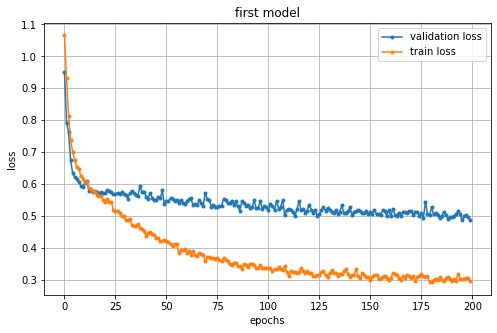

In [34]:
#visualization of the loss function
fig,ax=plt.subplots(1,1,figsize=(8,5))

ax.plot(np.arange(200),full_ae_history.history['val_loss'], '.-', label='validation loss')
ax.plot(np.arange(200),full_ae_history.history['loss'], '.-', label='train loss')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('first model')
ax.grid()
ax.legend()

In [36]:
full_ae_results = full_ae_model.evaluate(X_test_full_ae,y_test)

print('Test loss: ' + str(full_ae_results[0]))
print('Test accuracy: ' + str(full_ae_results[1]))

511/511 [==============================] - 1s 3ms/step - loss: 0.4911 - mse: 0.4224
Test loss: 0.4911356270313263
Test accuracy: 0.4223918318748474


### Second model

In [37]:
X_train_ae,X_test_ae,y_train,y_test = train_test_split(X_ae, y_data, random_state=1046)
X_train_ae.shape

(48975, 423)

In [38]:
ae_model = get_regularized_model(X_train_ae[0].shape,0.0001,0.2)
compile_model(ae_model)
ae_history=ae_model.fit(X_train_ae,y_train,batch_size=490,epochs=200,validation_split=0.25)

Epoch 1/200
75/75 [==============================] - 4s 27ms/step - loss: 1.0884 - mse: 1.0078 - val_loss: 1.0057 - val_mse: 0.9279
Epoch 2/200
75/75 [==============================] - 2s 23ms/step - loss: 1.0179 - mse: 0.9420 - val_loss: 0.9142 - val_mse: 0.8399
Epoch 3/200
75/75 [==============================] - 2s 22ms/step - loss: 0.9120 - mse: 0.8391 - val_loss: 0.8232 - val_mse: 0.7513
Epoch 4/200
75/75 [==============================] - 2s 21ms/step - loss: 0.8388 - mse: 0.7679 - val_loss: 0.8010 - val_mse: 0.7311
Epoch 5/200
75/75 [==============================] - 2s 22ms/step - loss: 0.8109 - mse: 0.7419 - val_loss: 0.7600 - val_mse: 0.6919
Epoch 6/200
75/75 [==============================] - 2s 22ms/step - loss: 0.7770 - mse: 0.7097 - val_loss: 0.7309 - val_mse: 0.6644
Epoch 7/200
75/75 [==============================] - 2s 23ms/step - loss: 0.7633 - mse: 0.6976 - val_loss: 0.7224 - val_mse: 0.6576
Epoch 8/200
75/75 [==============================] - 2s 23ms/step - loss: 0.

75/75 [==============================] - 2s 20ms/step - loss: 0.4522 - mse: 0.4051 - val_loss: 0.6116 - val_mse: 0.5645
Epoch 63/200
75/75 [==============================] - 2s 21ms/step - loss: 0.4416 - mse: 0.3944 - val_loss: 0.6247 - val_mse: 0.5776
Epoch 64/200
75/75 [==============================] - 1s 20ms/step - loss: 0.4271 - mse: 0.3799 - val_loss: 0.6035 - val_mse: 0.5563
Epoch 65/200
75/75 [==============================] - 2s 20ms/step - loss: 0.4295 - mse: 0.3822 - val_loss: 0.6145 - val_mse: 0.5670
Epoch 66/200
75/75 [==============================] - 2s 25ms/step - loss: 0.4386 - mse: 0.3911 - val_loss: 0.6040 - val_mse: 0.5566
Epoch 67/200
75/75 [==============================] - 2s 24ms/step - loss: 0.4413 - mse: 0.3938 - val_loss: 0.6207 - val_mse: 0.5731
Epoch 68/200
75/75 [==============================] - 1s 20ms/step - loss: 0.4356 - mse: 0.3880 - val_loss: 0.6268 - val_mse: 0.5792
Epoch 69/200
75/75 [==============================] - 2s 22ms/step - loss: 0.4293 

75/75 [==============================] - 1s 19ms/step - loss: 0.3614 - mse: 0.3084 - val_loss: 0.5880 - val_mse: 0.5350
Epoch 124/200
75/75 [==============================] - 2s 20ms/step - loss: 0.3830 - mse: 0.3299 - val_loss: 0.5918 - val_mse: 0.5386
Epoch 125/200
75/75 [==============================] - 2s 22ms/step - loss: 0.3678 - mse: 0.3147 - val_loss: 0.5954 - val_mse: 0.5421
Epoch 126/200
75/75 [==============================] - 2s 23ms/step - loss: 0.3858 - mse: 0.3325 - val_loss: 0.5849 - val_mse: 0.5315
Epoch 127/200
75/75 [==============================] - 2s 22ms/step - loss: 0.3728 - mse: 0.3193 - val_loss: 0.5708 - val_mse: 0.5174
Epoch 128/200
75/75 [==============================] - 2s 22ms/step - loss: 0.3585 - mse: 0.3050 - val_loss: 0.5659 - val_mse: 0.5124
Epoch 129/200
75/75 [==============================] - 2s 23ms/step - loss: 0.3687 - mse: 0.3151 - val_loss: 0.5966 - val_mse: 0.5430
Epoch 130/200
75/75 [==============================] - 2s 22ms/step - loss: 

75/75 [==============================] - 2s 20ms/step - loss: 0.3580 - mse: 0.3006 - val_loss: 0.5577 - val_mse: 0.5003
Epoch 185/200
75/75 [==============================] - 2s 21ms/step - loss: 0.3561 - mse: 0.2987 - val_loss: 0.5724 - val_mse: 0.5149
Epoch 186/200
75/75 [==============================] - 2s 20ms/step - loss: 0.3481 - mse: 0.2906 - val_loss: 0.5849 - val_mse: 0.5272
Epoch 187/200
75/75 [==============================] - 1s 20ms/step - loss: 0.3474 - mse: 0.2898 - val_loss: 0.5628 - val_mse: 0.5052
Epoch 188/200
75/75 [==============================] - 2s 21ms/step - loss: 0.3491 - mse: 0.2915 - val_loss: 0.5478 - val_mse: 0.4902
Epoch 189/200
75/75 [==============================] - 2s 20ms/step - loss: 0.3474 - mse: 0.2898 - val_loss: 0.5605 - val_mse: 0.5030
Epoch 190/200
75/75 [==============================] - 2s 20ms/step - loss: 0.3385 - mse: 0.2809 - val_loss: 0.5833 - val_mse: 0.5256
Epoch 191/200
75/75 [==============================] - 2s 20ms/step - loss: 

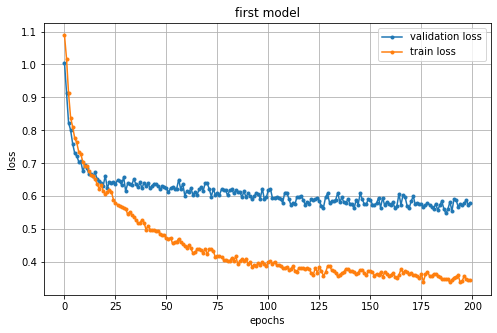

In [40]:
#visualization of the loss function
fig,ax=plt.subplots(1,1,figsize=(8,5))

ax.plot(np.arange(200),ae_history.history['val_loss'], '.-', label='validation loss')
ax.plot(np.arange(200),ae_history.history['loss'], '.-', label='train loss')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('second model')
ax.grid()
ax.legend()

In [39]:
ae_results = ae_model.evaluate(X_test_ae,y_test)

print('Test loss: ' + str(ae_results[0]))
print('Test accuracy: ' + str(ae_results[1]))

511/511 [==============================] - 2s 3ms/step - loss: 0.5848 - mse: 0.5267
Test loss: 0.5848191380500793
Test accuracy: 0.5267190933227539


### Third model

In [41]:
X_train_ae_pca,X_test_ae_pca,y_train,y_test = train_test_split(X_ae_pca, y_data, random_state=1046)
X_train_ae_pca.shape

(48975, 307)

In [43]:
ae_pca_model = get_regularized_model(X_train_ae_pca[0].shape,0.0001,0.2)
compile_model(ae_pca_model)
ae_pca_history = ae_pca_model.fit(X_train_ae_pca,y_train,batch_size=490,epochs=200,validation_split=0.25)

Epoch 1/200
75/75 [==============================] - 3s 24ms/step - loss: 1.0589 - mse: 0.9795 - val_loss: 0.9487 - val_mse: 0.8719
Epoch 2/200
75/75 [==============================] - 2s 20ms/step - loss: 0.9668 - mse: 0.8918 - val_loss: 0.8626 - val_mse: 0.7892
Epoch 3/200
75/75 [==============================] - 2s 21ms/step - loss: 0.8851 - mse: 0.8129 - val_loss: 0.8118 - val_mse: 0.7407
Epoch 4/200
75/75 [==============================] - 1s 20ms/step - loss: 0.8318 - mse: 0.7617 - val_loss: 0.7735 - val_mse: 0.7044
Epoch 5/200
75/75 [==============================] - 1s 19ms/step - loss: 0.7990 - mse: 0.7308 - val_loss: 0.7497 - val_mse: 0.6825
Epoch 6/200
75/75 [==============================] - 2s 21ms/step - loss: 0.7592 - mse: 0.6928 - val_loss: 0.7185 - val_mse: 0.6530
Epoch 7/200
75/75 [==============================] - 2s 21ms/step - loss: 0.7365 - mse: 0.6718 - val_loss: 0.6966 - val_mse: 0.6327
Epoch 8/200
75/75 [==============================] - 1s 19ms/step - loss: 0.

75/75 [==============================] - 1s 19ms/step - loss: 0.4003 - mse: 0.3513 - val_loss: 0.5887 - val_mse: 0.5397
Epoch 63/200
75/75 [==============================] - 1s 19ms/step - loss: 0.4023 - mse: 0.3532 - val_loss: 0.5845 - val_mse: 0.5354
Epoch 64/200
75/75 [==============================] - 1s 18ms/step - loss: 0.3904 - mse: 0.3414 - val_loss: 0.5702 - val_mse: 0.5212
Epoch 65/200
75/75 [==============================] - 1s 20ms/step - loss: 0.3907 - mse: 0.3418 - val_loss: 0.5754 - val_mse: 0.5265
Epoch 66/200
75/75 [==============================] - 1s 20ms/step - loss: 0.3957 - mse: 0.3467 - val_loss: 0.5880 - val_mse: 0.5390
Epoch 67/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3918 - mse: 0.3428 - val_loss: 0.6040 - val_mse: 0.5550
Epoch 68/200
75/75 [==============================] - 1s 18ms/step - loss: 0.4018 - mse: 0.3528 - val_loss: 0.5832 - val_mse: 0.5342
Epoch 69/200
75/75 [==============================] - 1s 18ms/step - loss: 0.3978 

75/75 [==============================] - 1s 20ms/step - loss: 0.3479 - mse: 0.2956 - val_loss: 0.5579 - val_mse: 0.5055
Epoch 124/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3493 - mse: 0.2970 - val_loss: 0.5934 - val_mse: 0.5410
Epoch 125/200
75/75 [==============================] - 2s 20ms/step - loss: 0.3508 - mse: 0.2985 - val_loss: 0.5749 - val_mse: 0.5225
Epoch 126/200
75/75 [==============================] - 1s 20ms/step - loss: 0.3481 - mse: 0.2956 - val_loss: 0.5813 - val_mse: 0.5289
Epoch 127/200
75/75 [==============================] - 2s 20ms/step - loss: 0.3542 - mse: 0.3019 - val_loss: 0.5684 - val_mse: 0.5160
Epoch 128/200
75/75 [==============================] - 2s 21ms/step - loss: 0.3525 - mse: 0.3000 - val_loss: 0.5669 - val_mse: 0.5143
Epoch 129/200
75/75 [==============================] - 2s 21ms/step - loss: 0.3607 - mse: 0.3080 - val_loss: 0.5749 - val_mse: 0.5222
Epoch 130/200
75/75 [==============================] - 1s 19ms/step - loss: 

75/75 [==============================] - 2s 21ms/step - loss: 0.3398 - mse: 0.2840 - val_loss: 0.5660 - val_mse: 0.5101
Epoch 185/200
75/75 [==============================] - 1s 18ms/step - loss: 0.3338 - mse: 0.2779 - val_loss: 0.5655 - val_mse: 0.5096
Epoch 186/200
75/75 [==============================] - 1s 18ms/step - loss: 0.3313 - mse: 0.2753 - val_loss: 0.5863 - val_mse: 0.5303
Epoch 187/200
75/75 [==============================] - 2s 21ms/step - loss: 0.3268 - mse: 0.2710 - val_loss: 0.5610 - val_mse: 0.5051
Epoch 188/200
75/75 [==============================] - 1s 20ms/step - loss: 0.3446 - mse: 0.2886 - val_loss: 0.5582 - val_mse: 0.5022
Epoch 189/200
75/75 [==============================] - 2s 22ms/step - loss: 0.3385 - mse: 0.2824 - val_loss: 0.5536 - val_mse: 0.4975
Epoch 190/200
75/75 [==============================] - 2s 20ms/step - loss: 0.3347 - mse: 0.2786 - val_loss: 0.5598 - val_mse: 0.5035
Epoch 191/200
75/75 [==============================] - 1s 19ms/step - loss: 

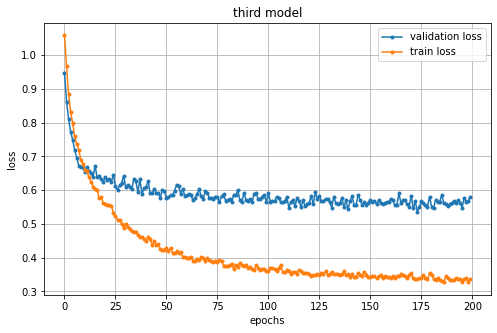

In [44]:
#visualization of the loss function
fig,ax=plt.subplots(1,1,figsize=(8,5))

ax.plot(np.arange(200),ae_pca_history.history['val_loss'], '.-', label='validation loss')
ax.plot(np.arange(200),ae_pca_history.history['loss'], '.-', label='train loss')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('third model')
ax.grid()
ax.legend()

In [52]:
ae_pca_results = ae_pca_model.evaluate(X_test_ae_pca,y_test)

print('Test loss: ' + str(ae_pca_results[0]))
print('Test accuracy: ' + str(ae_pca_results[1]))

511/511 [==============================] - 2s 3ms/step - loss: 0.5831 - mse: 0.5264
Test loss: 0.5830568075180054
Test accuracy: 0.5263633728027344


### Fourth model

In [47]:
X_train_pca,X_test_pca,y_train,y_test = train_test_split(X_pca, y_data, random_state=1046)
X_train_pca.shape

(48975, 285)

In [48]:
pca_model = get_regularized_model(X_train_pca[0].shape,0.0001,0.2)
compile_model(pca_model)
pca_history = pca_model.fit(X_train_pca,y_train,batch_size=490,epochs=200,validation_split=0.25)

Epoch 1/200
75/75 [==============================] - 6s 62ms/step - loss: 1.0675 - mse: 0.9892 - val_loss: 0.9553 - val_mse: 0.8796
Epoch 2/200
75/75 [==============================] - 2s 21ms/step - loss: 0.9696 - mse: 0.8957 - val_loss: 0.8452 - val_mse: 0.7728
Epoch 3/200
75/75 [==============================] - 2s 22ms/step - loss: 0.8668 - mse: 0.7955 - val_loss: 0.7606 - val_mse: 0.6903
Epoch 4/200
75/75 [==============================] - 2s 22ms/step - loss: 0.7910 - mse: 0.7214 - val_loss: 0.6858 - val_mse: 0.6169
Epoch 5/200
75/75 [==============================] - 2s 22ms/step - loss: 0.7314 - mse: 0.6632 - val_loss: 0.6423 - val_mse: 0.5748
Epoch 6/200
75/75 [==============================] - 1s 19ms/step - loss: 0.6950 - mse: 0.6281 - val_loss: 0.6315 - val_mse: 0.5652
Epoch 7/200
75/75 [==============================] - 2s 20ms/step - loss: 0.6680 - mse: 0.6024 - val_loss: 0.6197 - val_mse: 0.5547
Epoch 8/200
75/75 [==============================] - 1s 20ms/step - loss: 0.

75/75 [==============================] - 2s 21ms/step - loss: 0.4074 - mse: 0.3513 - val_loss: 0.5612 - val_mse: 0.5051
Epoch 63/200
75/75 [==============================] - 2s 22ms/step - loss: 0.4020 - mse: 0.3458 - val_loss: 0.5739 - val_mse: 0.5176
Epoch 64/200
75/75 [==============================] - 2s 20ms/step - loss: 0.3886 - mse: 0.3323 - val_loss: 0.5668 - val_mse: 0.5104
Epoch 65/200
75/75 [==============================] - 1s 20ms/step - loss: 0.3931 - mse: 0.3367 - val_loss: 0.5777 - val_mse: 0.5212
Epoch 66/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3964 - mse: 0.3398 - val_loss: 0.5558 - val_mse: 0.4992
Epoch 67/200
75/75 [==============================] - 2s 21ms/step - loss: 0.3896 - mse: 0.3329 - val_loss: 0.5768 - val_mse: 0.5200
Epoch 68/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3854 - mse: 0.3286 - val_loss: 0.5411 - val_mse: 0.4843
Epoch 69/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3892 

75/75 [==============================] - 1s 19ms/step - loss: 0.3439 - mse: 0.2818 - val_loss: 0.5451 - val_mse: 0.4829
Epoch 124/200
75/75 [==============================] - 1s 18ms/step - loss: 0.3479 - mse: 0.2856 - val_loss: 0.5343 - val_mse: 0.4719
Epoch 125/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3433 - mse: 0.2810 - val_loss: 0.5387 - val_mse: 0.4764
Epoch 126/200
75/75 [==============================] - 2s 20ms/step - loss: 0.3481 - mse: 0.2857 - val_loss: 0.5350 - val_mse: 0.4726
Epoch 127/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3438 - mse: 0.2812 - val_loss: 0.5519 - val_mse: 0.4893
Epoch 128/200
75/75 [==============================] - 1s 18ms/step - loss: 0.3499 - mse: 0.2874 - val_loss: 0.5492 - val_mse: 0.4866
Epoch 129/200
75/75 [==============================] - 1s 20ms/step - loss: 0.3439 - mse: 0.2813 - val_loss: 0.5629 - val_mse: 0.5001
Epoch 130/200
75/75 [==============================] - 2s 20ms/step - loss: 

75/75 [==============================] - 1s 18ms/step - loss: 0.3364 - mse: 0.2707 - val_loss: 0.5282 - val_mse: 0.4623
Epoch 185/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3375 - mse: 0.2717 - val_loss: 0.5440 - val_mse: 0.4781
Epoch 186/200
75/75 [==============================] - 1s 18ms/step - loss: 0.3303 - mse: 0.2644 - val_loss: 0.5359 - val_mse: 0.4698
Epoch 187/200
75/75 [==============================] - 1s 18ms/step - loss: 0.3259 - mse: 0.2599 - val_loss: 0.5440 - val_mse: 0.4780
Epoch 188/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3274 - mse: 0.2615 - val_loss: 0.5223 - val_mse: 0.4564
Epoch 189/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3317 - mse: 0.2657 - val_loss: 0.5319 - val_mse: 0.4658
Epoch 190/200
75/75 [==============================] - 1s 19ms/step - loss: 0.3206 - mse: 0.2547 - val_loss: 0.5276 - val_mse: 0.4615
Epoch 191/200
75/75 [==============================] - 1s 19ms/step - loss: 

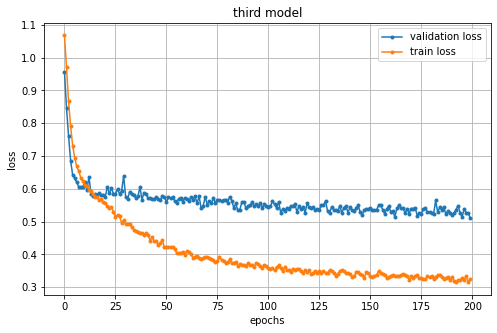

In [49]:
#visualization of the loss function
fig,ax=plt.subplots(1,1,figsize=(8,5))

ax.plot(np.arange(200),pca_history.history['val_loss'], '.-', label='validation loss')
ax.plot(np.arange(200),pca_history.history['loss'], '.-', label='train loss')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('third model')
ax.grid()
ax.legend()

In [51]:
pca_results = pca_model.evaluate(X_test_pca,y_test)

print('Test loss: ' + str(pca_results[0]))
print('Test accuracy: ' + str(pca_results[1]))

511/511 [==============================] - 2s 3ms/step - loss: 0.5024 - mse: 0.4359
Test loss: 0.5024471879005432
Test accuracy: 0.43589839339256287


## Conclusions

Finally, we can show that the models that present a better result are the ones obtained for the dimension reduction processes carried out on the total set of initial data both for the use of AE and for the PCA process, obtaining similar values ​​for loss and accuracy in both cases.

Given that these 2 dimension reduction processes give similar results when applying the generated variables to a regression model, we can guess that in this case the compression process performed by the autoencoders is similar to the process performed by the PCA by so the compressed variables most likely have a very linear relationship. although this would have to be reviewed more thoroughly.

Finally, the regression models obtained are clearly not reliable enough to make accurate predictions, but taking into account that we are mainly analyzing the dependence of the influx on the climatic conditions of the city (variables that clearly influence this but are not the main influence) good results were obtained.